In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import os
import json


#plot Options
import matplotlib as mpl
font = {#'family' : 'normal','weight' : 'bold',
        'size'   : 16
        #,'serif':['Helvetica']
        }
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 400

###
####constants
degree = np.pi/180 # convert form rad to degree


Attempt to model that the Capillary gets obscured by its housing 
in parts and not all at once

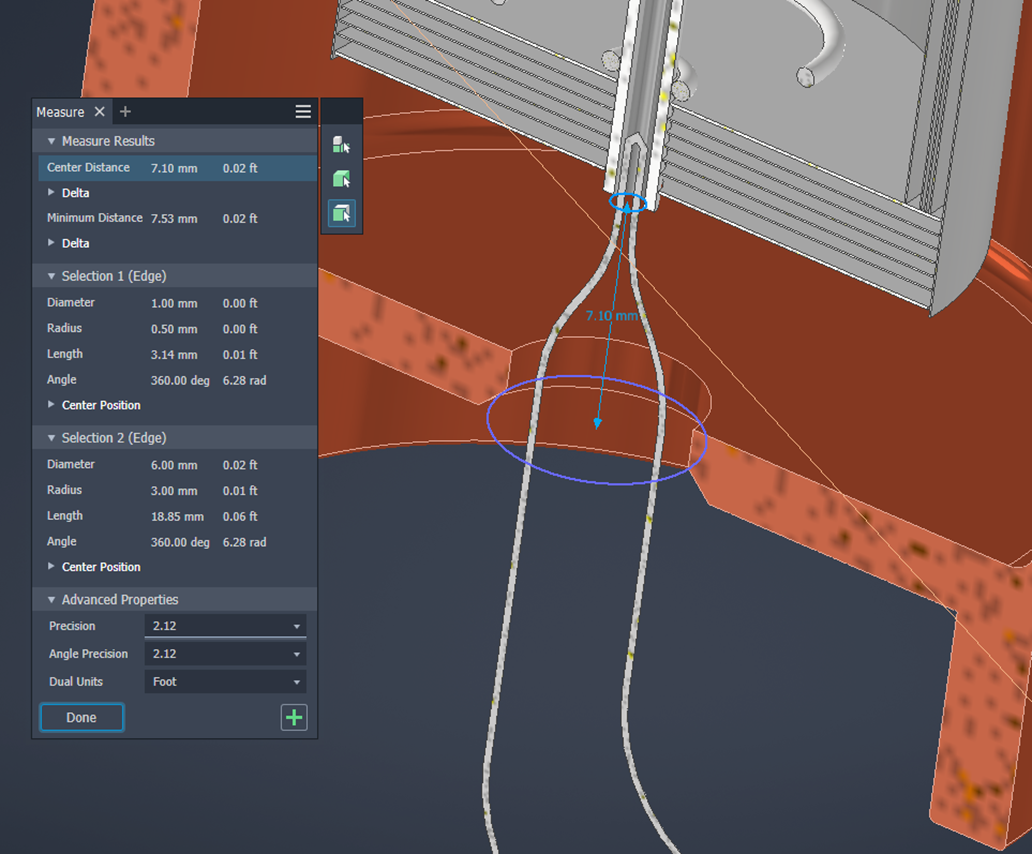

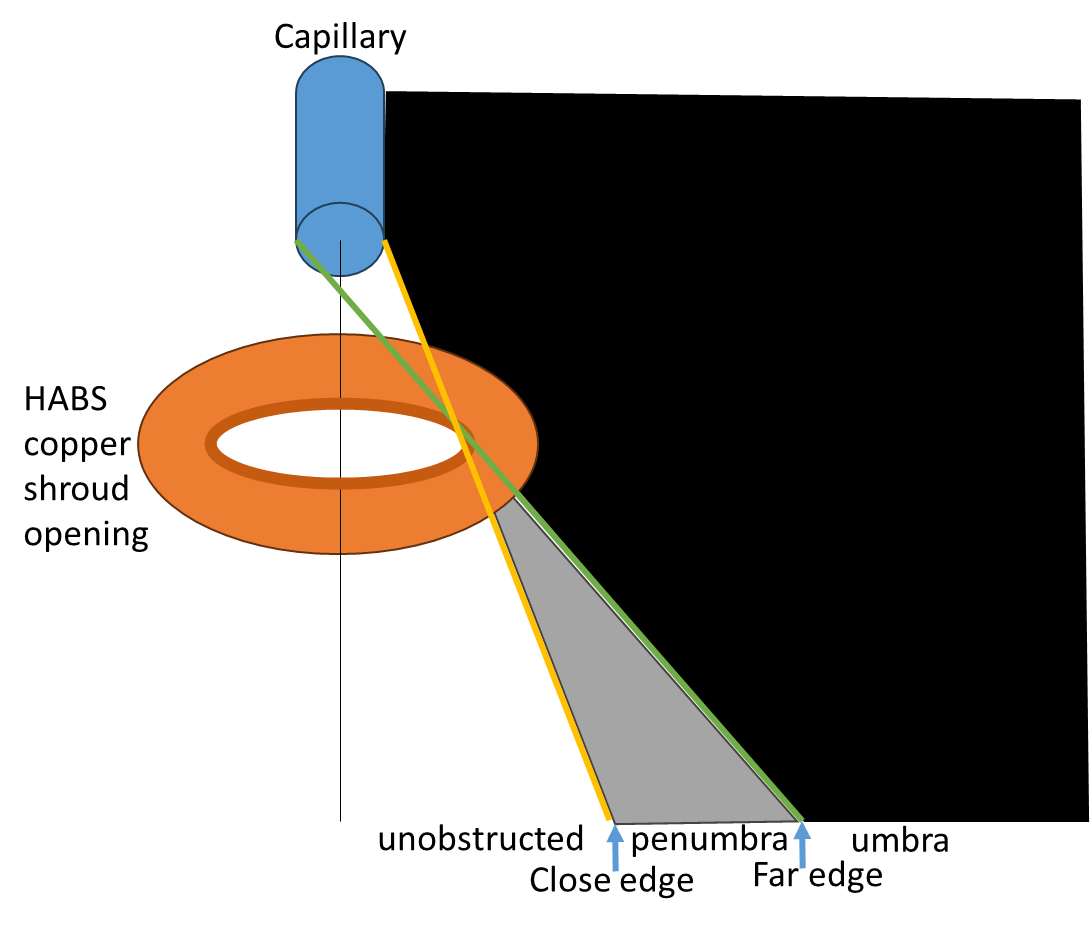

In [4]:
#2024-04-12 new version to be a real integral  over the capillary surface, and 
# to include an approximation for capillary intensity variation as seen in
# Sebastian Kochhs approximation
def visible_fraction(theta):
    # calculate fraction of the capillary that is visible under a
    # given angle
    # Presumes capillary to be centered on opening  in HABS housing
    radius_cap = 0.5 # mm
    distance_cap_housing = 7.1 # mm
    radius_housing = 3.0 # mm

    # calculate edges of penumbra
    # inner (close) edge
    theta_inner = np.arctan((radius_housing - radius_cap)
                            /distance_cap_housing)
    theta_outer = np.arctan((radius_housing + radius_cap)
                            /distance_cap_housing)

    # print("inner edge:", theta_inner, theta_inner / degree)
    # print("outer edge:", theta_outer, theta_outer / degree)#
    # # speed up by eliminating  this calculation
    # theta_inner = 0.3385556949116842 # 19.3978 deg 
    # theta_outer = 0.45799795159722173 # 26.2413 deg
    if np.abs(theta) <= theta_inner:
        fraction = 1
    elif np.abs(theta) >= theta_outer:
        fraction = 0
    else:
        # Take shortcut initially
        # HACK Linearly interpolate between inner and outer angles
        int_var = (2 *  ((theta_outer - np.abs(theta)) 
                    / (theta_outer - theta_inner))) - 1
        # Integrated circle equation
        vis_frac = lambda x: (np.sqrt(1-x**2) * x 
                                + np.arcsin(x)
                                + np.pi/2)/np.pi
        fraction = vis_frac(int_var)
    return fraction
    

In [135]:
a= [1,2,3]
[a[i] for i in  [0,1]]

IndexError: list index out of range

In [5]:
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg

### Plot extracted beam shape with l_eff and visible fraction

In [6]:
degree = np.pi/180
# remember to input values in radians
def beta(theta, l_eff):

    output = np.zeros_like(theta) 
    cond = np.abs(l_eff * np.tan(theta)) < 1
    output[cond] =  np.arccos(l_eff * np.tan(theta[cond]))
    return output


def U(theta, l_eff):
    # Move conditional to beta only
    return (2*beta(theta, l_eff)-np.sin(2*beta(theta, l_eff)))/np.pi

def V(theta, l_eff):
    # Move conditional to beta only
    return np.sin(beta(theta, l_eff))**3

def jd(theta, l_eff):
    return np.cos(theta) * U(theta, l_eff)

def jw(theta, l_eff):
    result = (
    (4/(3*np.pi))*(1-1/(2*l_eff + 1)) * (1/l_eff) 
    * (np.cos(theta)**2 / np.sin(theta)) 
    * (1-V(theta, l_eff))
    + (1/(2*l_eff + 1))*np.cos(theta) * (1-U(theta, l_eff))
    )
    return result

def j(theta, l_eff):
    return jd(theta, l_eff) + jw(theta, l_eff)

In [7]:
def new_H_profile(theta, l_eff):
    return j(theta, l_eff) * visible_fraction(theta)

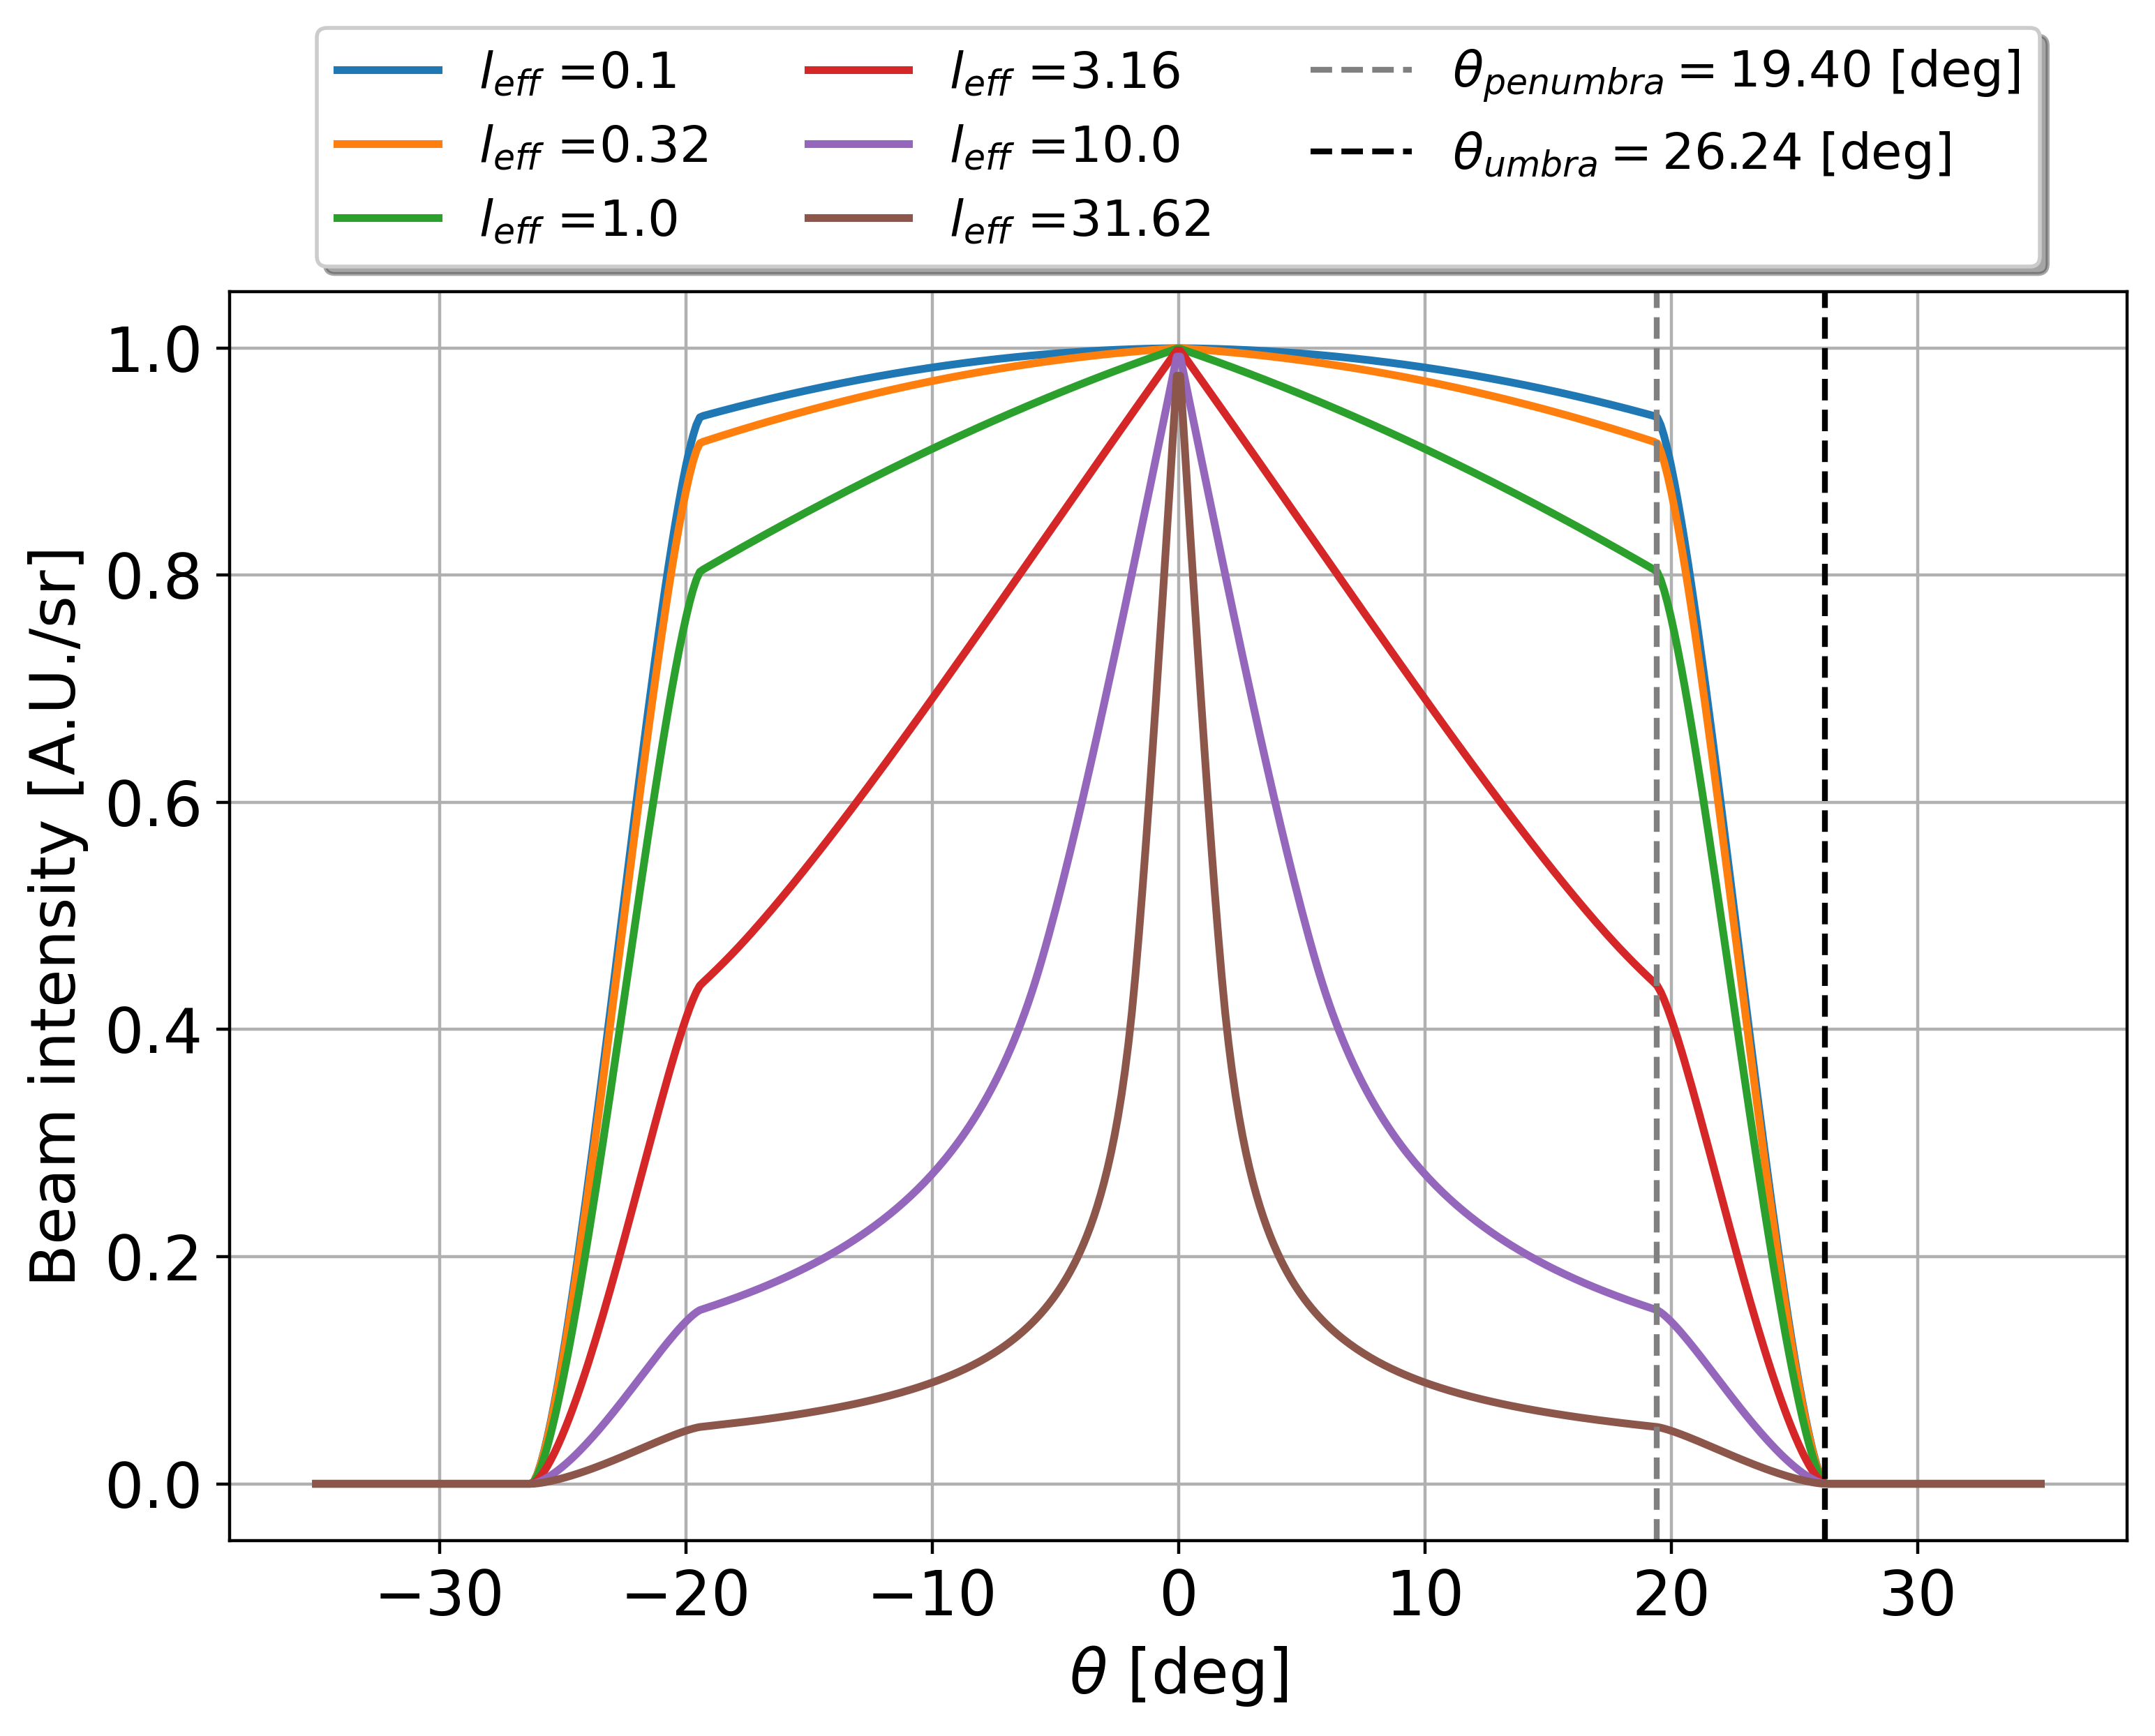

In [8]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [new_H_profile(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Beam intensity [A.U./sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

Calculate MAss spec beam opening size

In [9]:
np.tan(2/200)/degree

0.572976894487969

Plot the same but integrated over solid angle

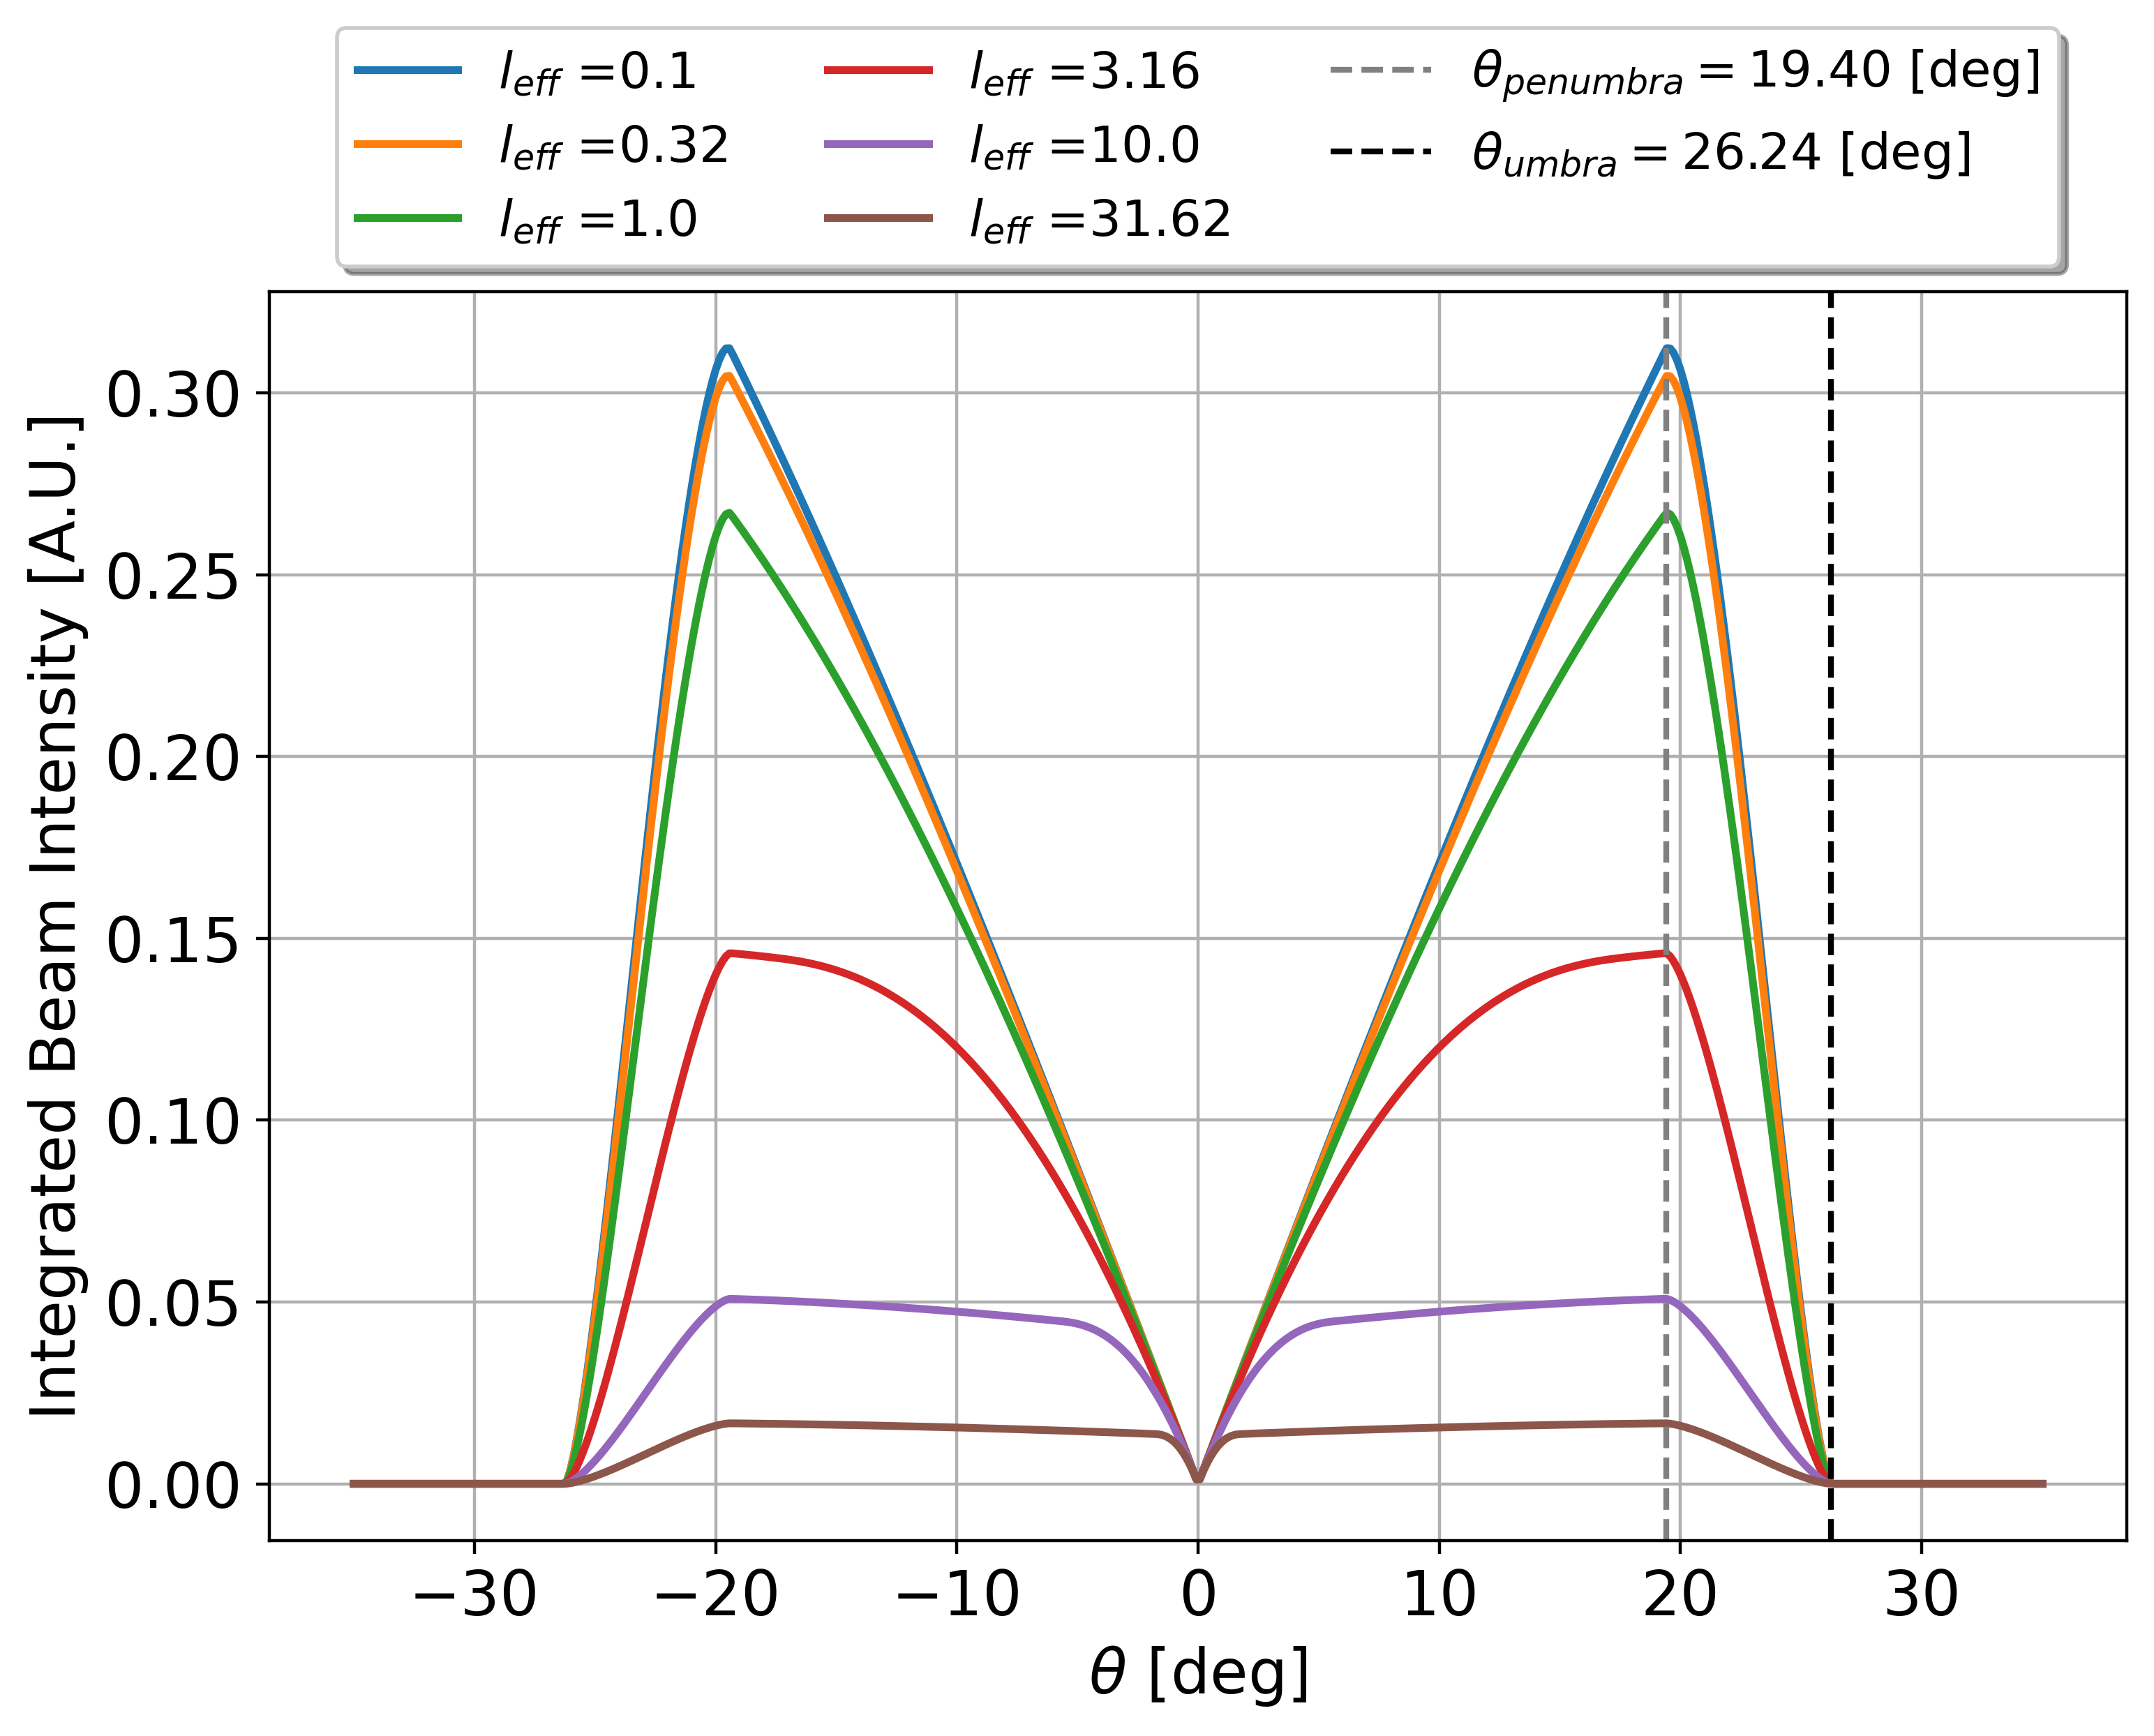

In [10]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*new_H_profile(np.abs(x) * degree, 
                                                   l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Integrated Beam Intensity [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

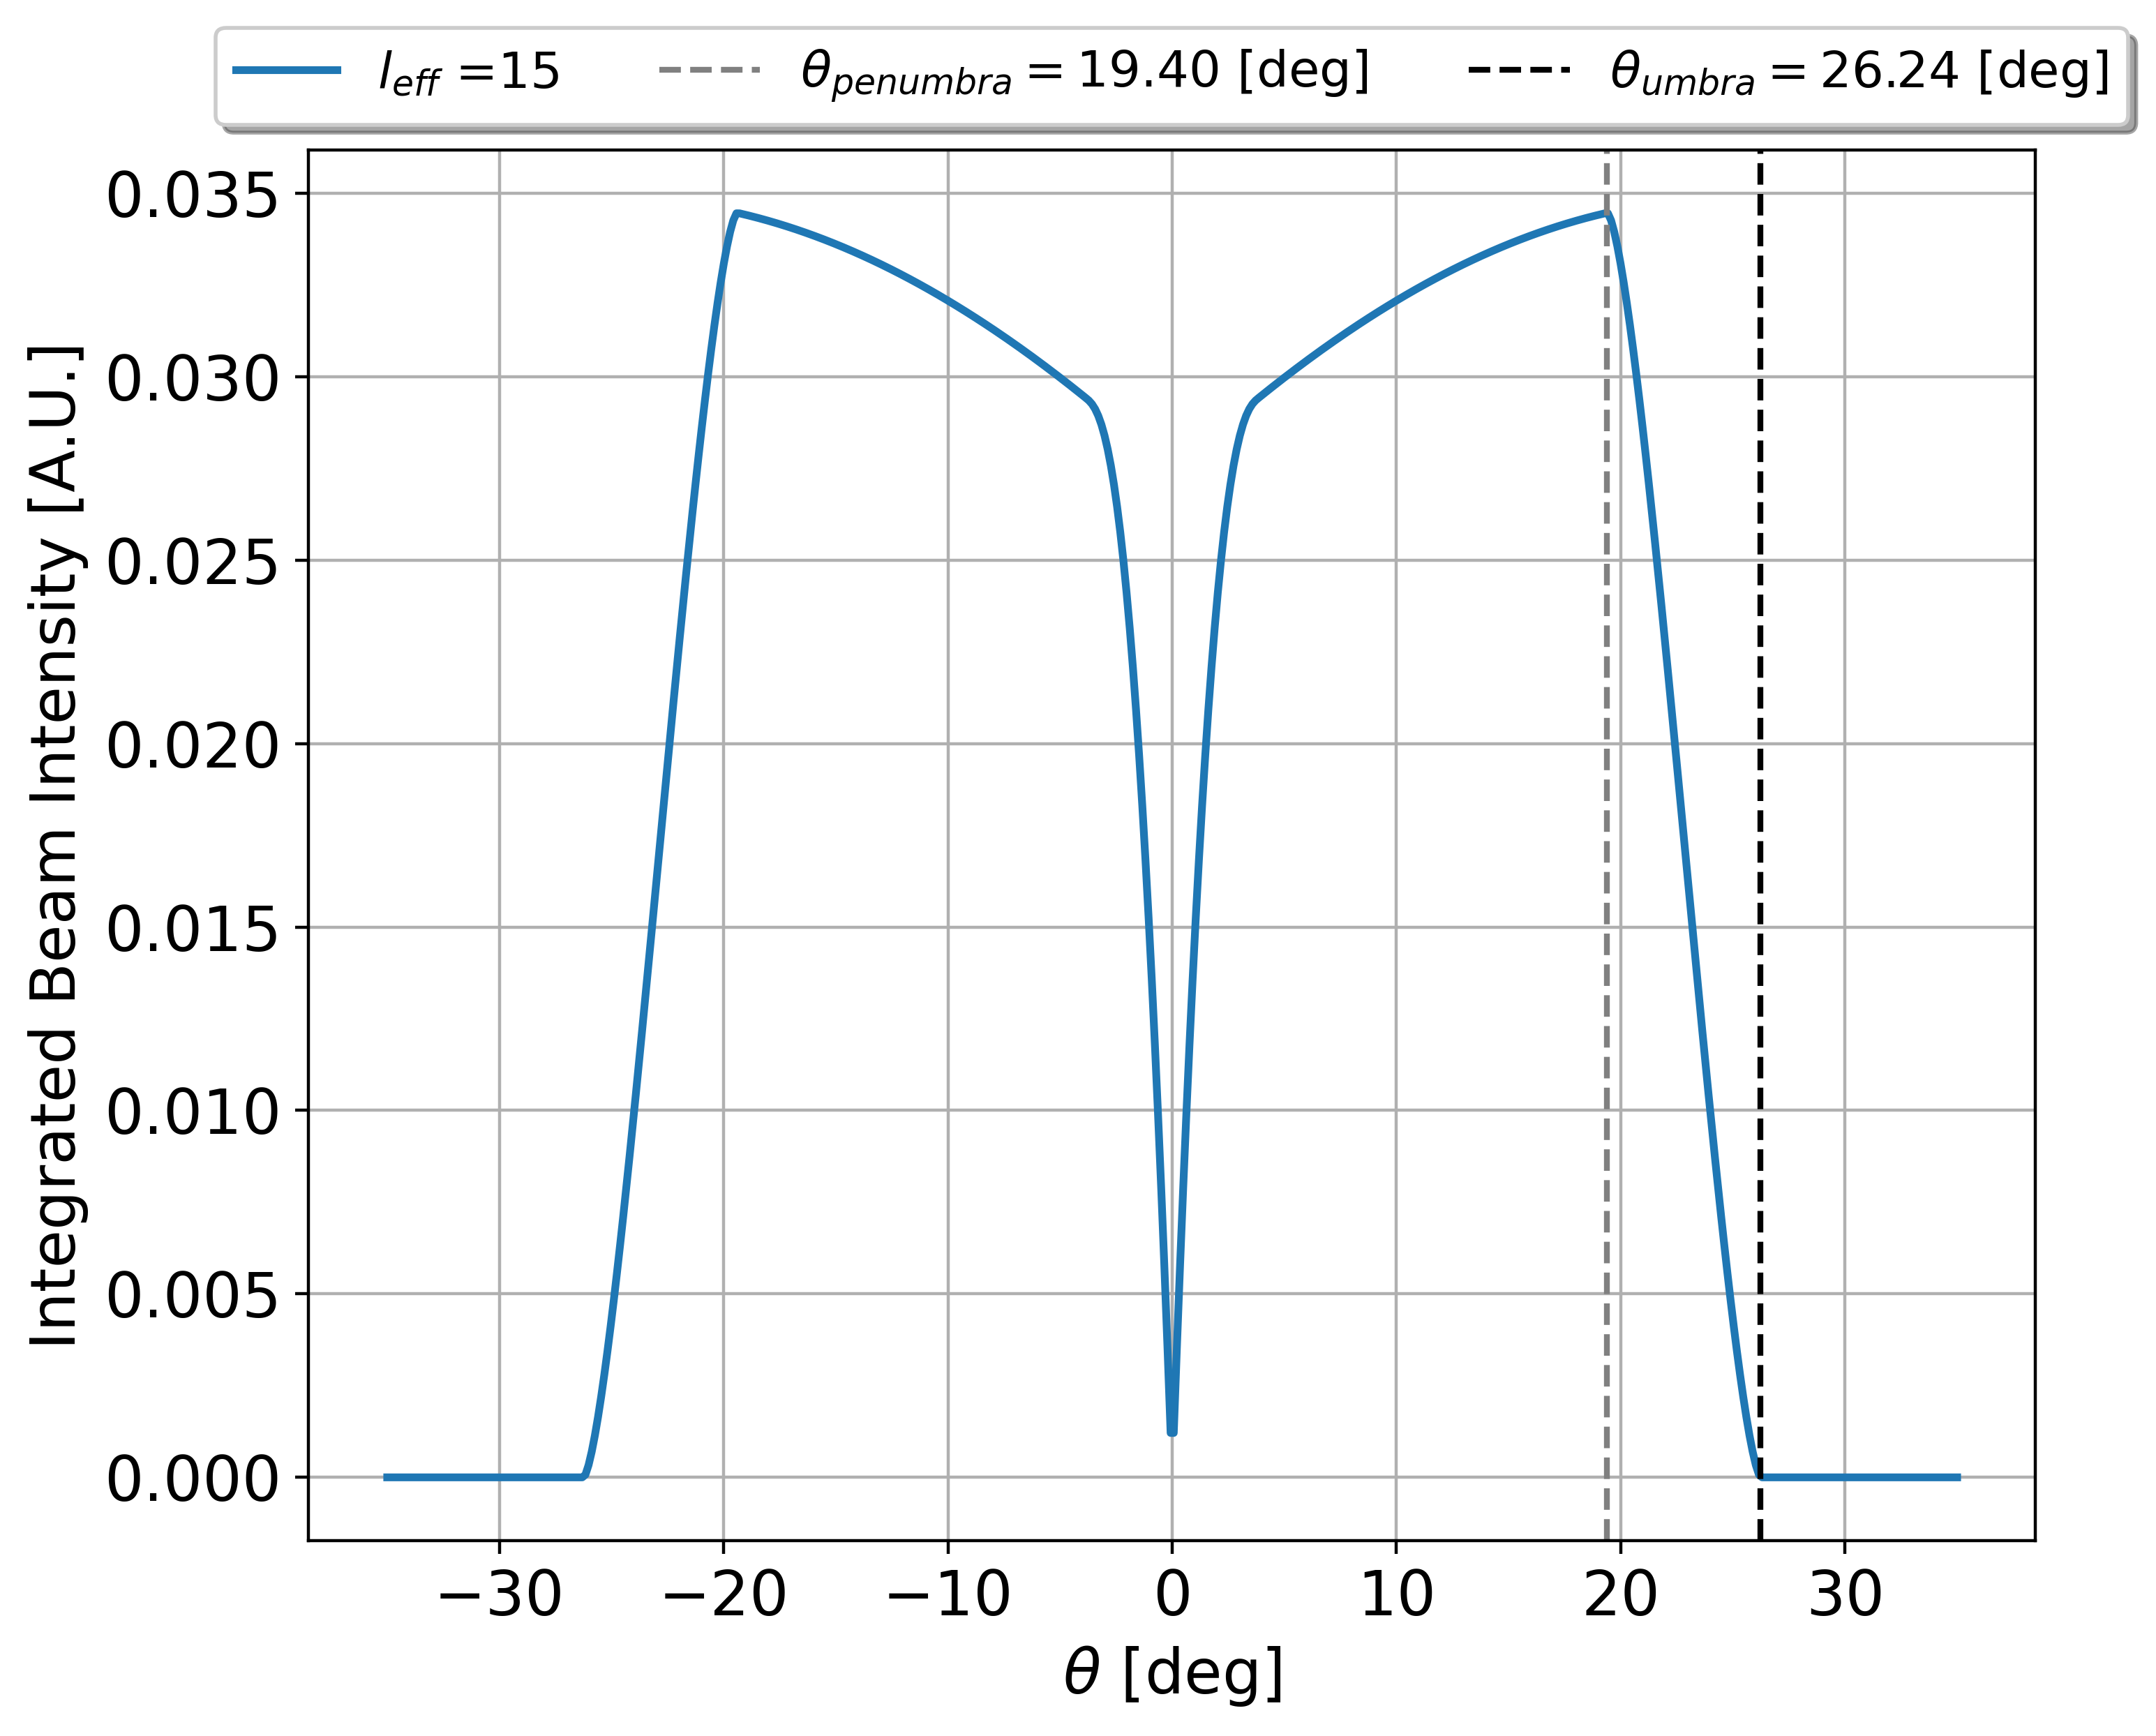

In [11]:
l_effs = [15]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*new_H_profile(np.abs(x) * degree, 
                                                   l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{eff}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
        + f"{theta_inner/degree:.2f} [deg]", 
        color = "gray", alpha = 1, ls = "--")
ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
        + f"{theta_outer/degree:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Integrated Beam Intensity [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 13
            )
plt.tight_layout()
plt.grid(True)

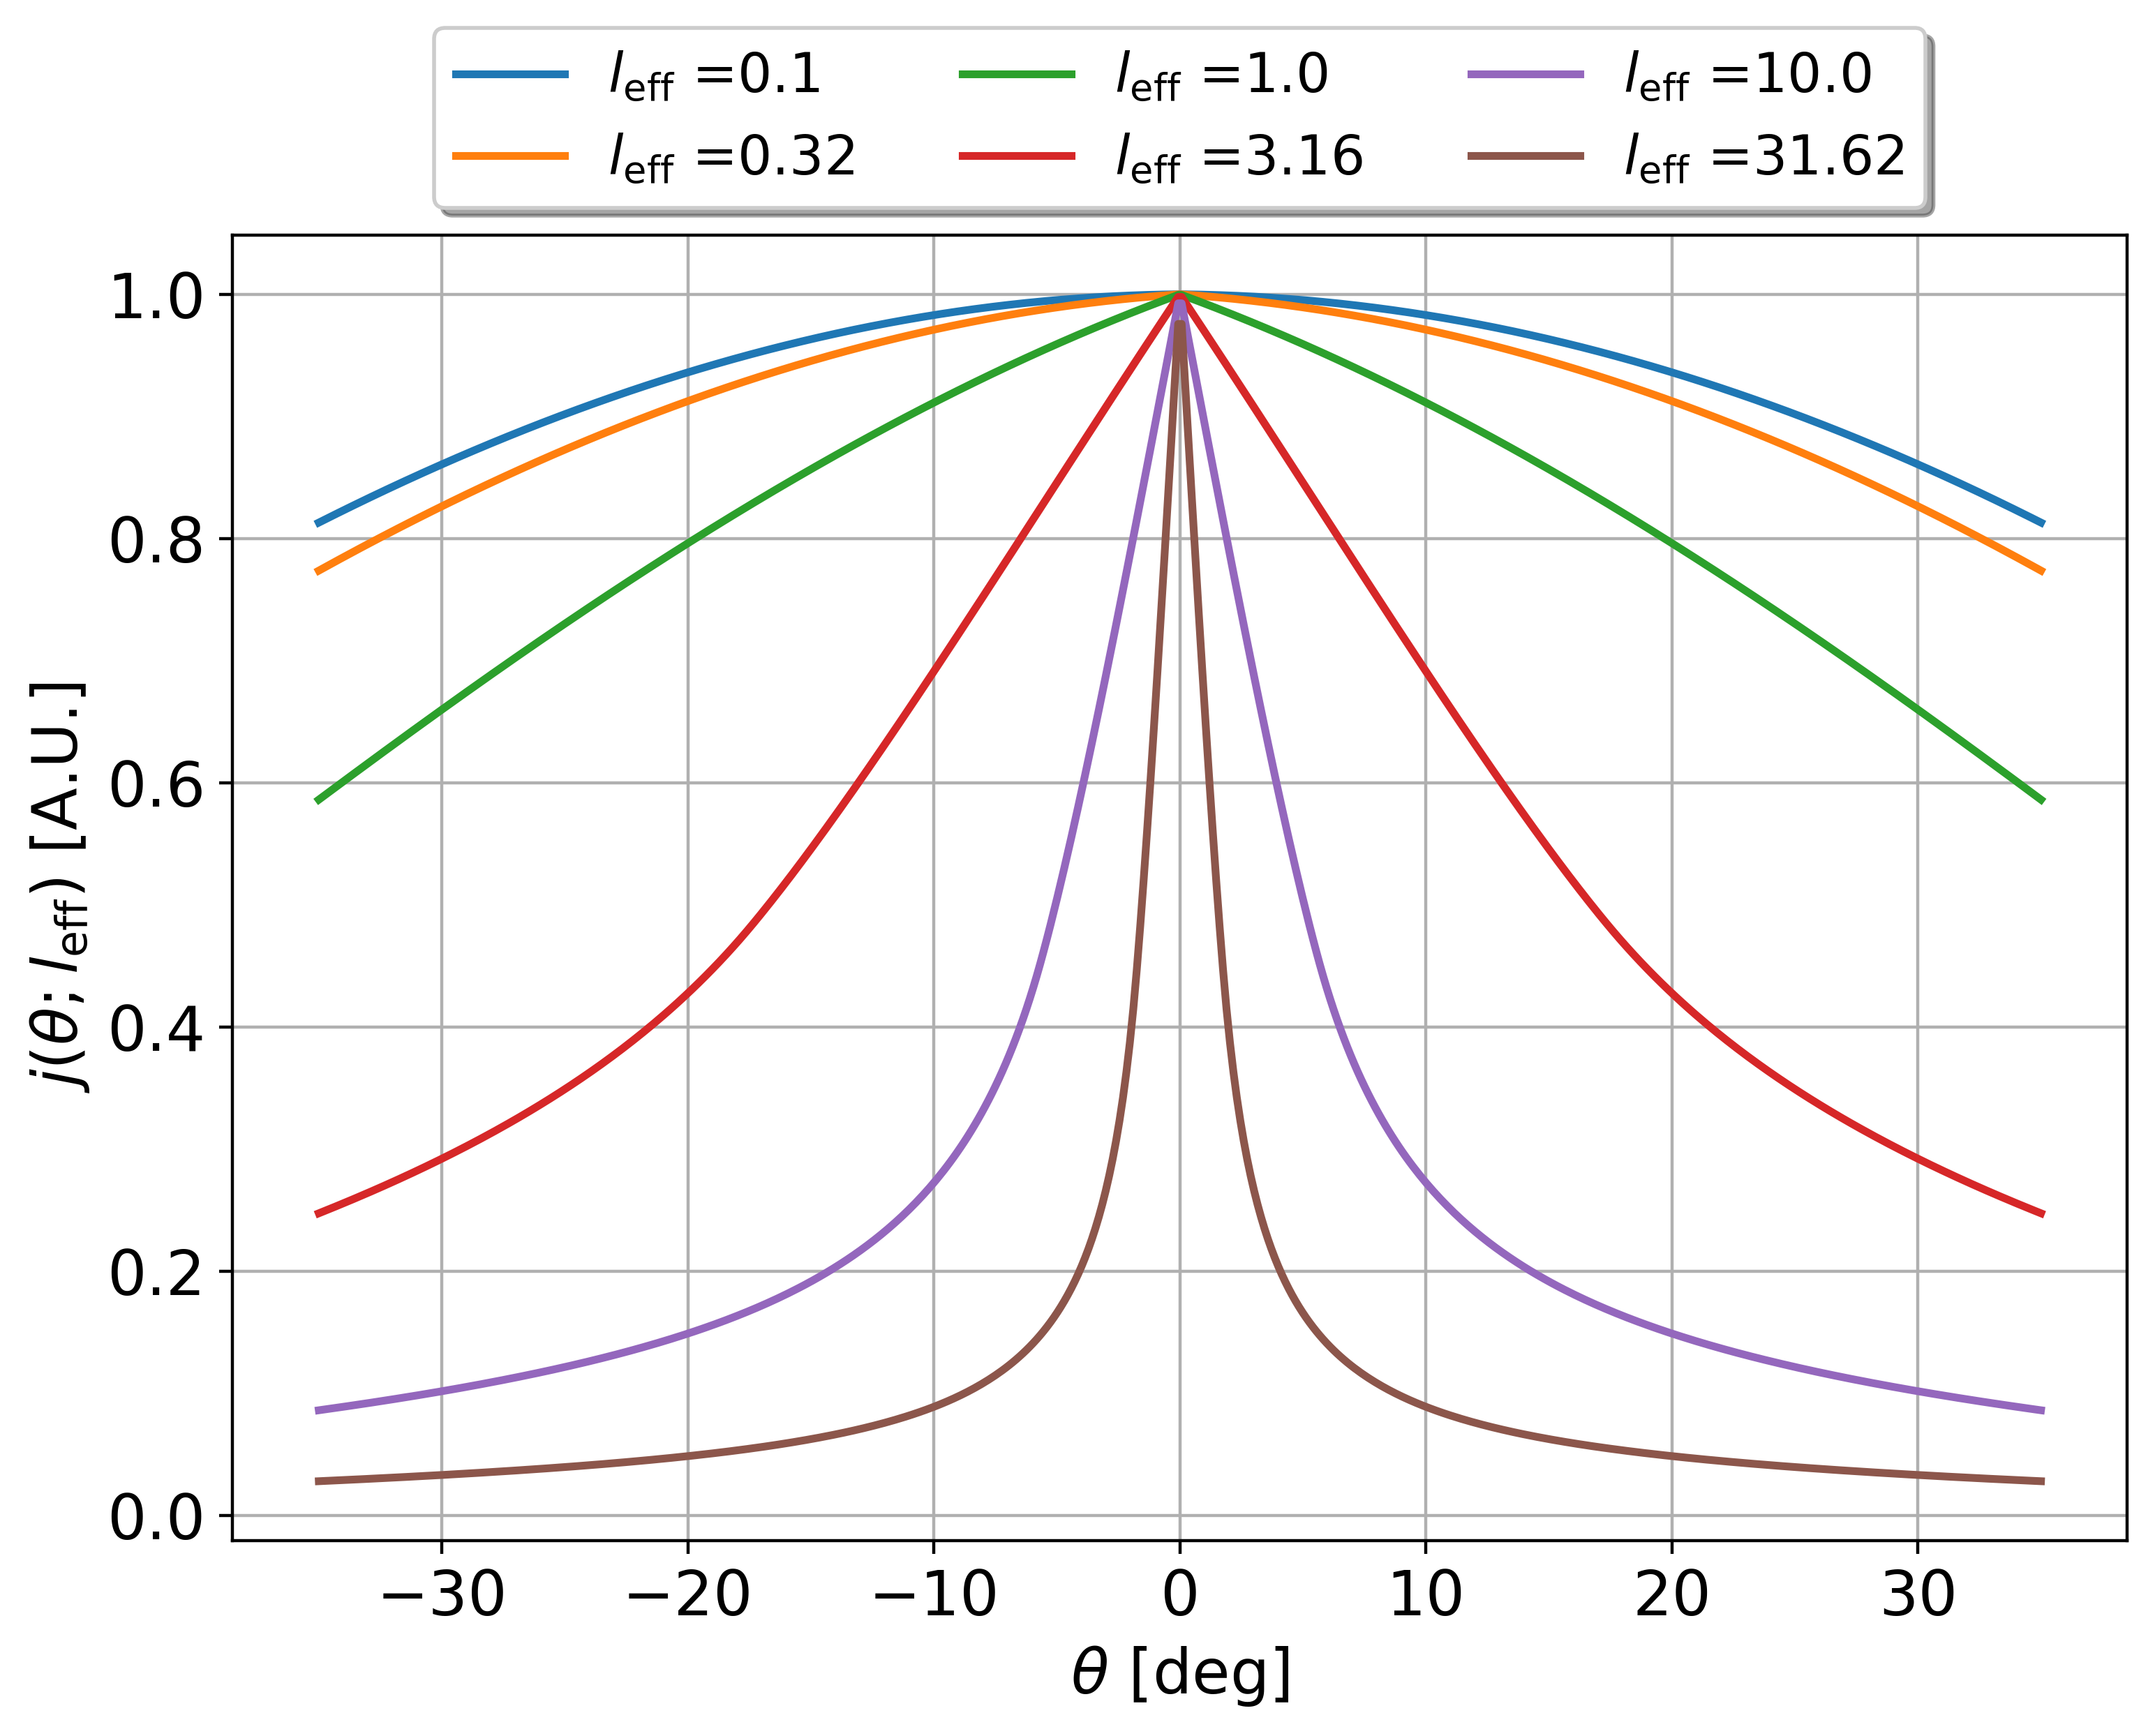

In [12]:
l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys = [j(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


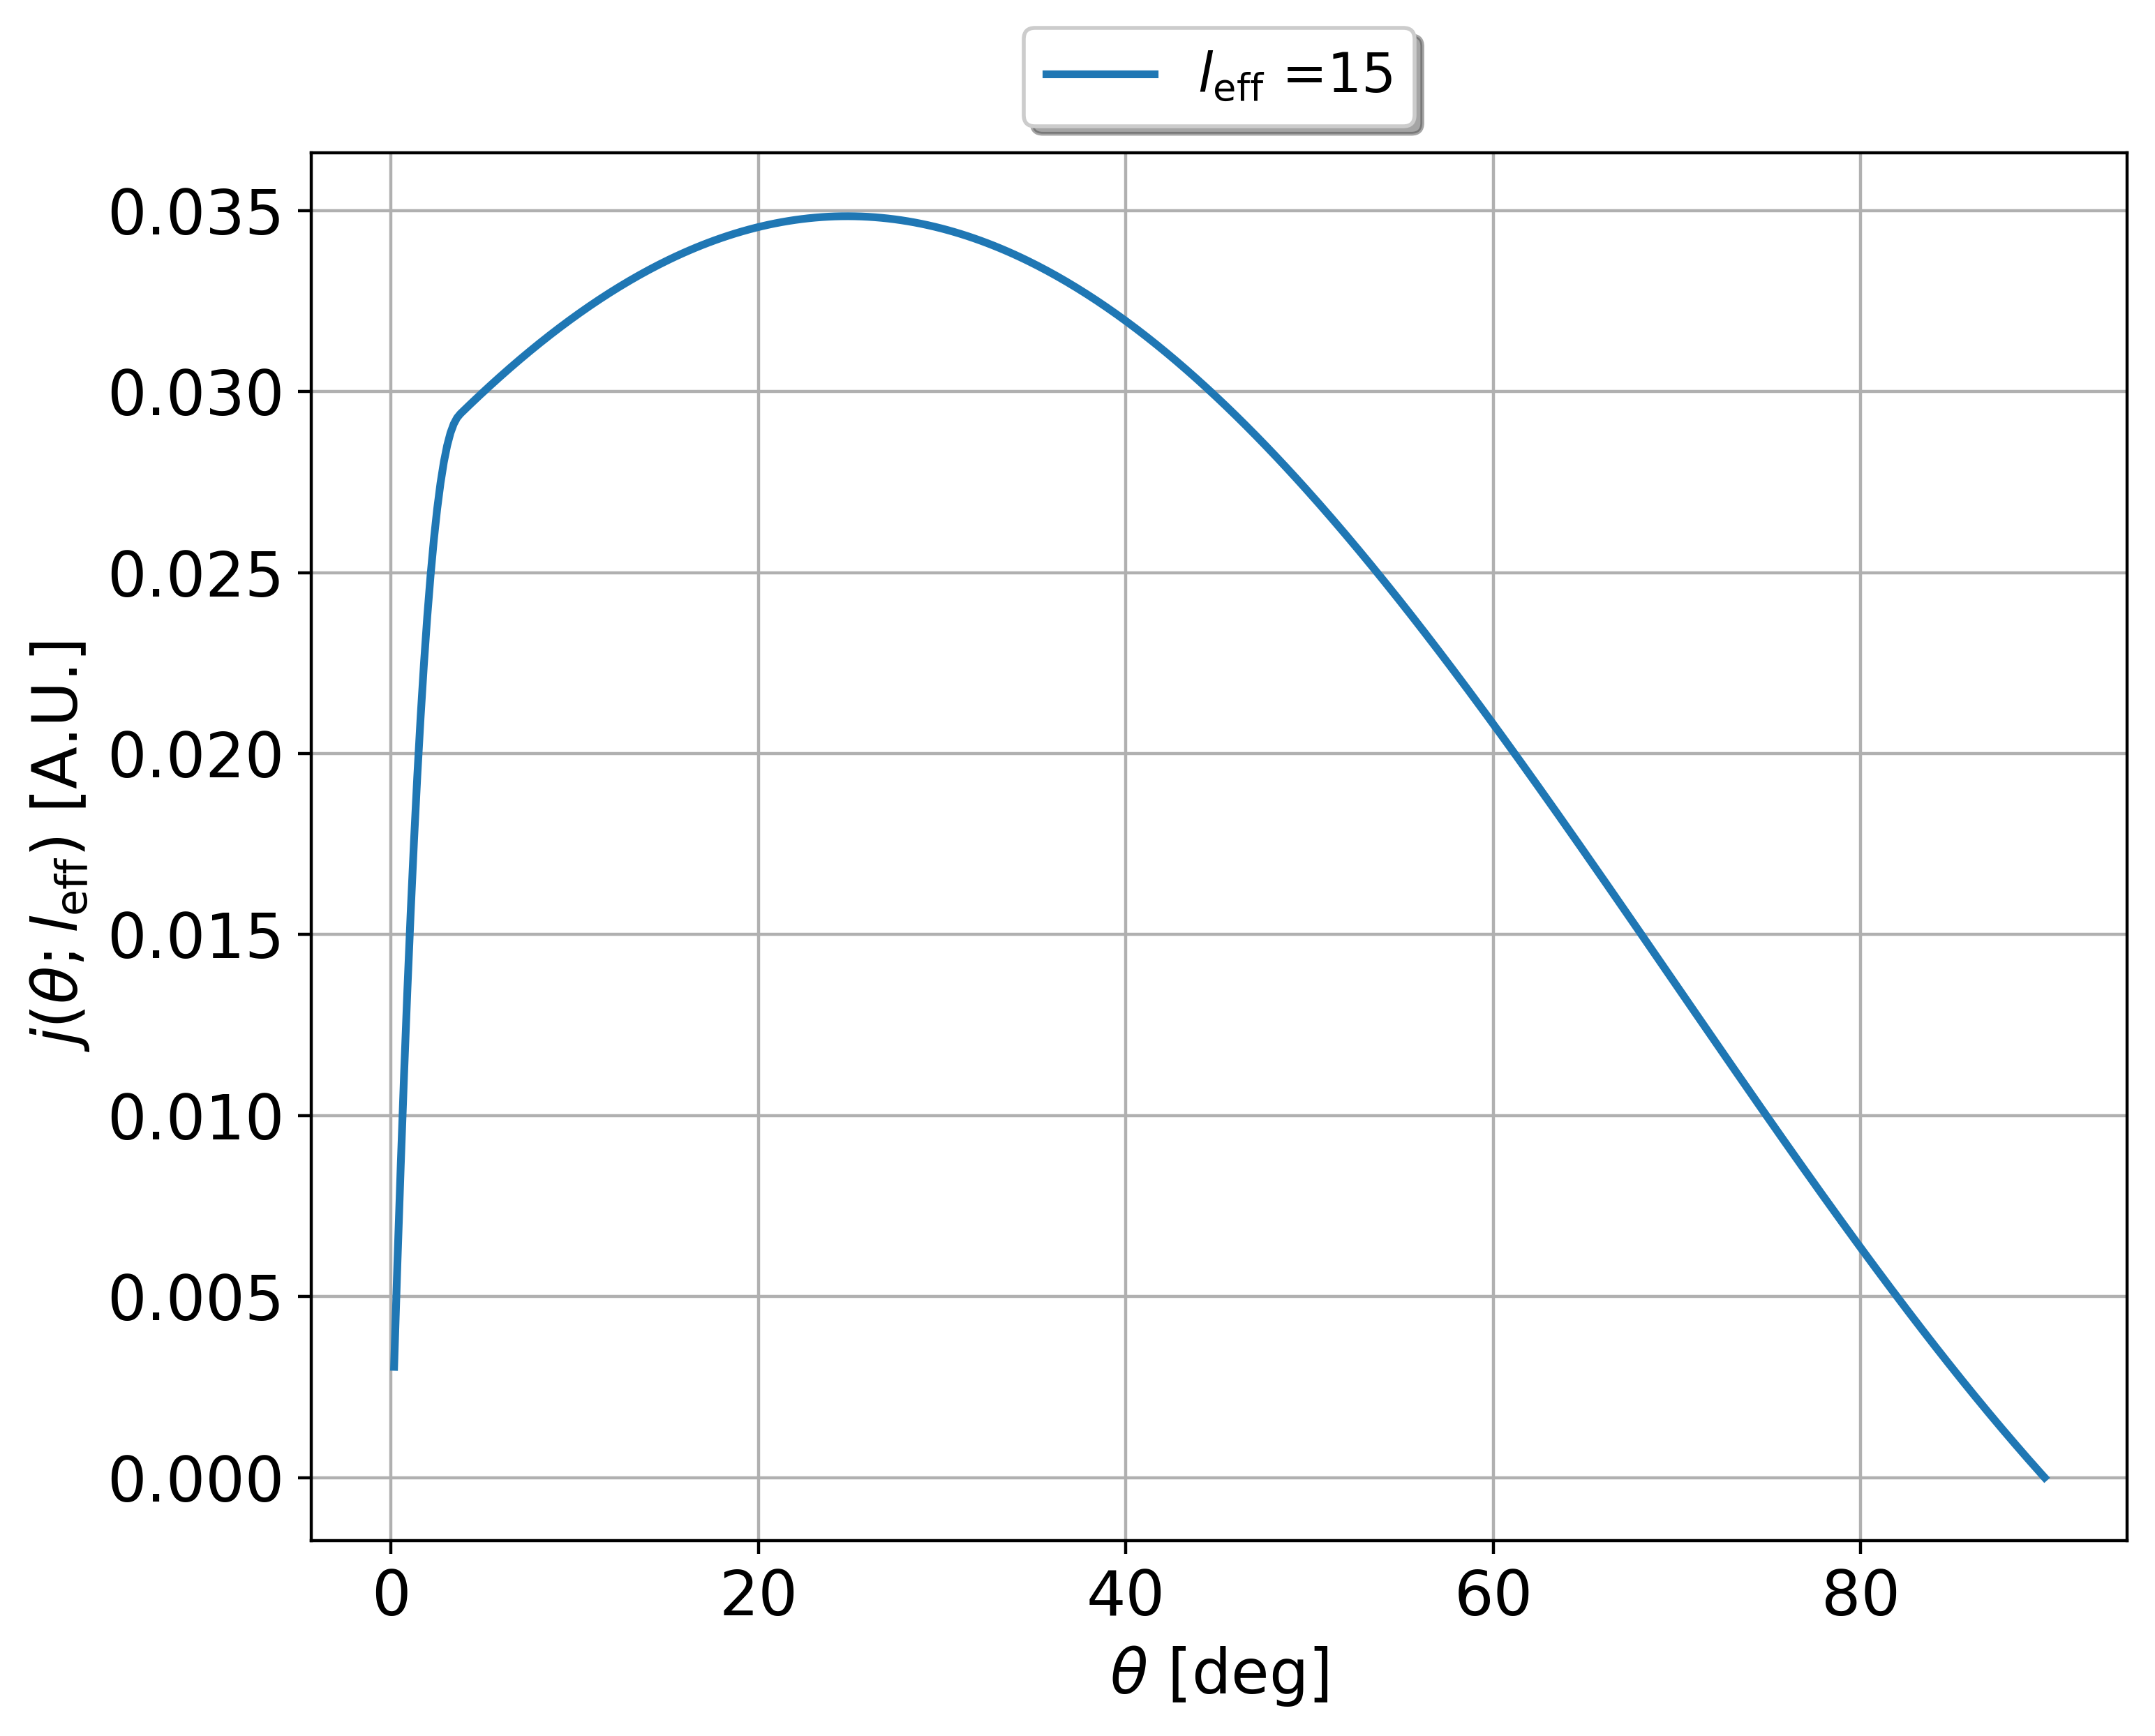

In [13]:
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [15]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*j(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            # color = "C1" ,
            label = r"$l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


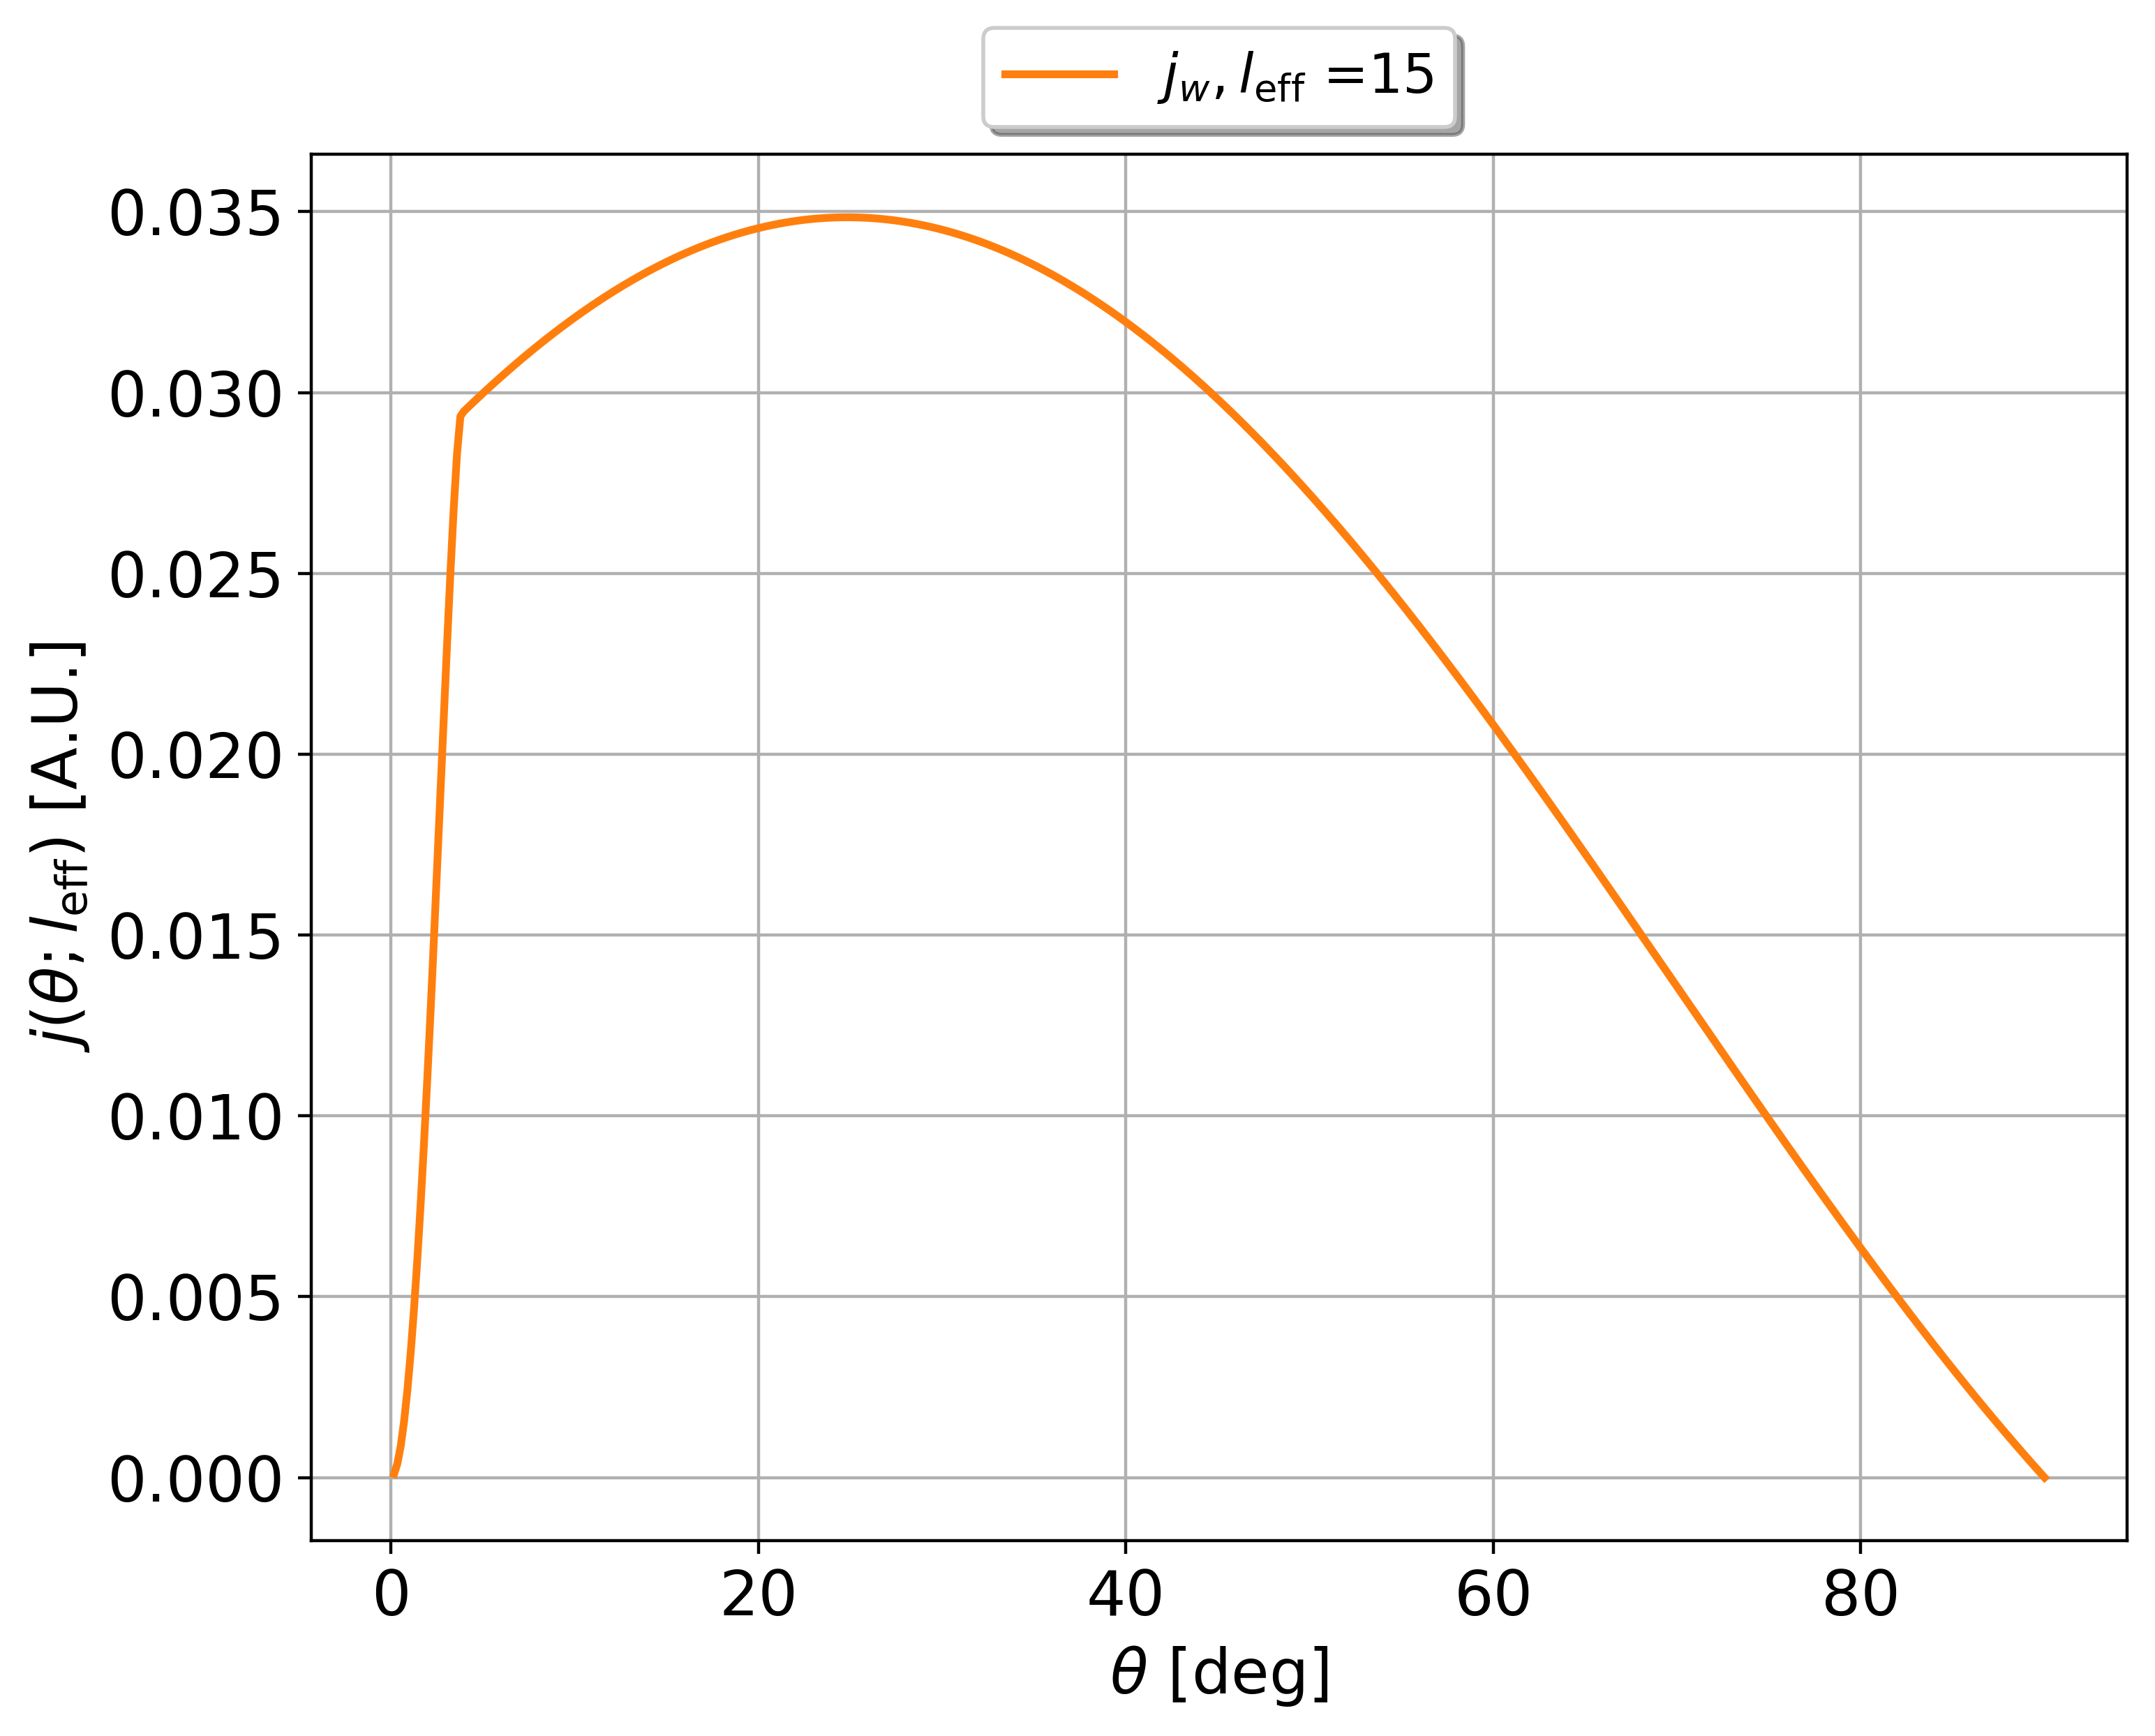

In [14]:
''' JUST jw'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [15]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys = [np.sin(np.abs(x) * degree)*jw(np.abs(x) * degree, l_eff = l_eff) for x in xs]

    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


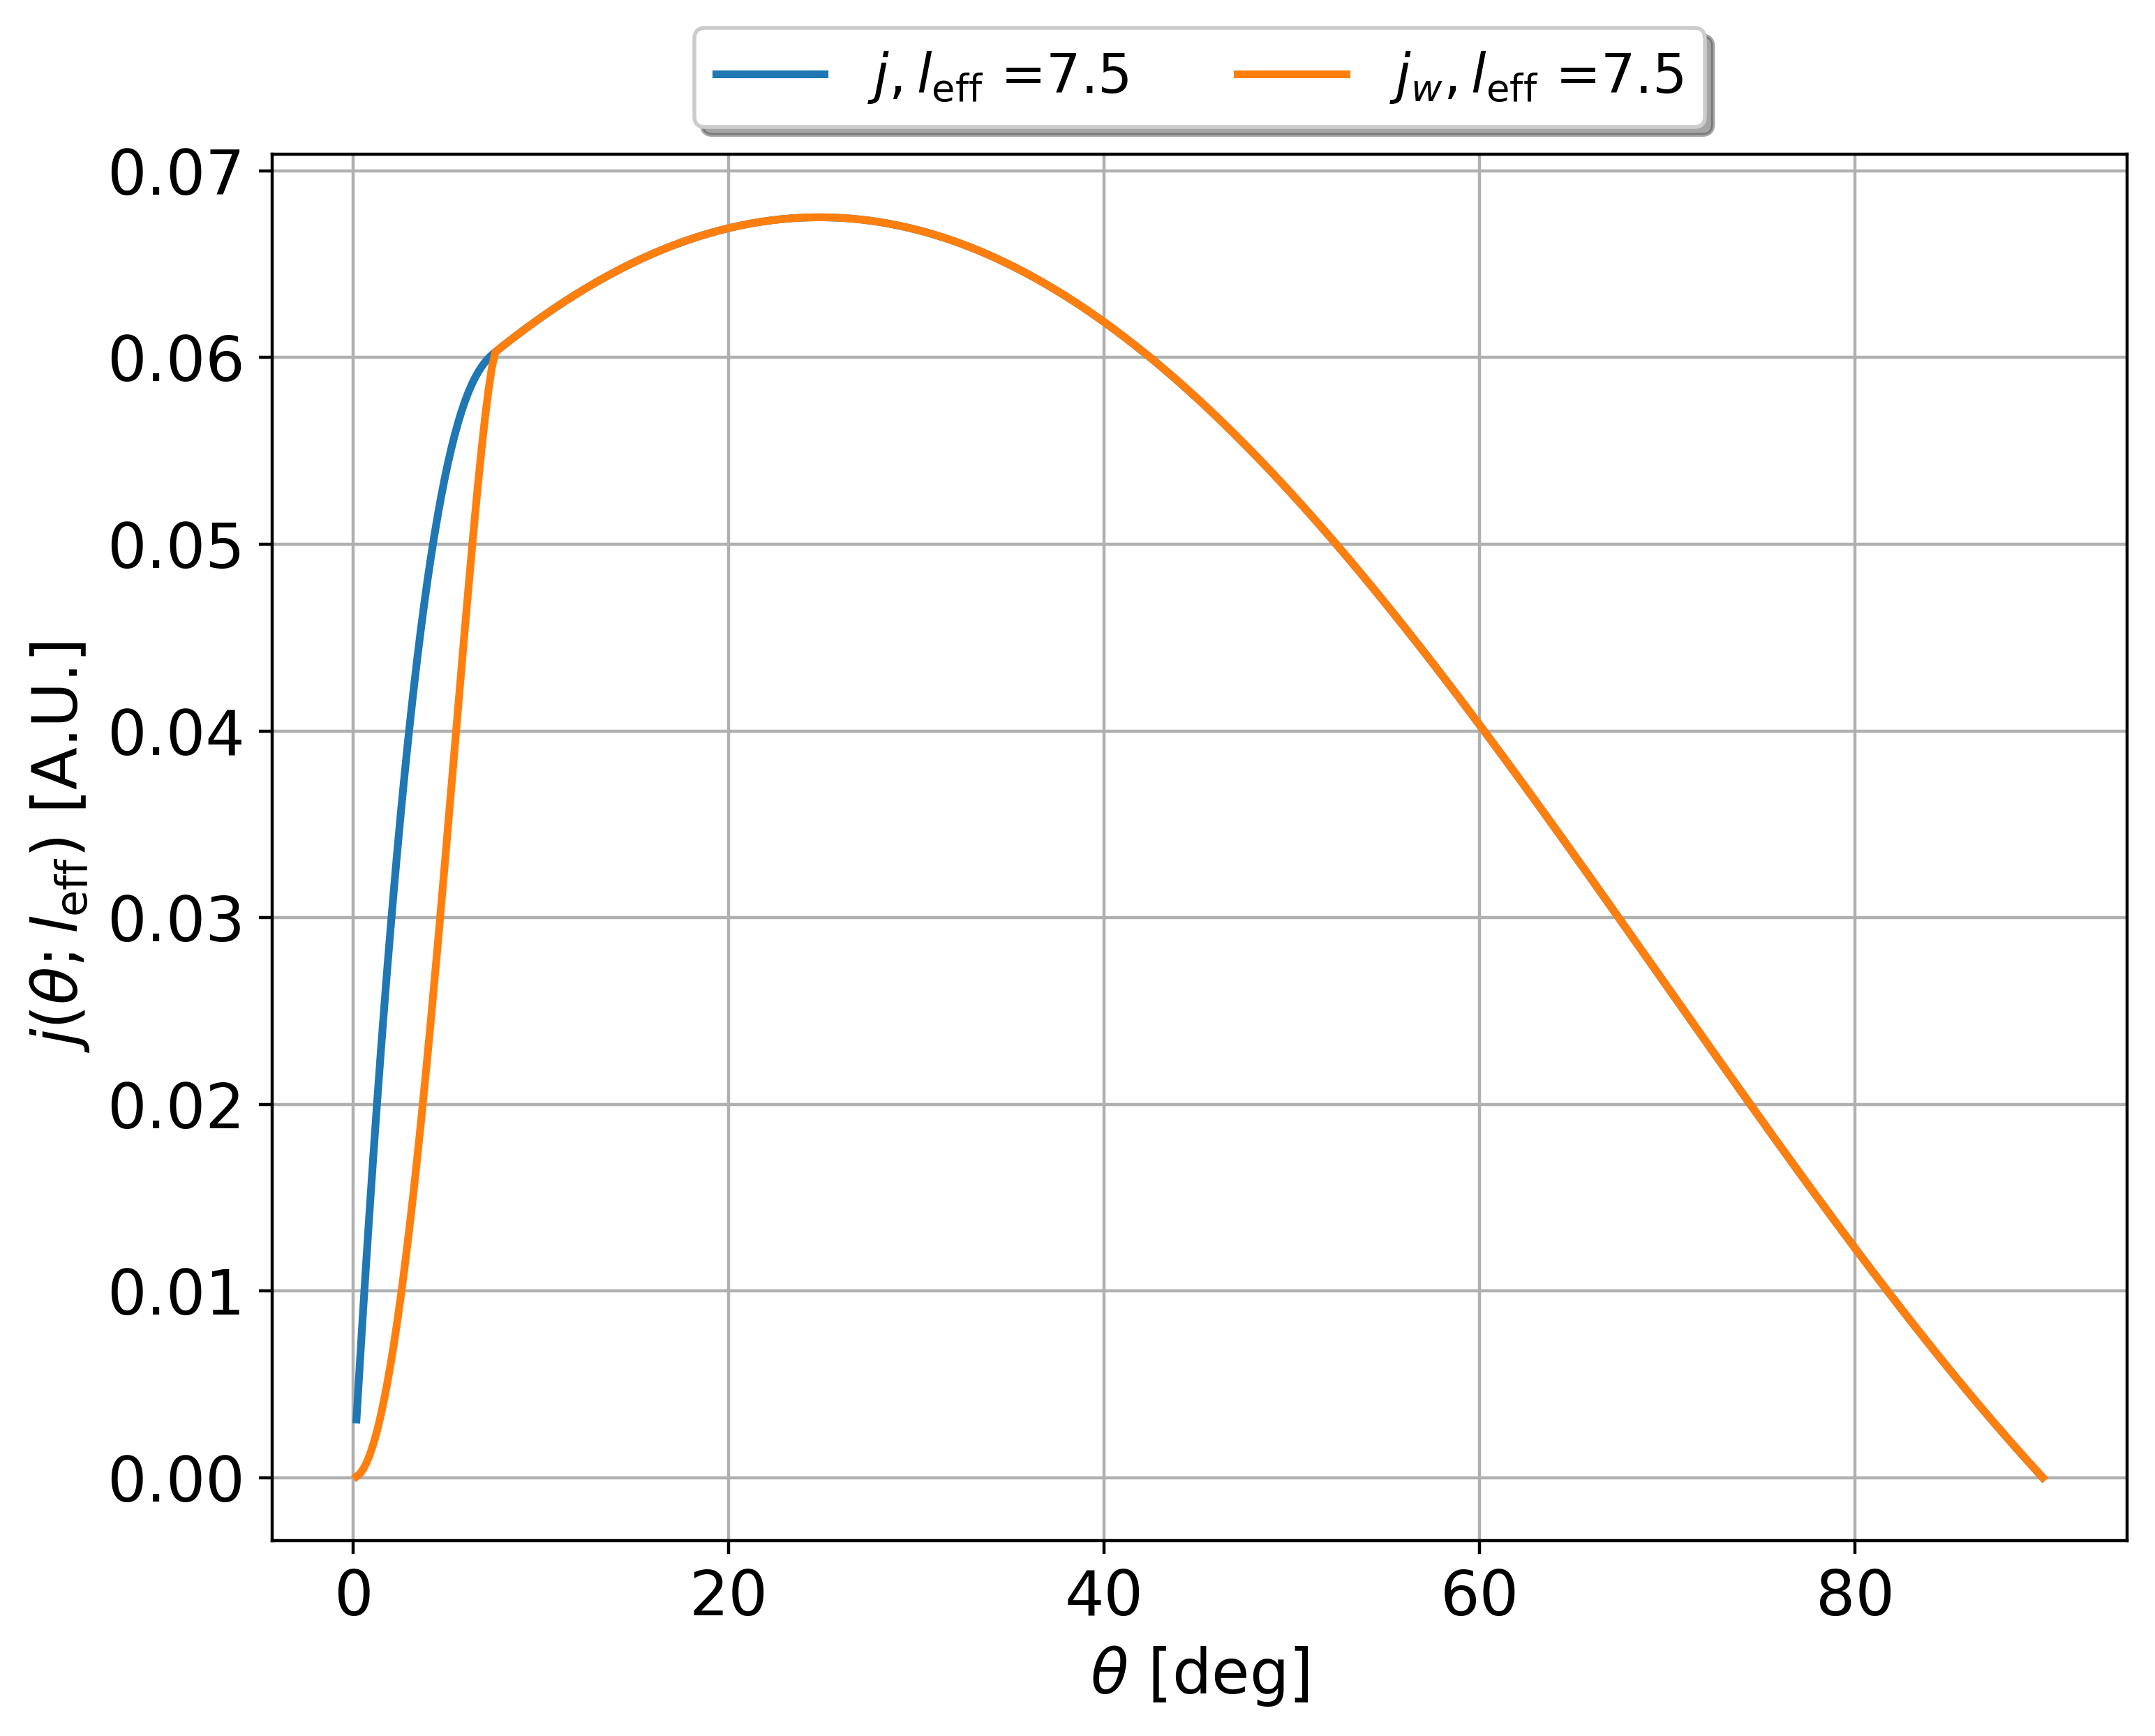

In [15]:
''' j and jw'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [np.sin(np.abs(x) * degree)*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys = [np.sin(np.abs(x) * degree)*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


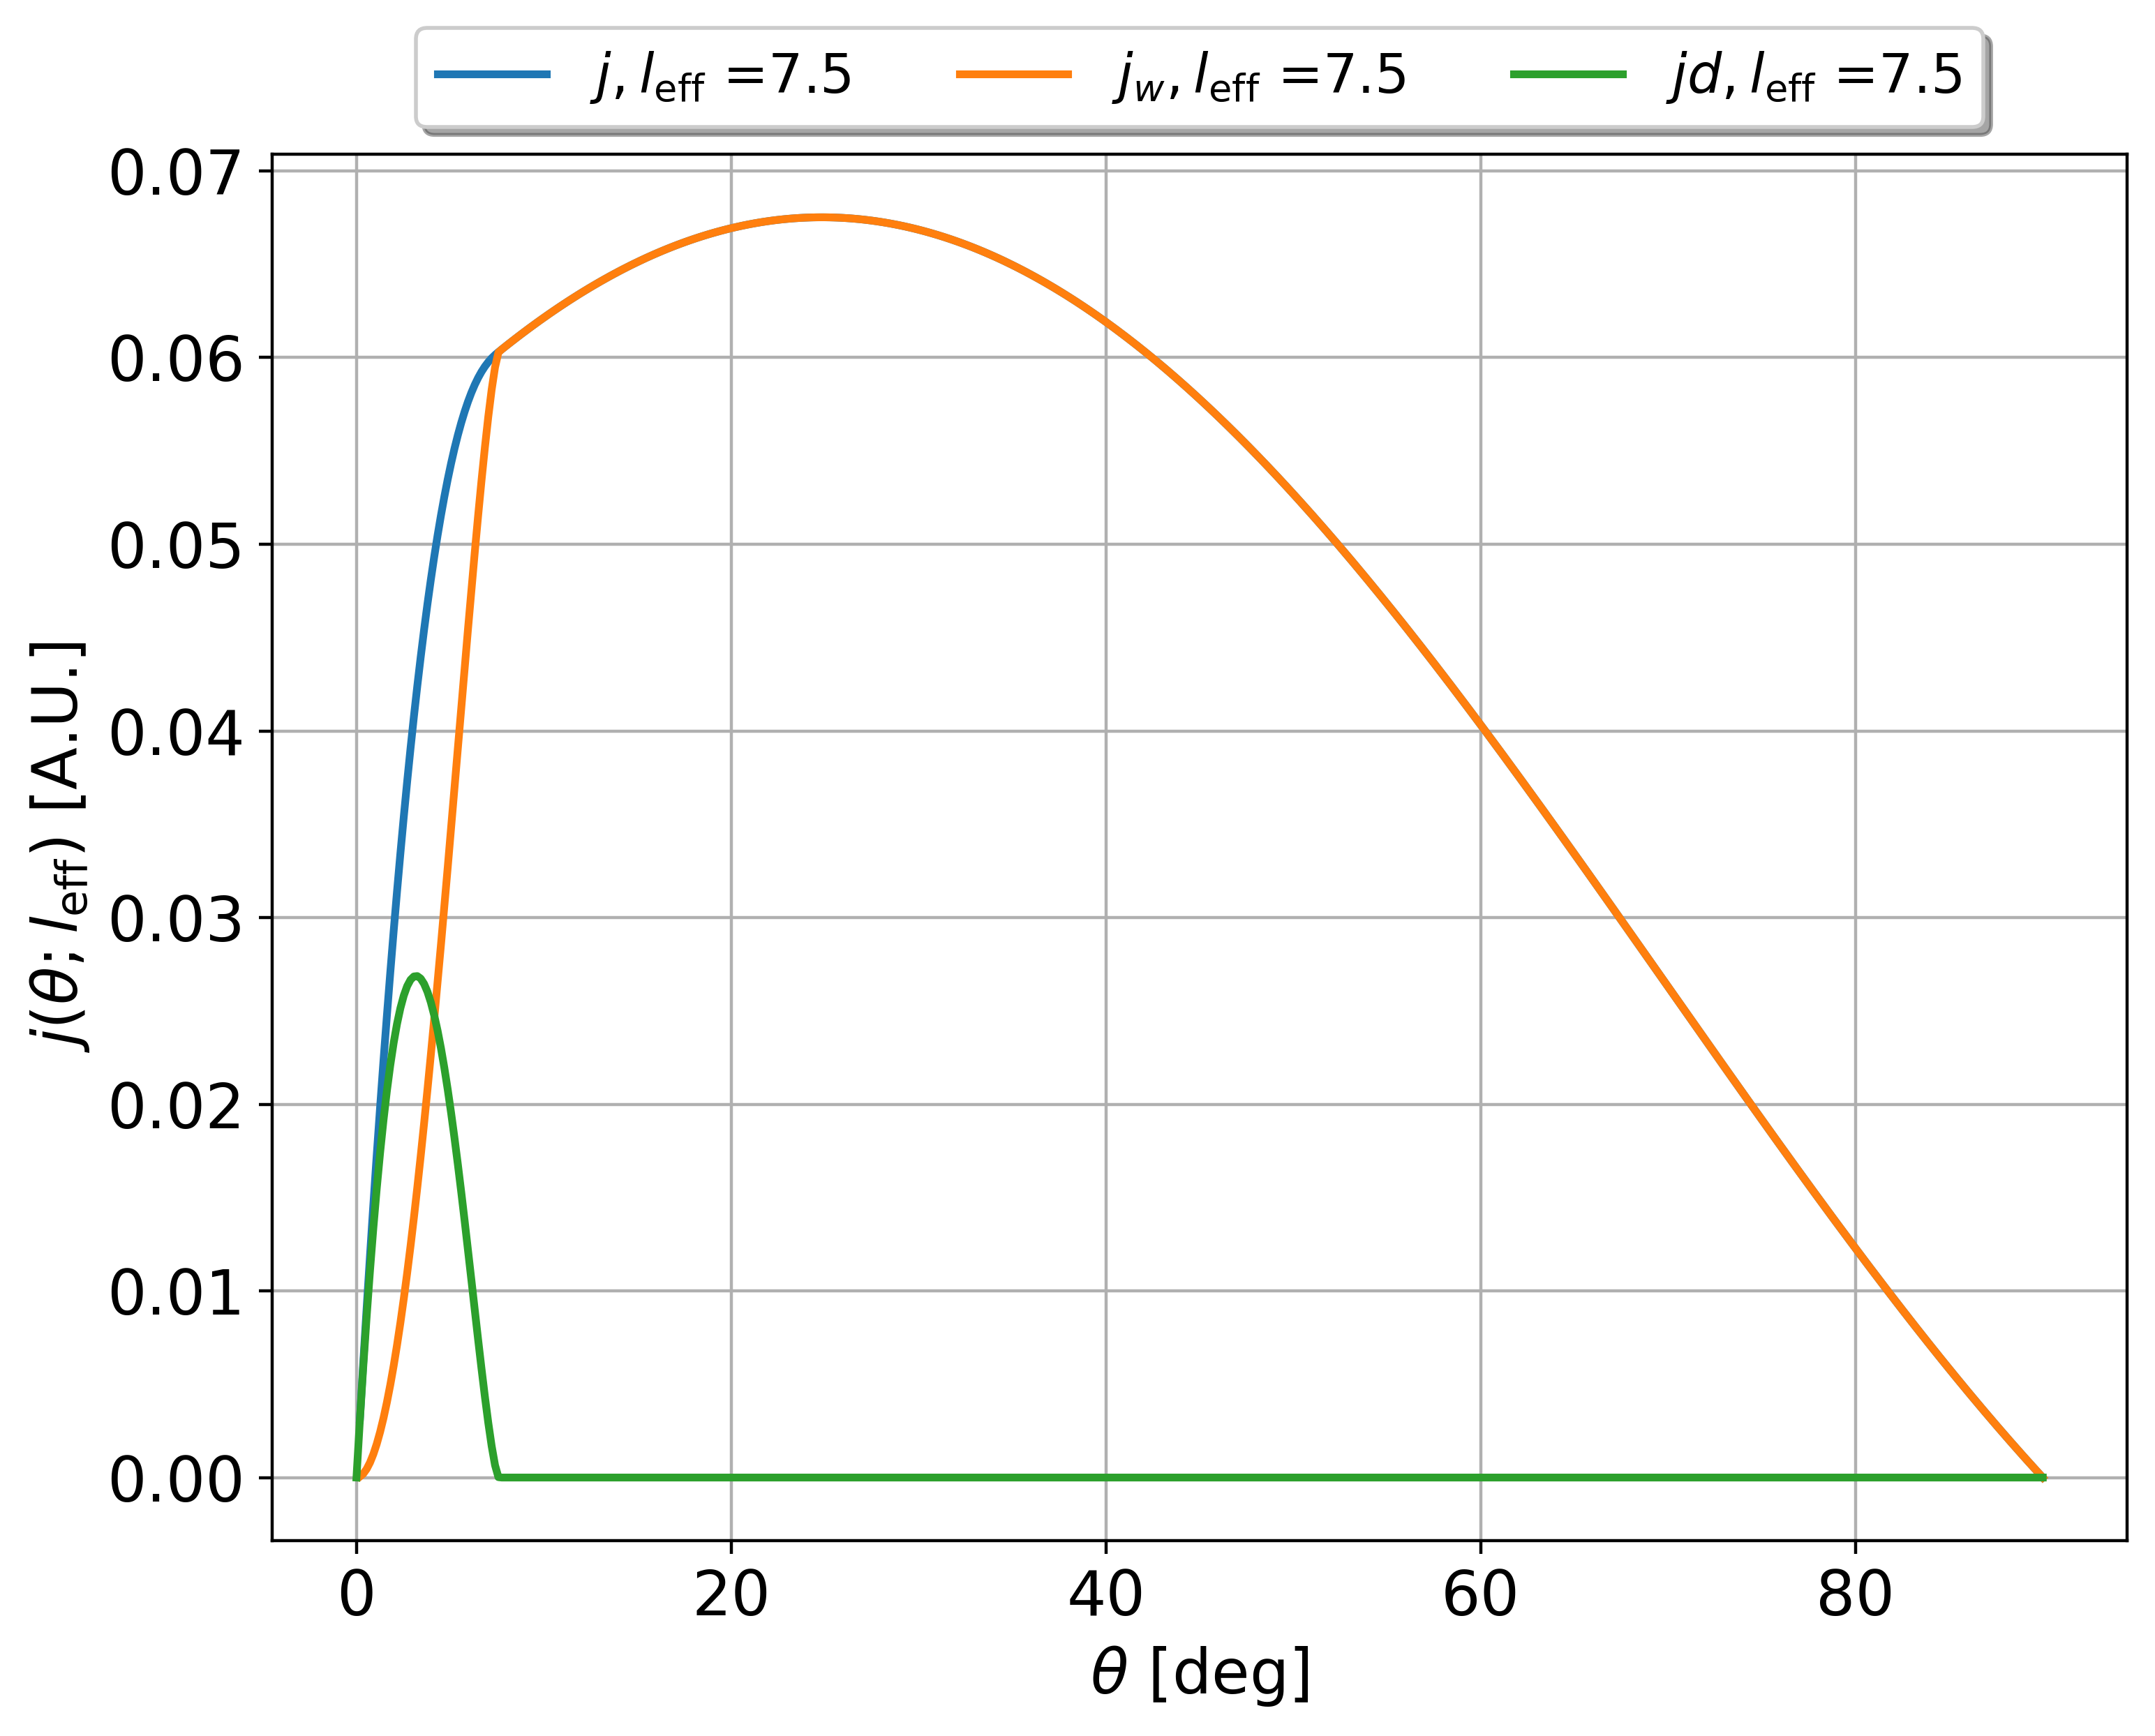

In [16]:
''' j and jw and  also jd'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [np.sin(np.abs(x) * degree)*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys_jd = [np.sin(np.abs(x) * degree)*jd(np.abs(x) * degree, l_eff = l_eff) 
        for x in xs]
    ys = [np.sin(np.abs(x) * degree)*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jd,
            color = "C2" ,
            label = r"$jd, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


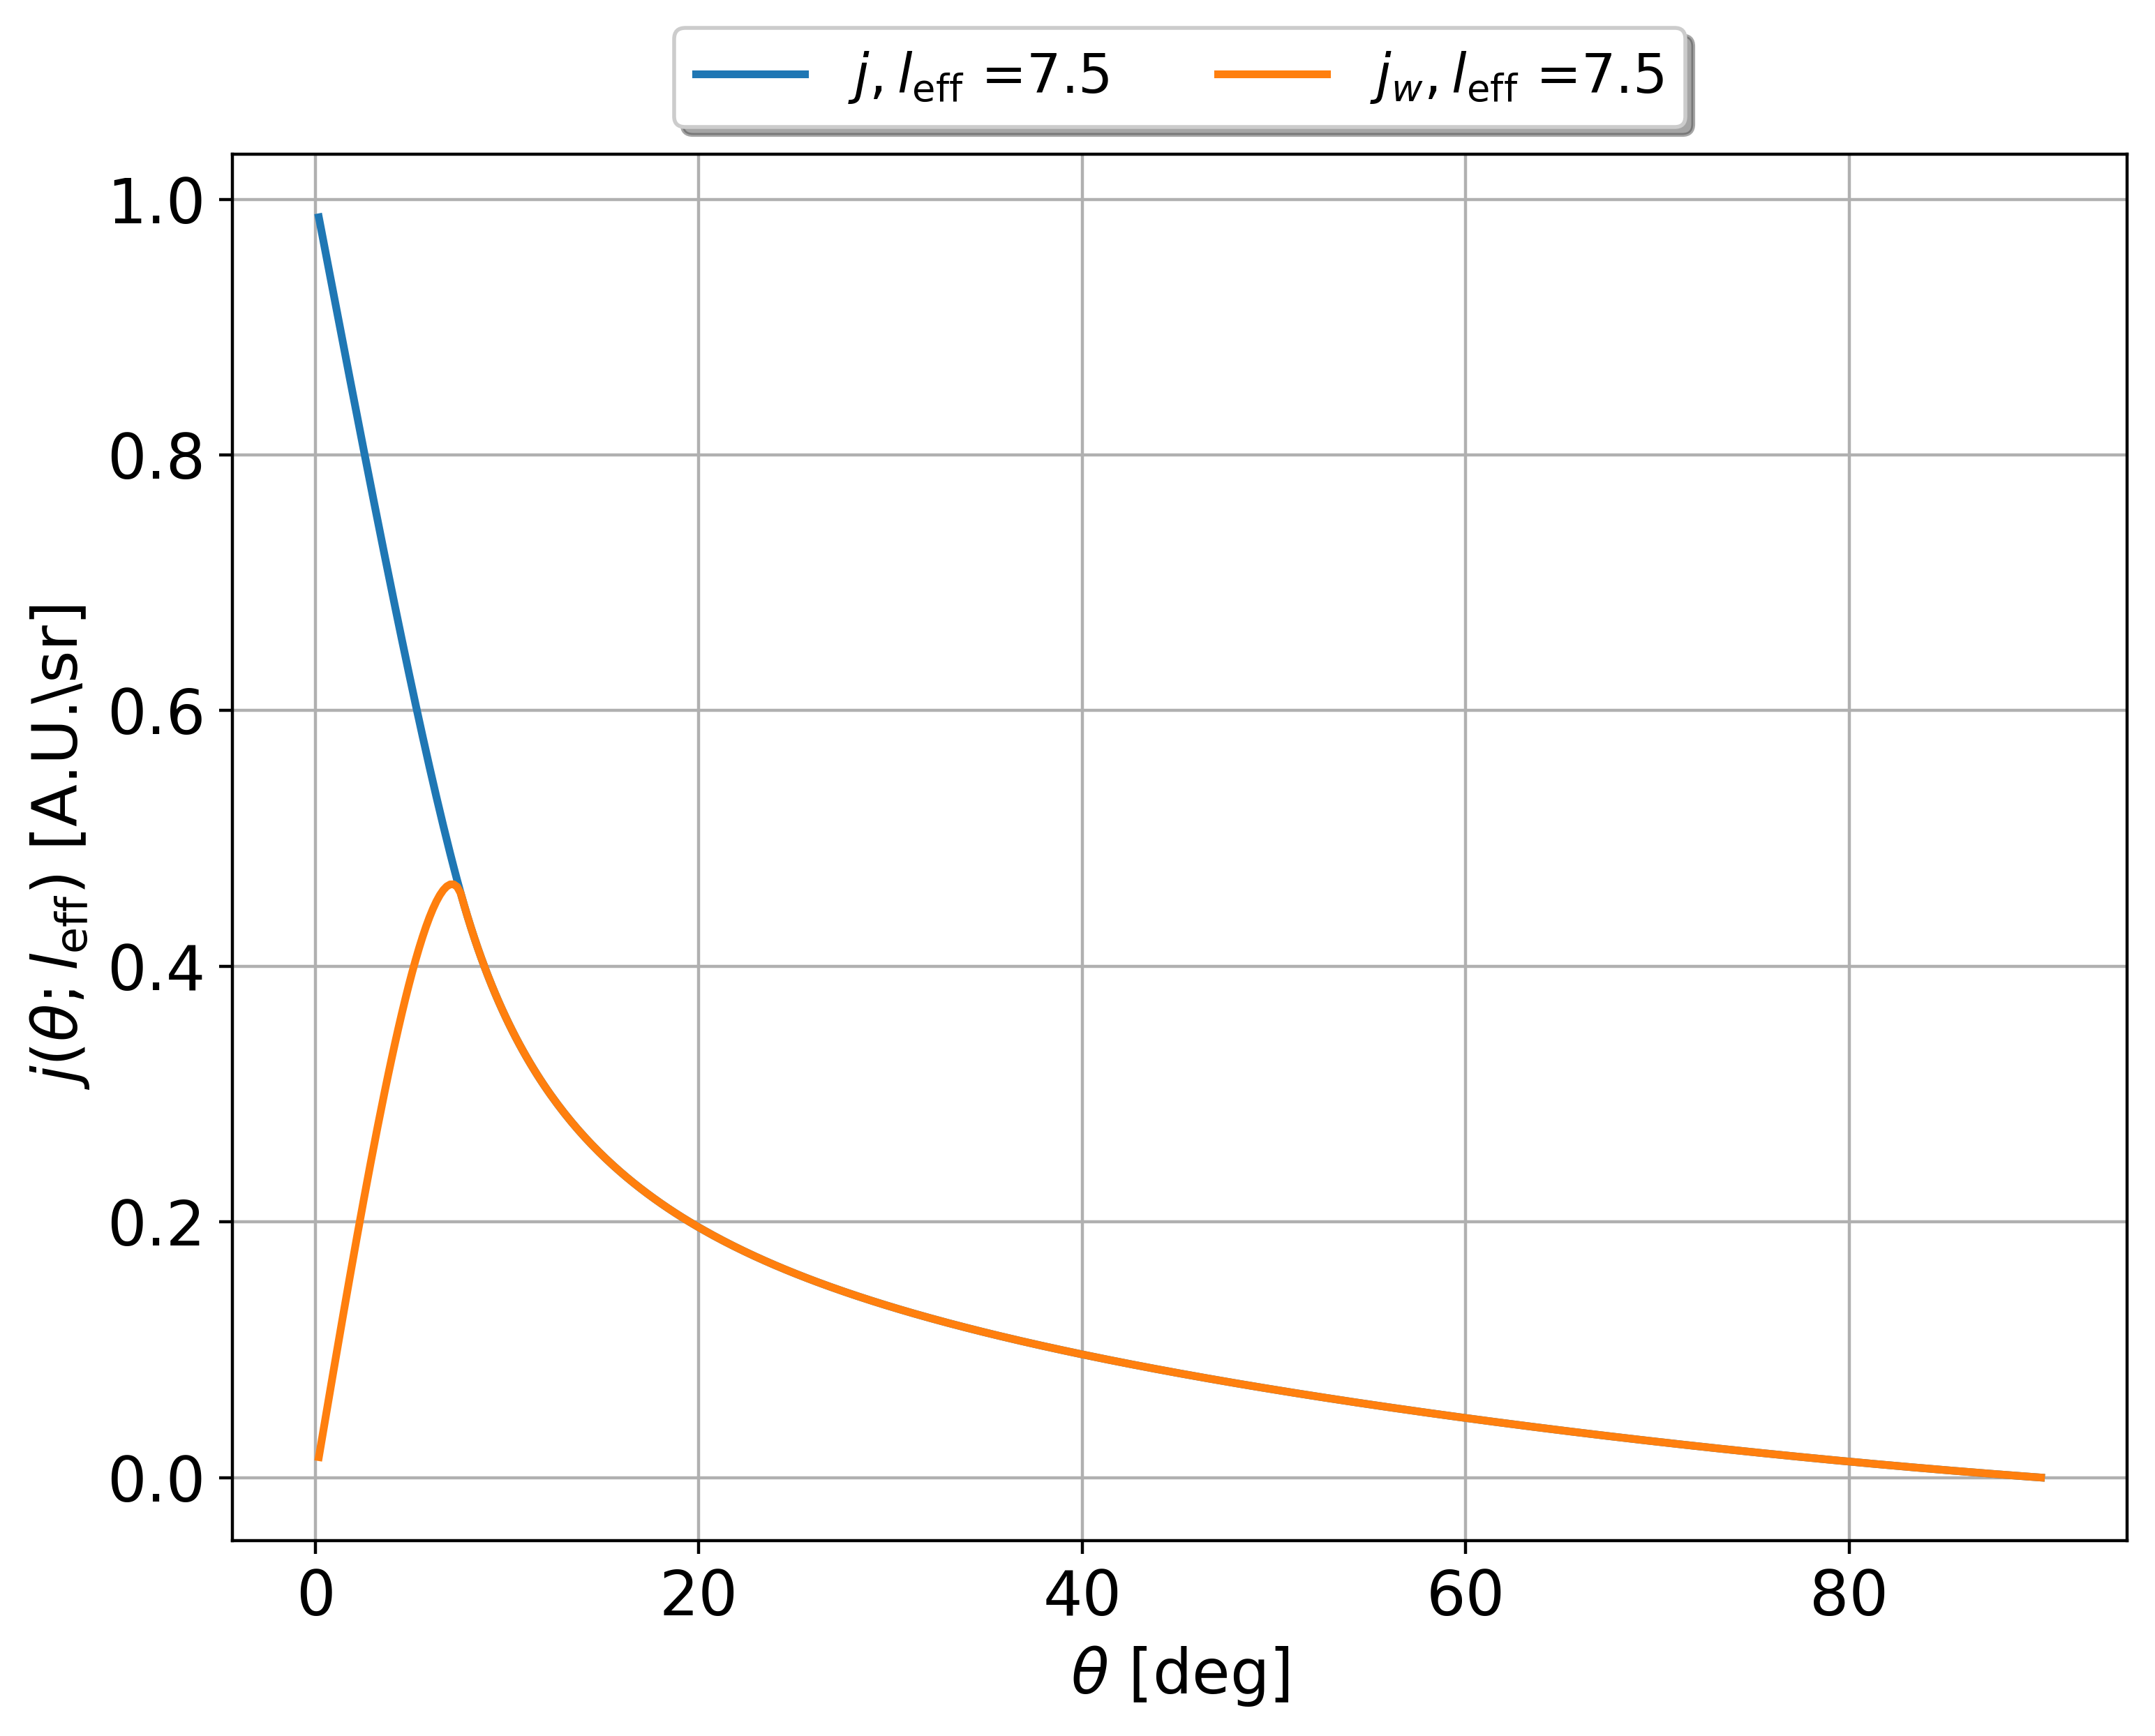

In [17]:
''' j and jw'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys = [jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


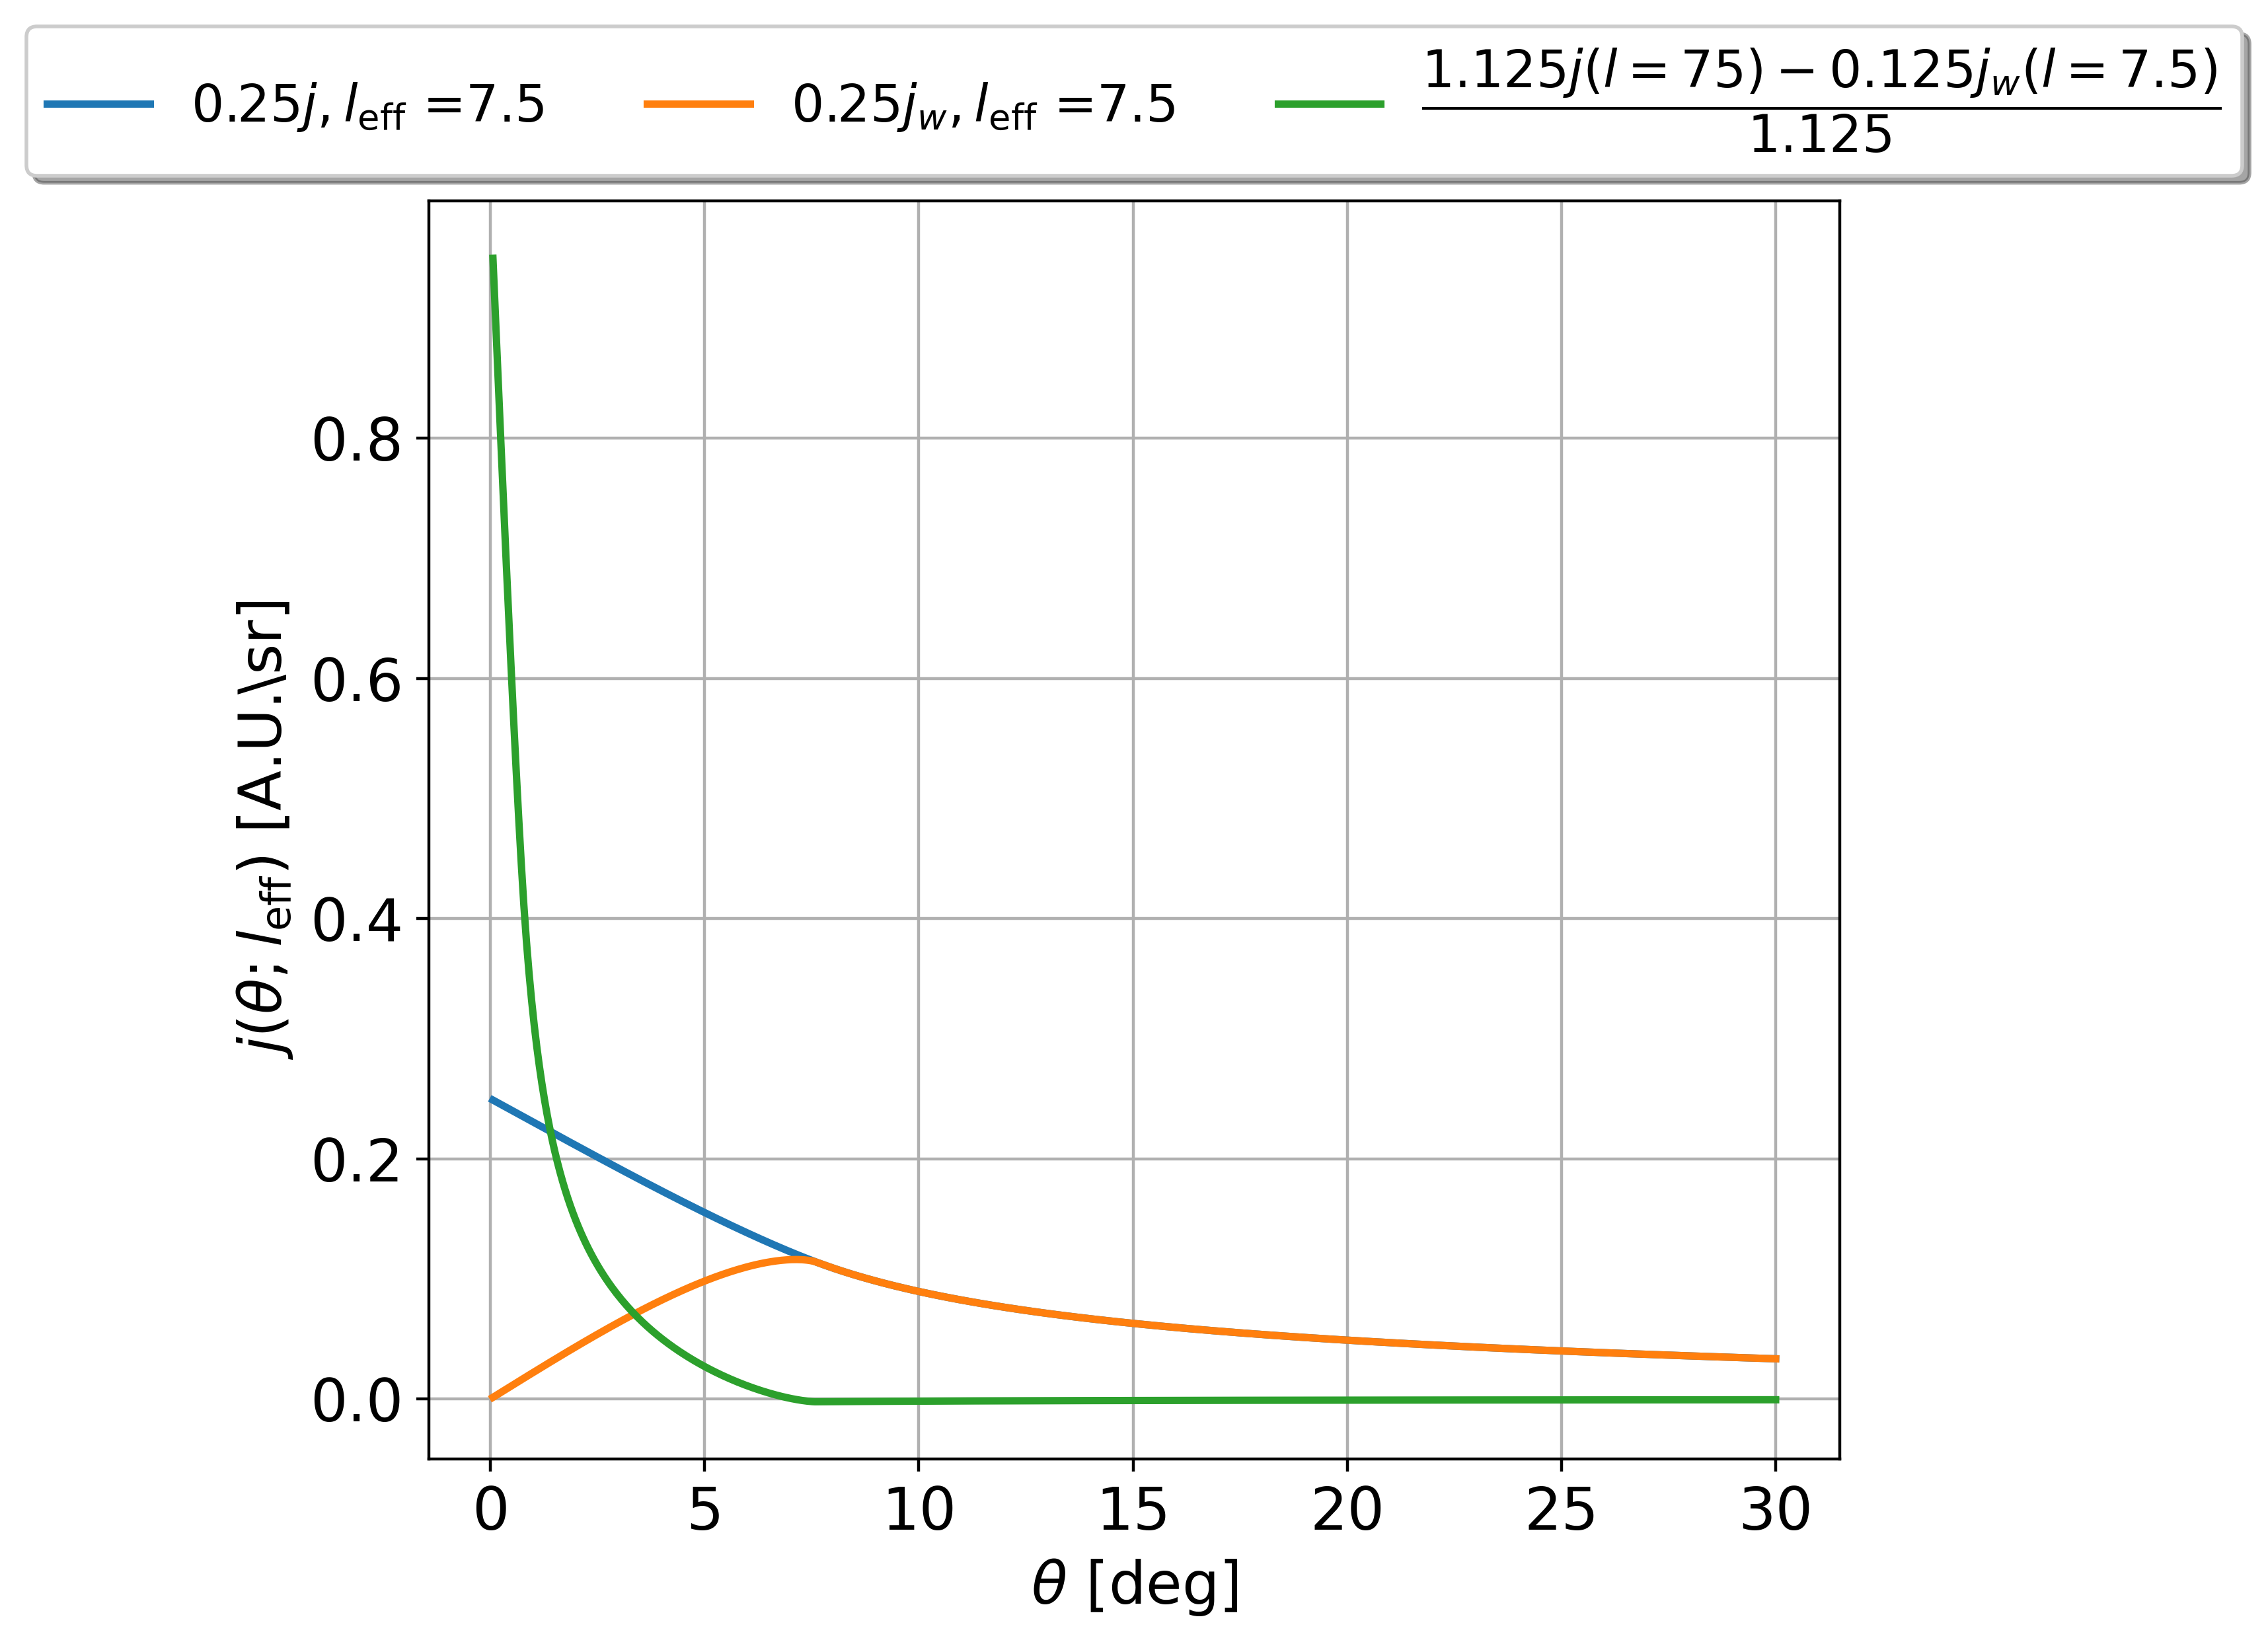

In [18]:
''' j and jw and jd 75'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,30, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [0.25*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys_jd = [(1/1.125)*(1.125*j(np.abs(x) * degree, l_eff = 75) - 
             0.125*jw(np.abs(x) * degree, l_eff = l_eff))
          for x in xs]
    ys = [0.25*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$0.25j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$0.25j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jd,
            color = "C2" ,
            label = r"$\dfrac{1.125j(l = 75) - 0.125j_w(l=7.5)}{1.125}}$",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


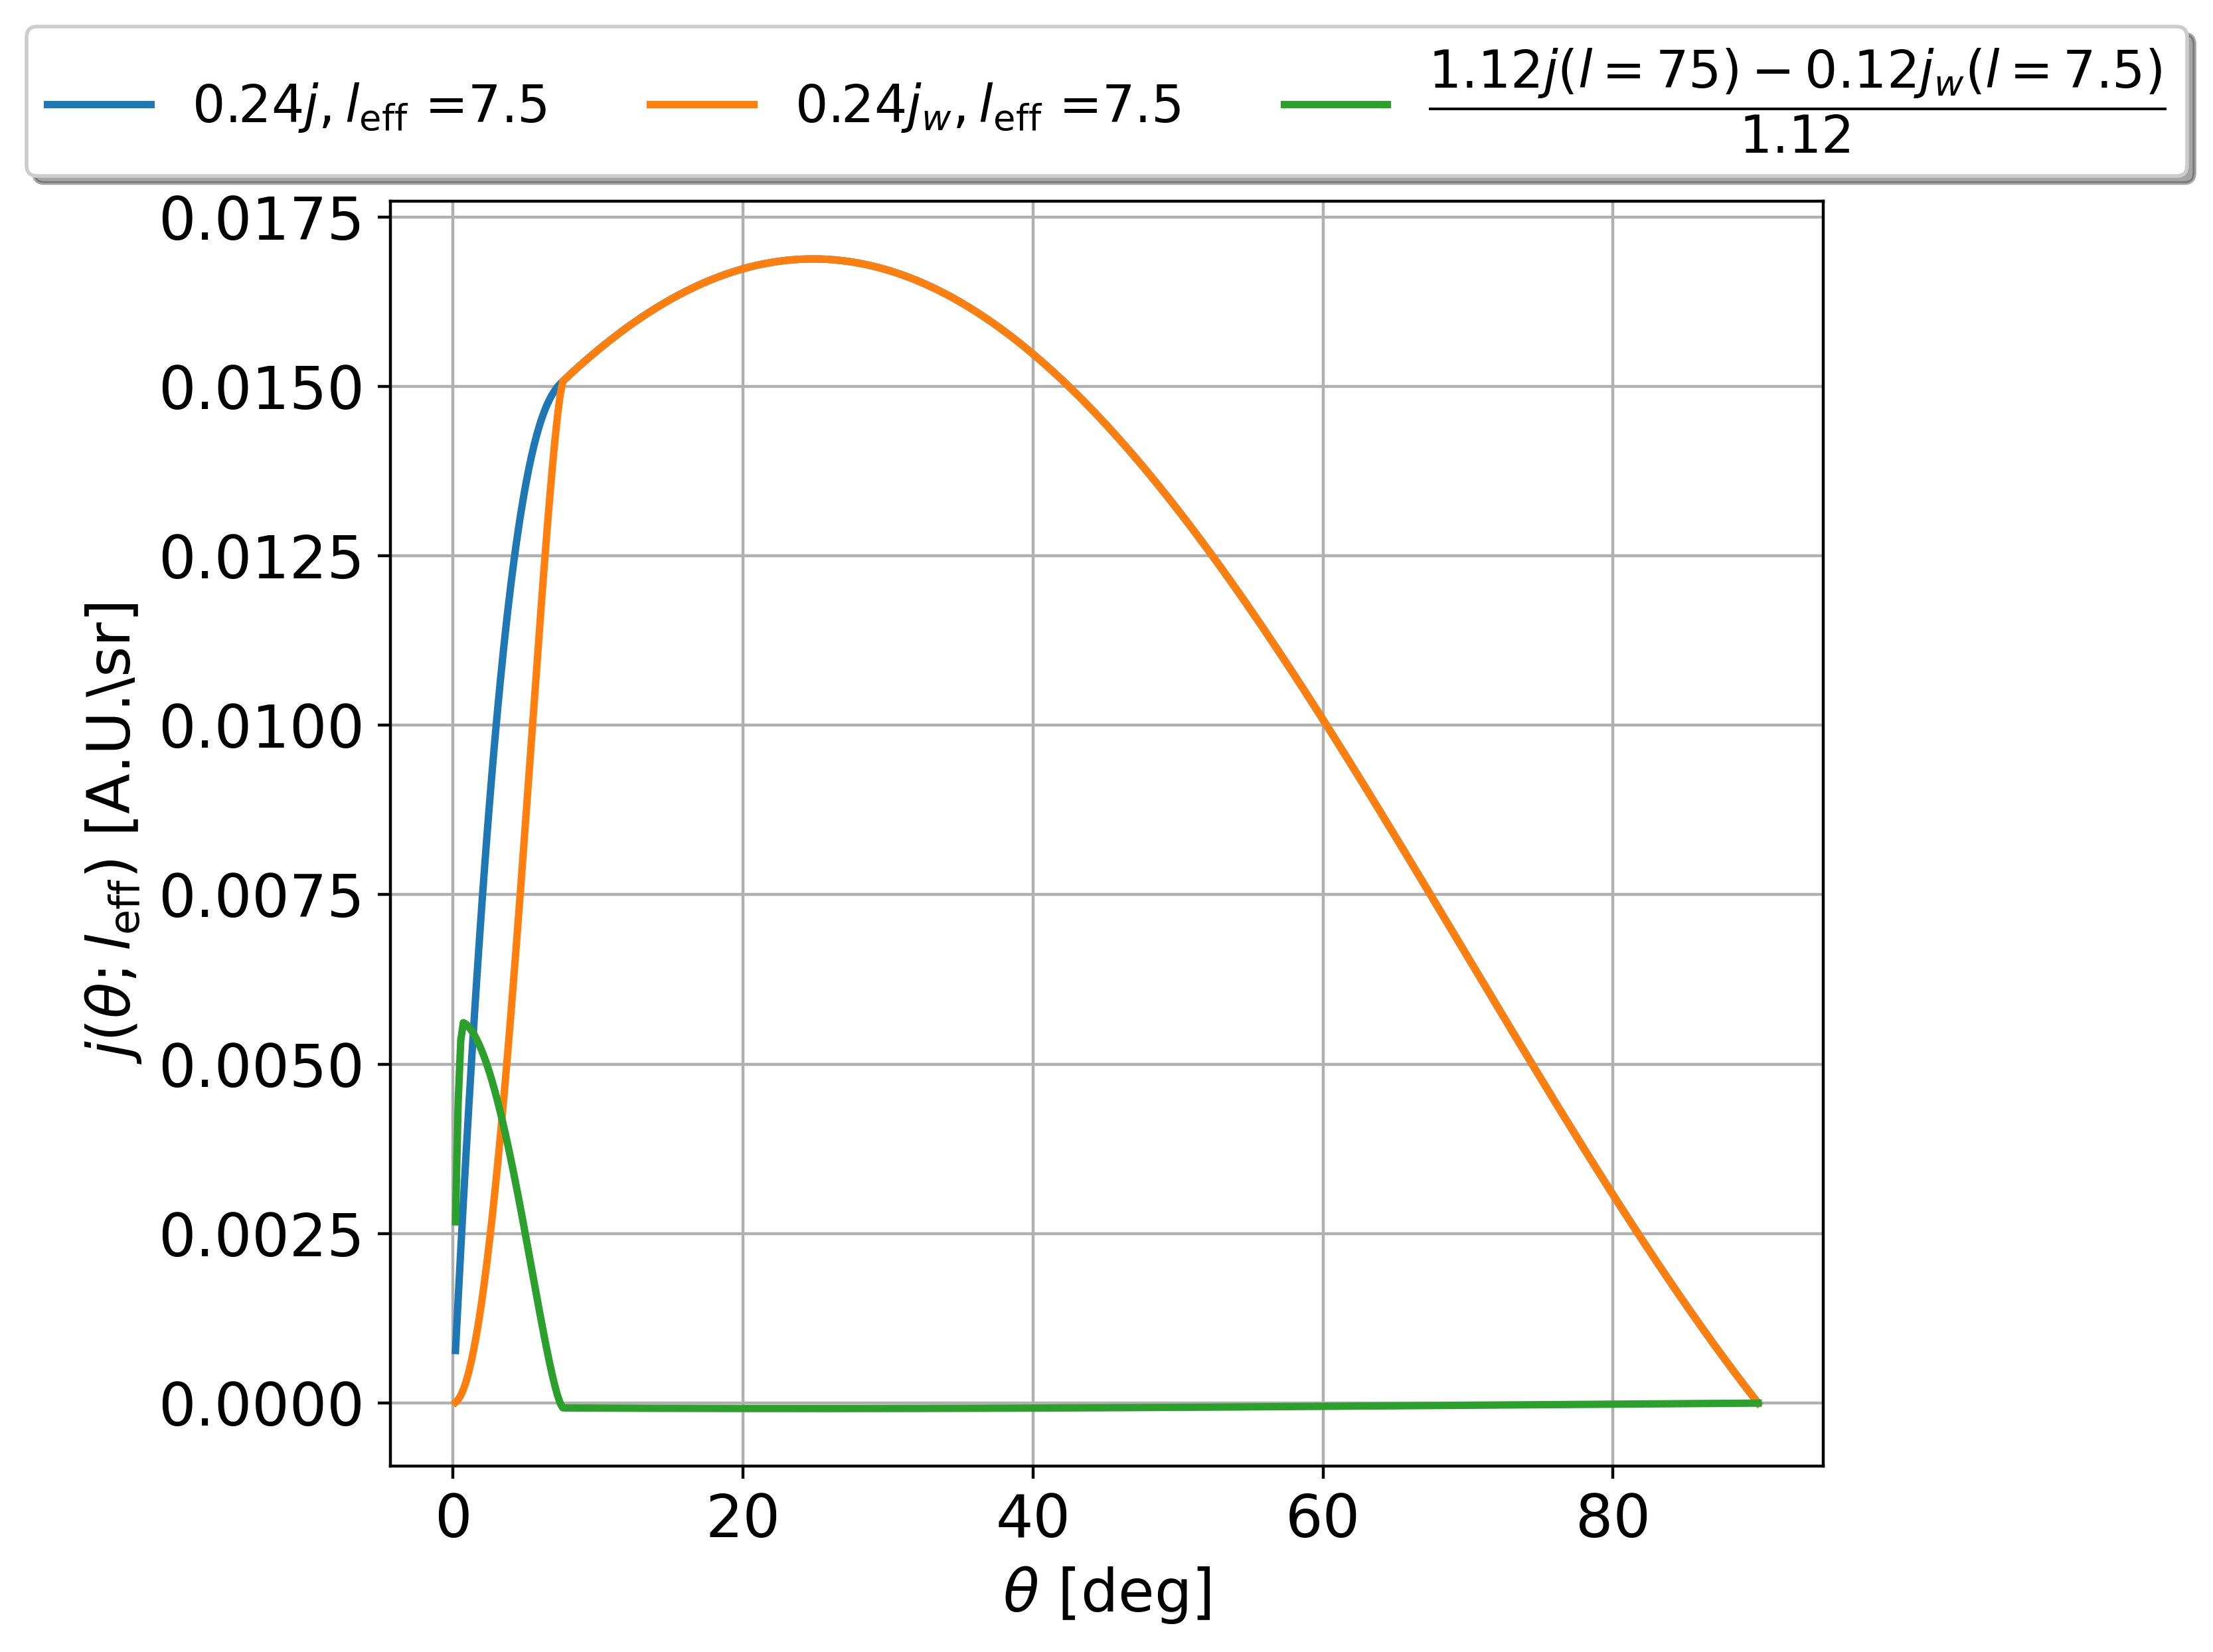

In [19]:
''' j and jw and jd 75 integrated sin(theta)'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,90, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [np.sin(np.abs(x) * degree)*
            0.25*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys_jd = [np.sin(np.abs(x) * degree)*
             (1/1.12)*(1.12*j(np.abs(x) * degree, l_eff = 75) - 
             0.12*jw(np.abs(x) * degree, l_eff = l_eff))
          for x in xs]
    ys = [np.sin(np.abs(x) * degree)*
          0.25*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$0.24j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$0.24j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jd,
            color = "C2" ,
            label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


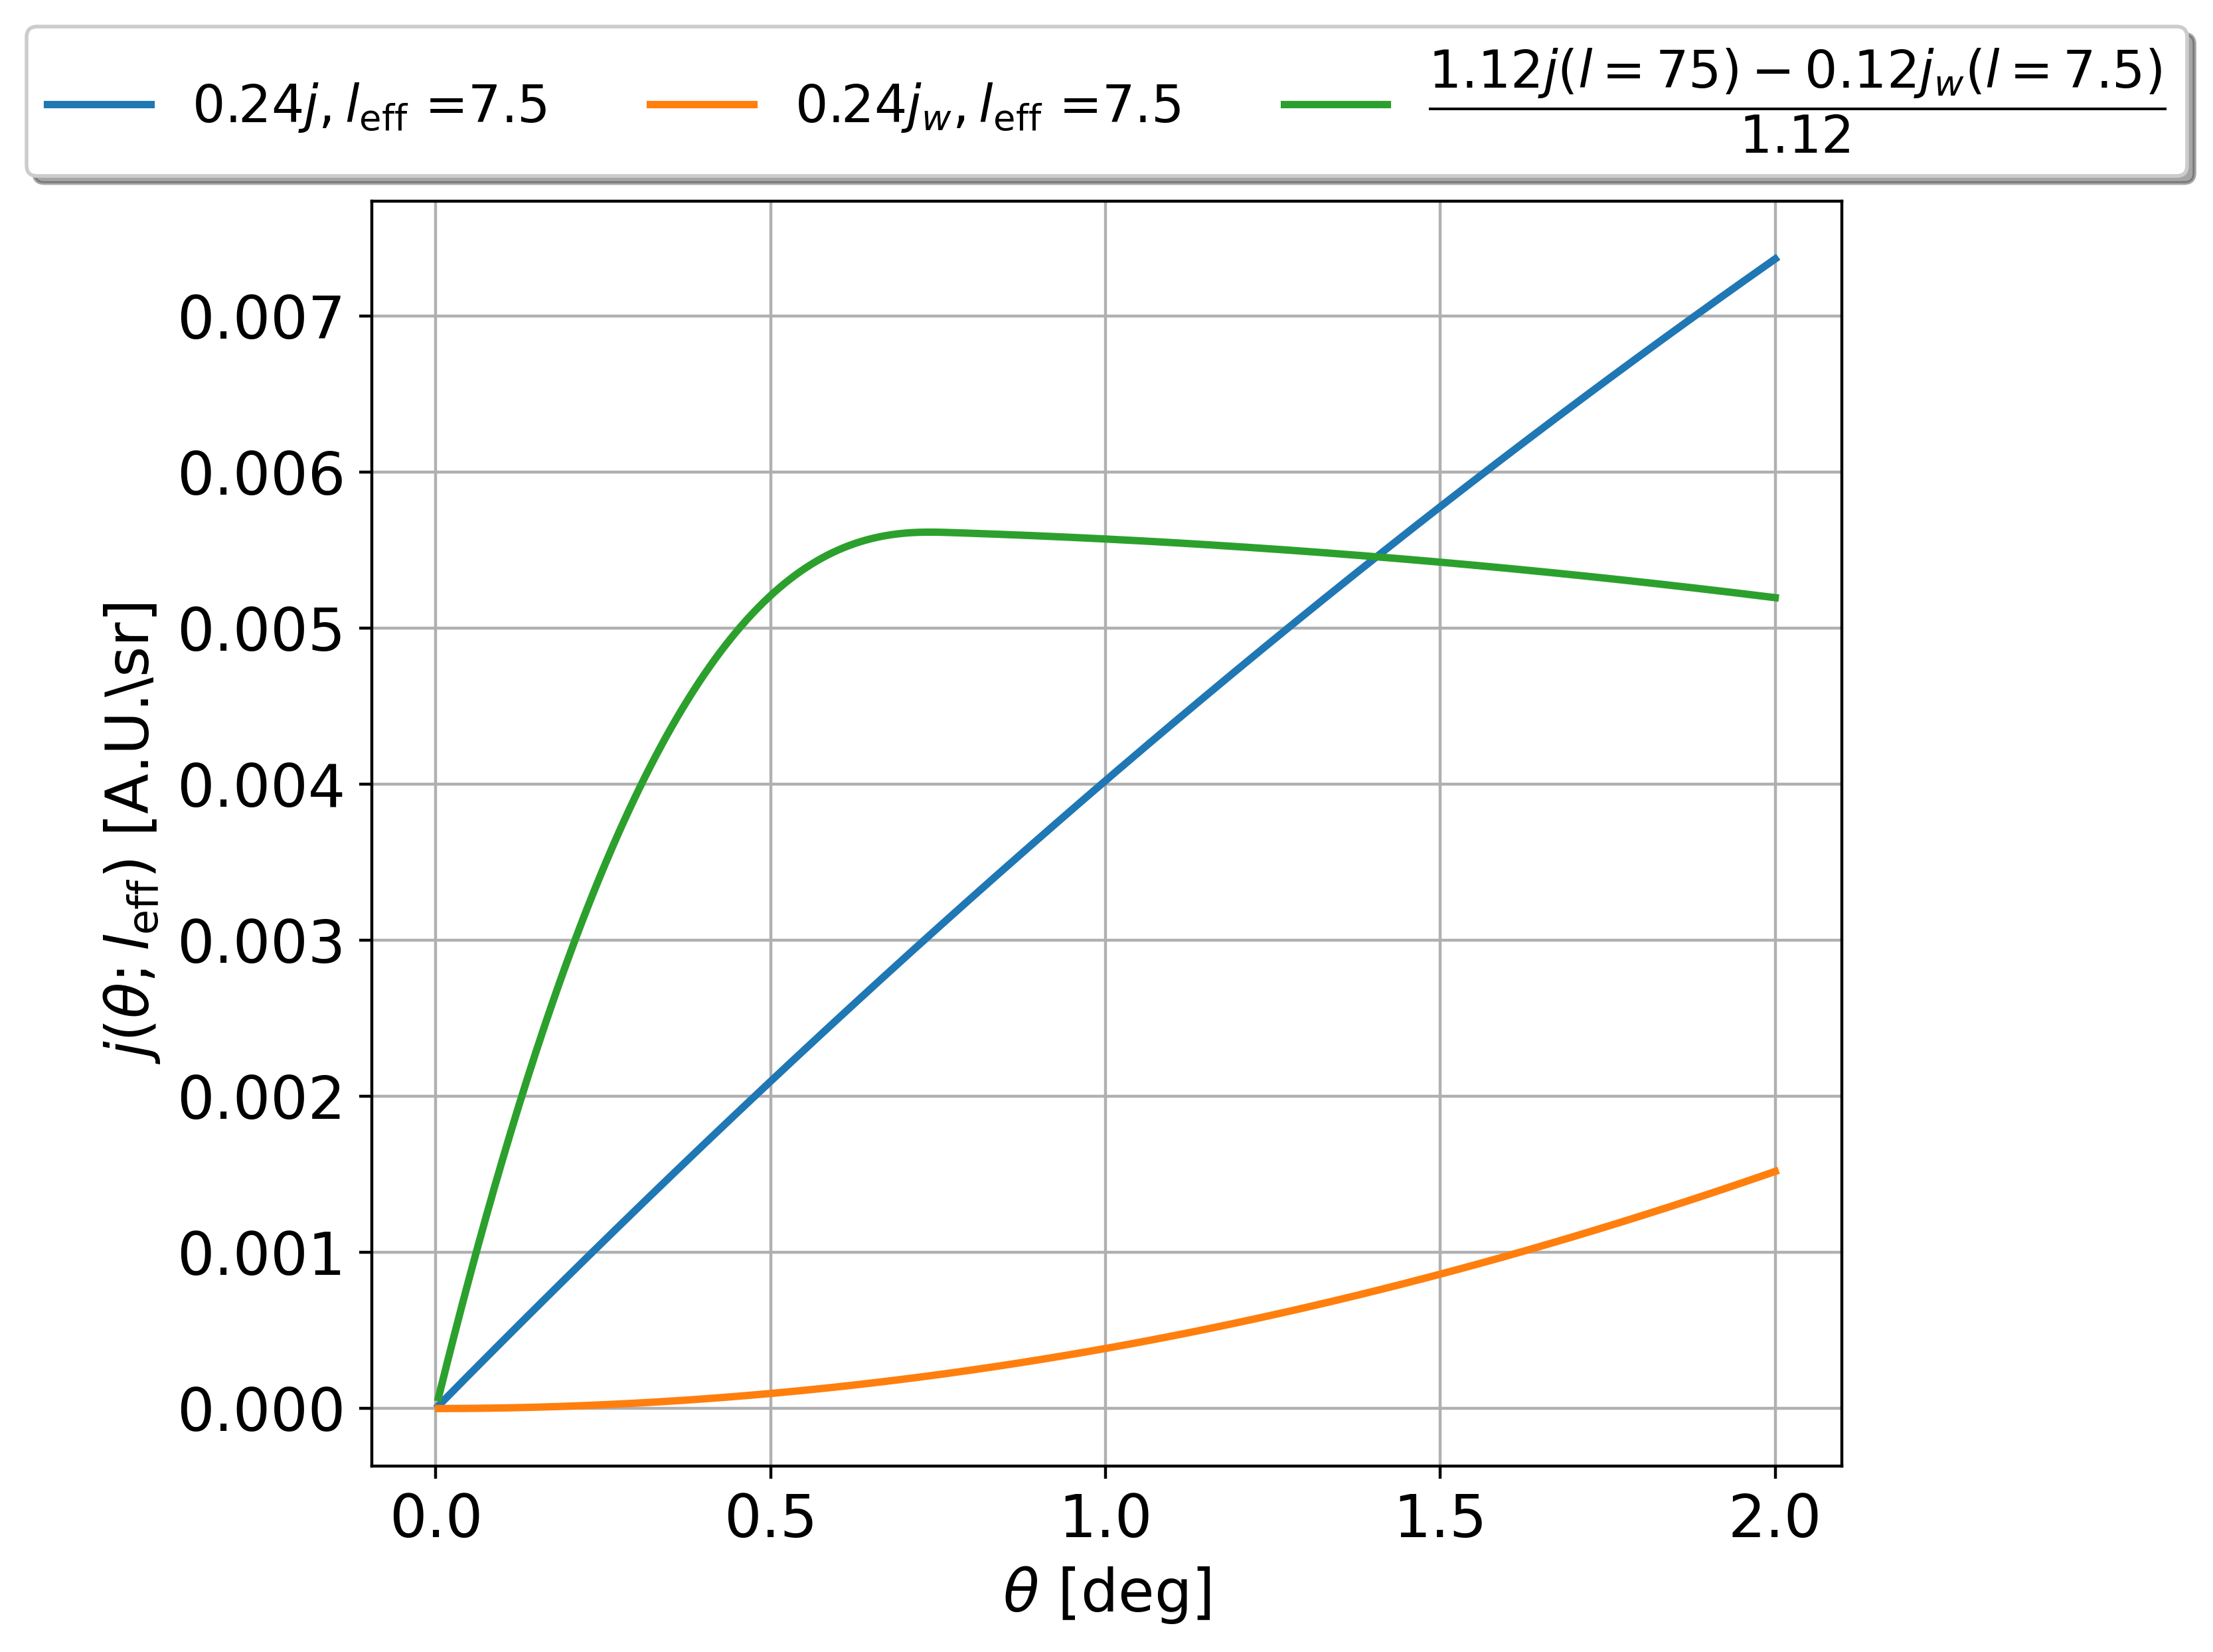

In [20]:
''' j and jw and jd 75 integrated sin(theta)'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,2, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [np.sin(np.abs(x) * degree)*
            0.25*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys_jd = [np.sin(np.abs(x) * degree)*
             (1/1.12)*(1.12*j(np.abs(x) * degree, l_eff = 75) - 
             0.12*jw(np.abs(x) * degree, l_eff = l_eff))
          for x in xs]
    ys = [np.sin(np.abs(x) * degree)*
          0.25*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$0.24j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$0.24j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jd,
            color = "C2" ,
            label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


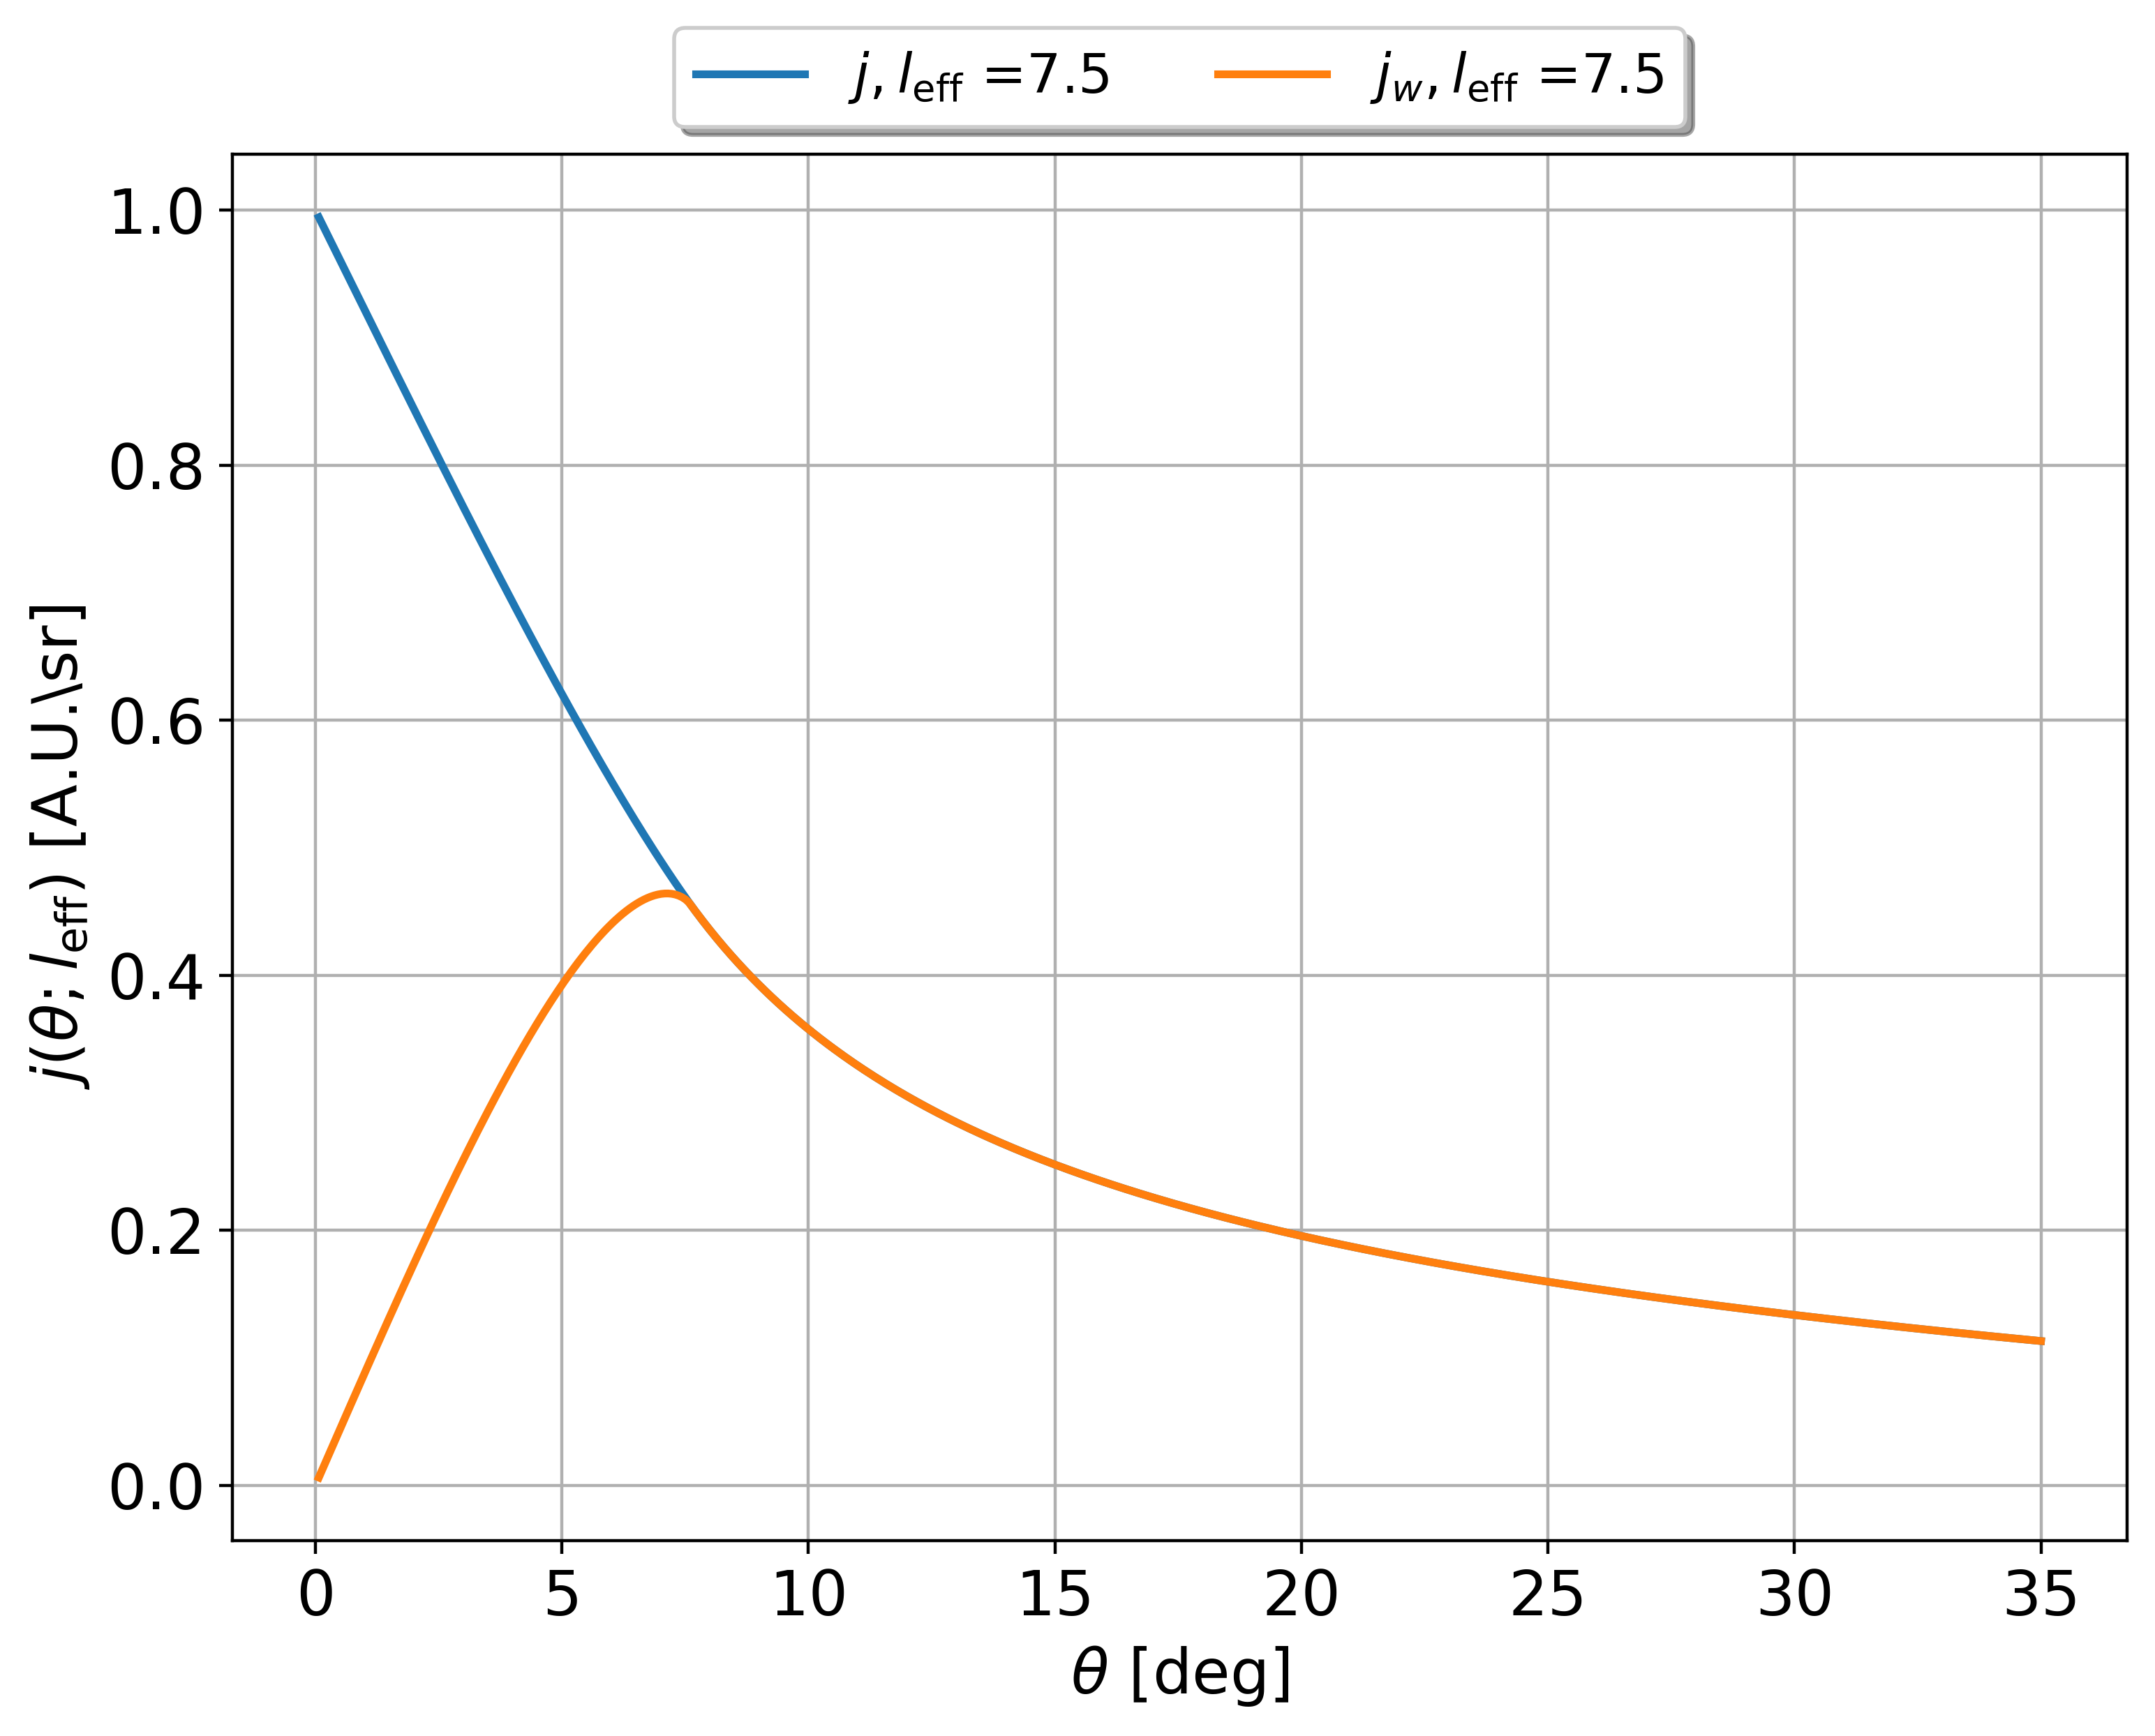

In [21]:
''' j and jw '''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,35, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys = [jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


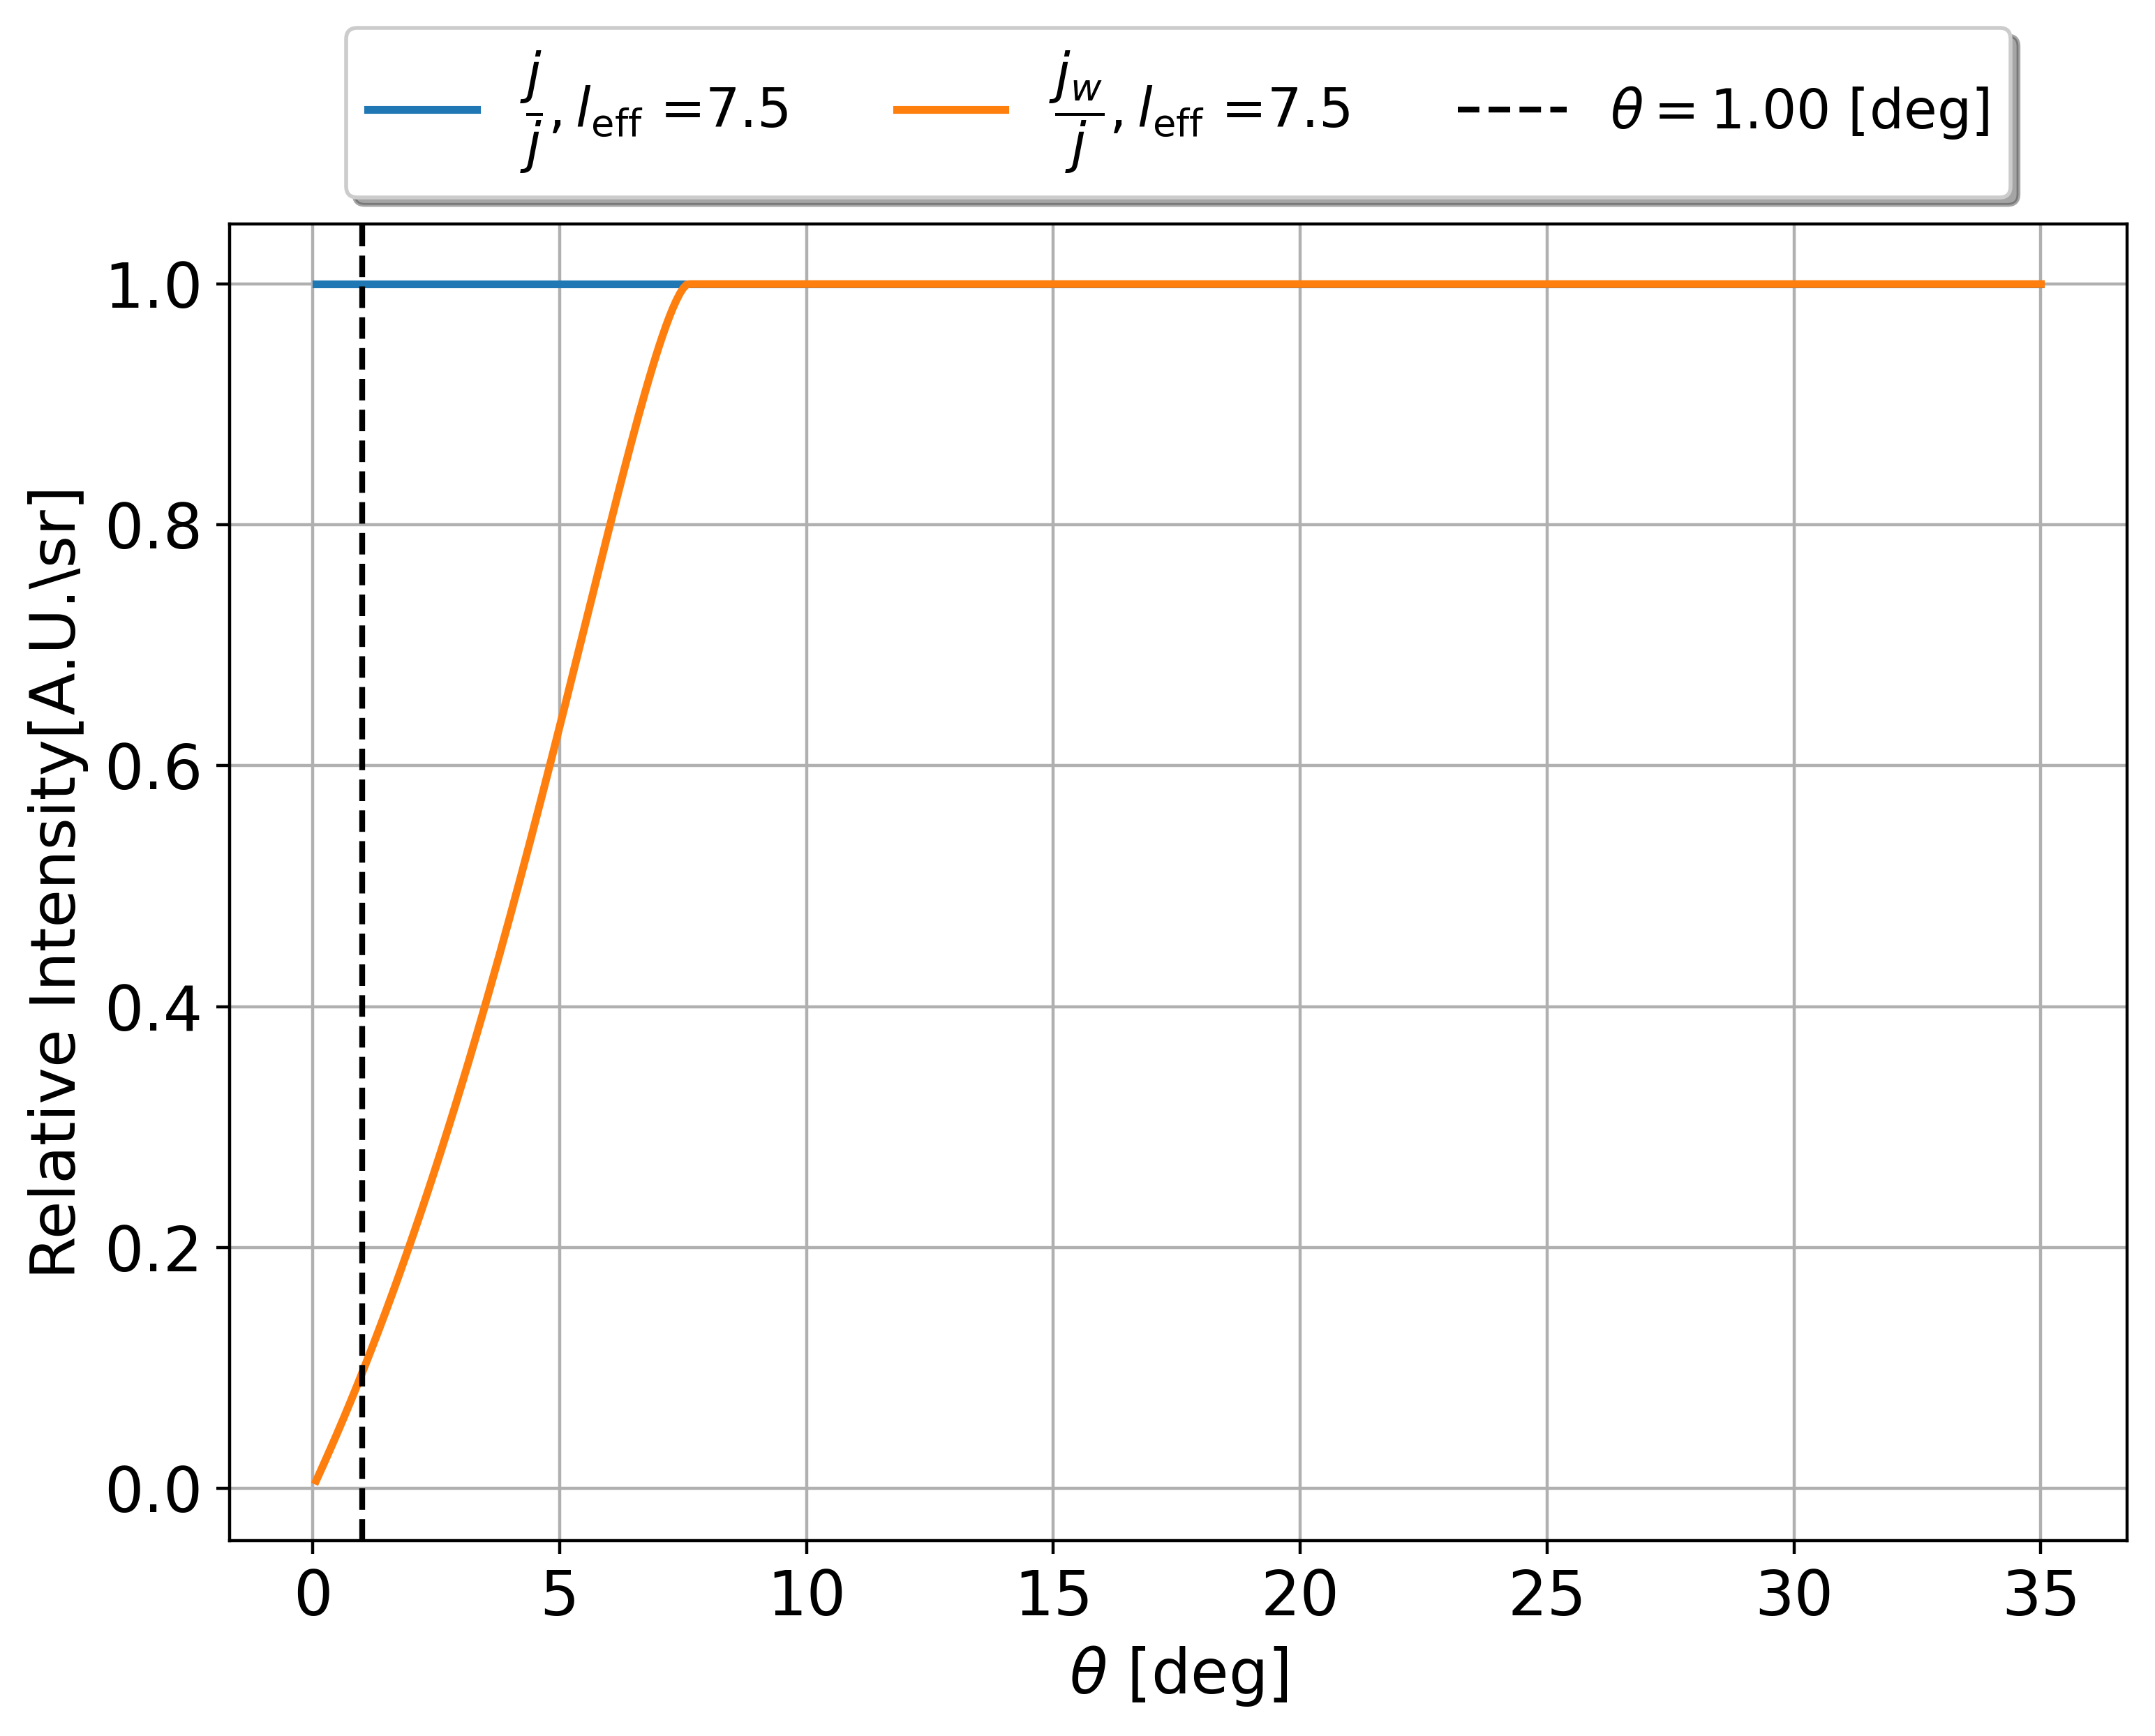

In [22]:
''' jw /j'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0,35, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = np.array([j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs])
    ys = np.array([jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs])

    ax1.plot(xs,ys_j/ys_j,
            color = "C0" ,
            label = r"$\dfrac{j}{j}, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys/ys_j,
            color = "C1" ,
            label = r"$\dfrac{j_w}{j}, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(1, label=r"$\theta = $"
        + f"{1:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Relative Intensity[A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

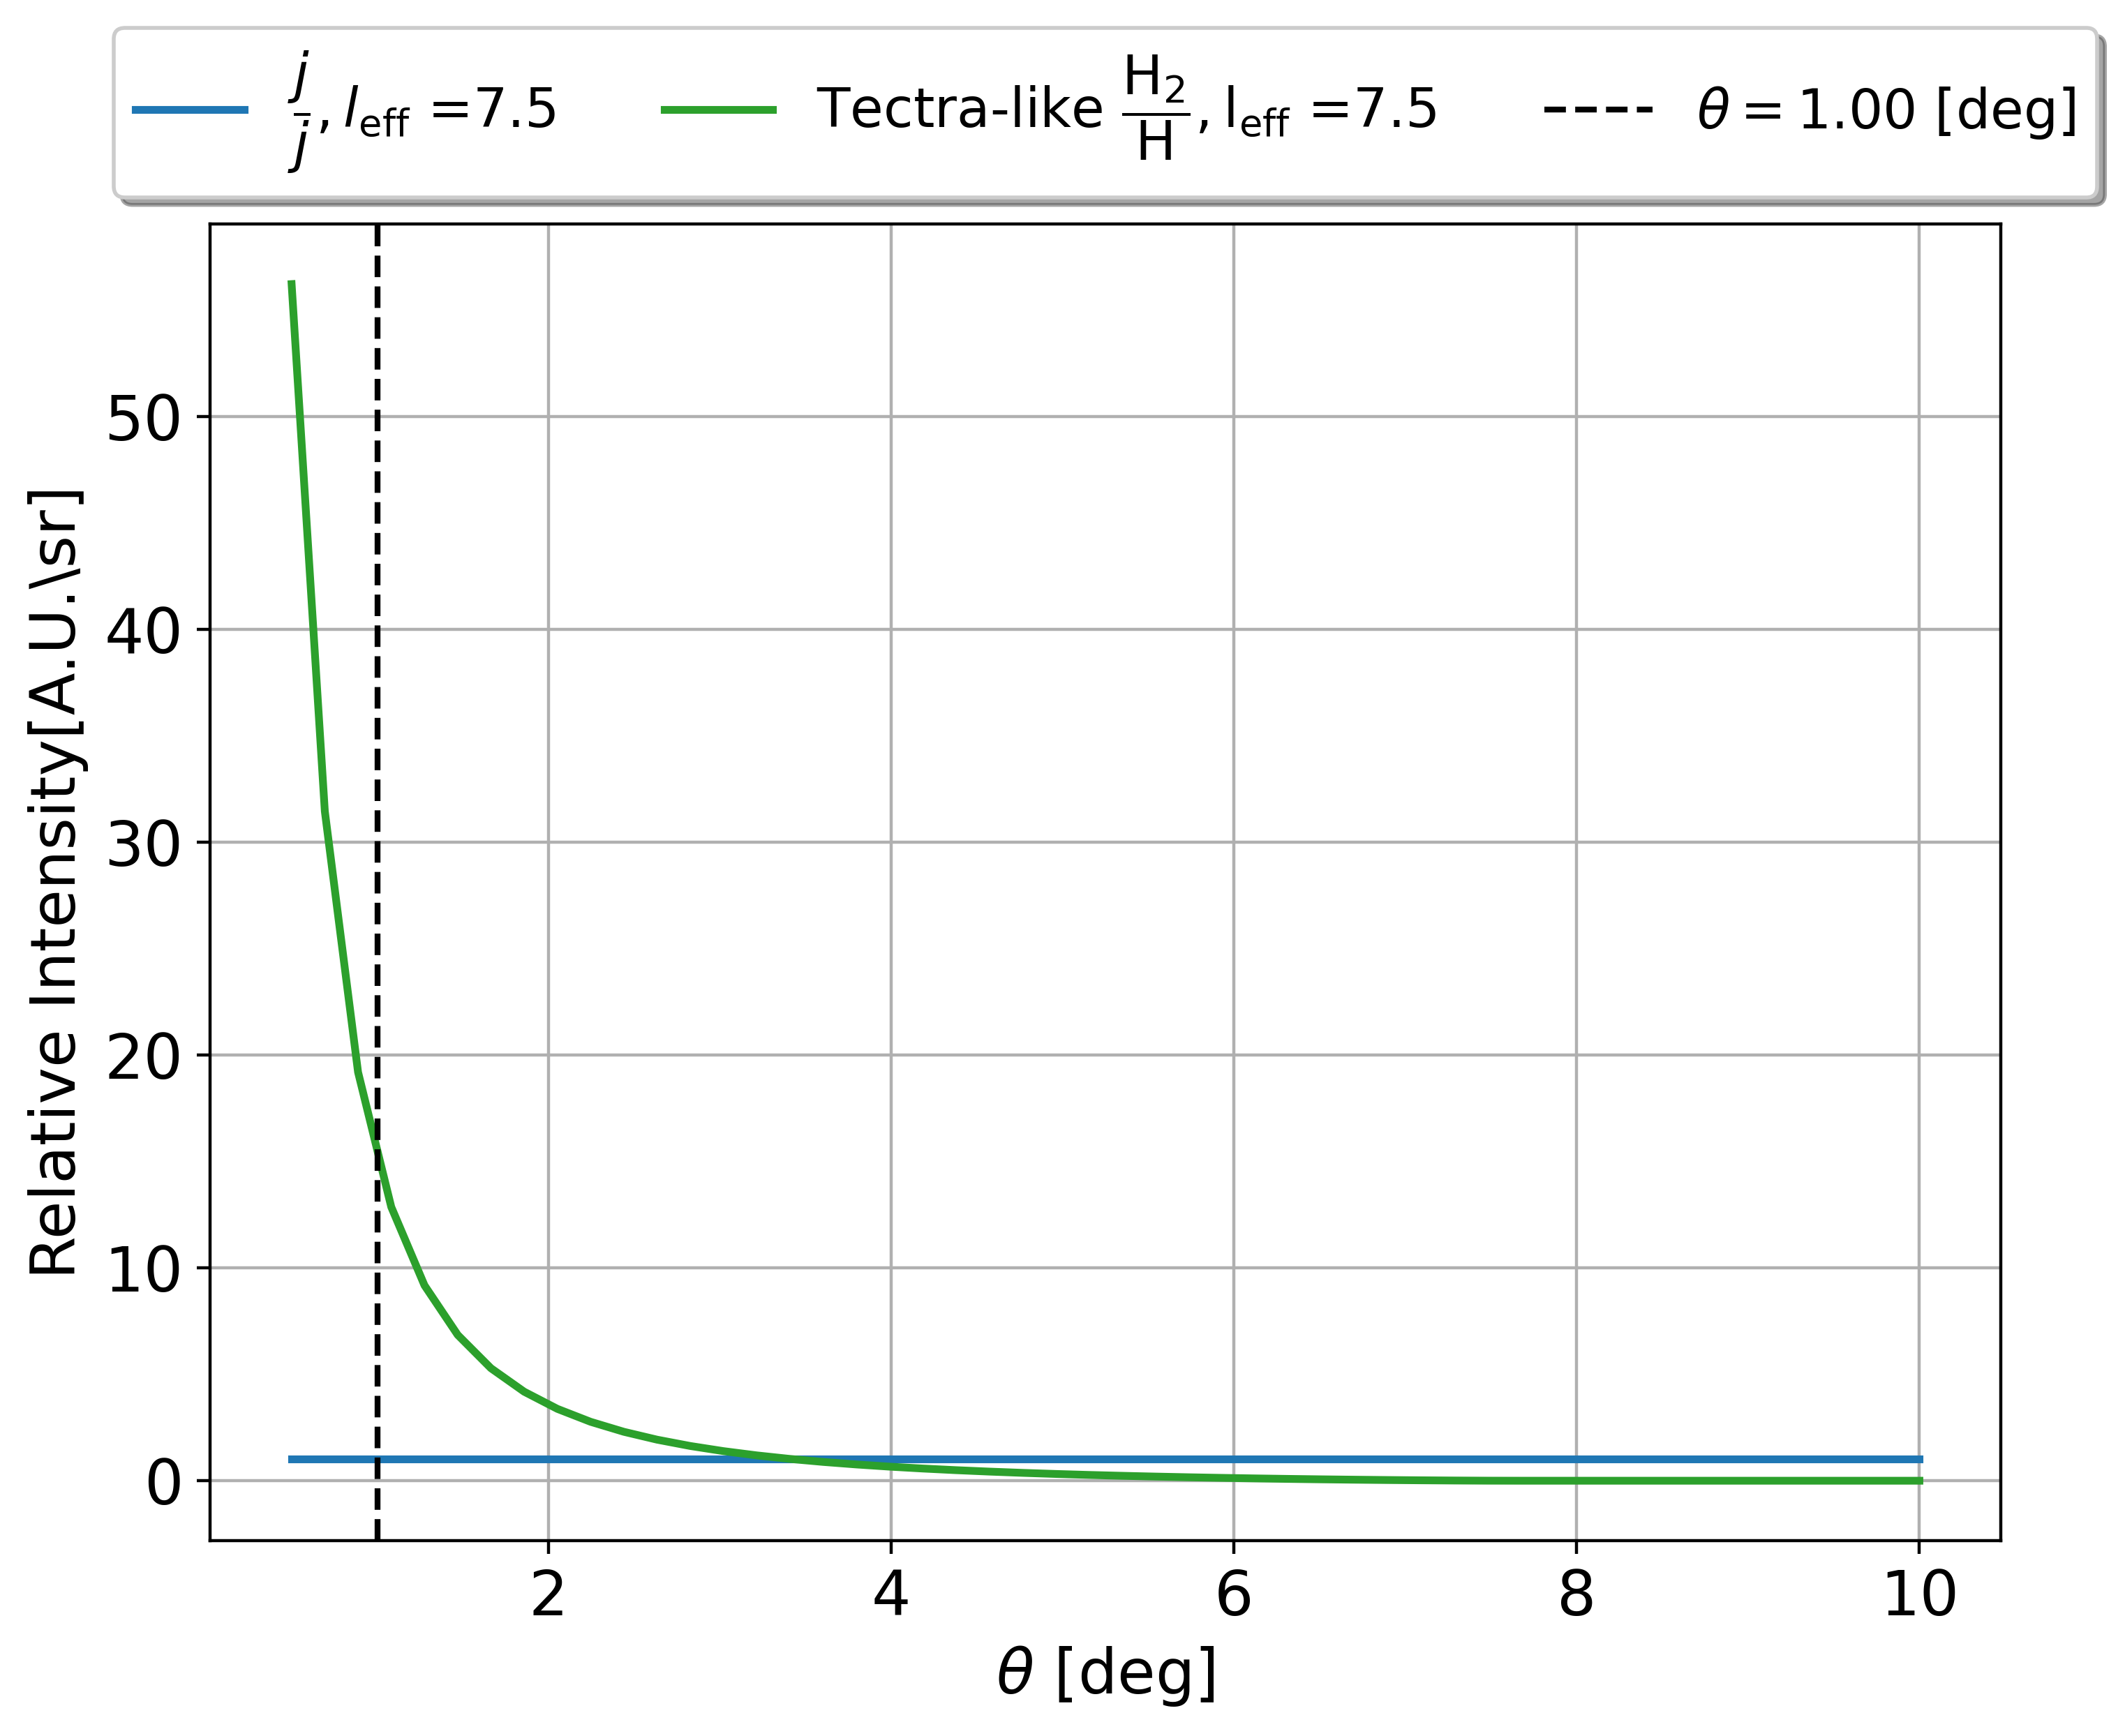

In [23]:
''' jw /j'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(0.5, 10)
    # ys = visible_fraction(xs * degree)
    ys_j = np.array([0.24*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs])
    ys = np.array([0.24*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs])
    ys_jd = [(1/1.12)*(1.12*j(np.abs(x) * degree, l_eff = 75) - 
            0.12*jw(np.abs(x) * degree, l_eff = l_eff))
        for x in xs]

    ax1.plot(xs,ys_j/ys_j,
            color = "C0" ,
            label = r"$\dfrac{j}{j}, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jd/ys,
            color = "C2" ,
            label = r"Tectra-like $\dfrac{\rm{H_2}}{\rm{H}}, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
ax1.axvline(1, label=r"$\theta = $"
        + f"{1:.2f} [deg]", 
        color = "k", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Relative Intensity[A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

### Calculate fraction  of beamm pper area (equal to mass spec) traversed over angle

from wire_analysis.beamshape import (integrate_H_angles_1D, calc_norm_factor,
                                     # integrate_H_angles,
                                     H_profile
                                     )

Scratch

In [24]:
import numpy as np
np.loadtxt("C:\\Users\\Christian\\Documents\\StudiumPhD\\python\\"
           + "Keysight-DMM-34461A\\logs\\" + "calib_2024-11-29_test.txt",
           delimiter=",").T

array([[1.73288089e+09, 1.73288089e+09, 1.73288089e+09, ...,
        1.73288238e+09, 1.73288238e+09, 1.73288239e+09],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan],
       [9.99784600e-01, 9.99780700e-01, 9.99781000e-01, ...,
        1.58980100e+00, 1.58979900e+00, 1.58980600e+00],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.59000000e+00, 1.59000000e+00, 1.59000000e+00]])

In [25]:
[i for i in range(1,4)]

[1, 2, 3]

### Make some plots showing hybrid beams

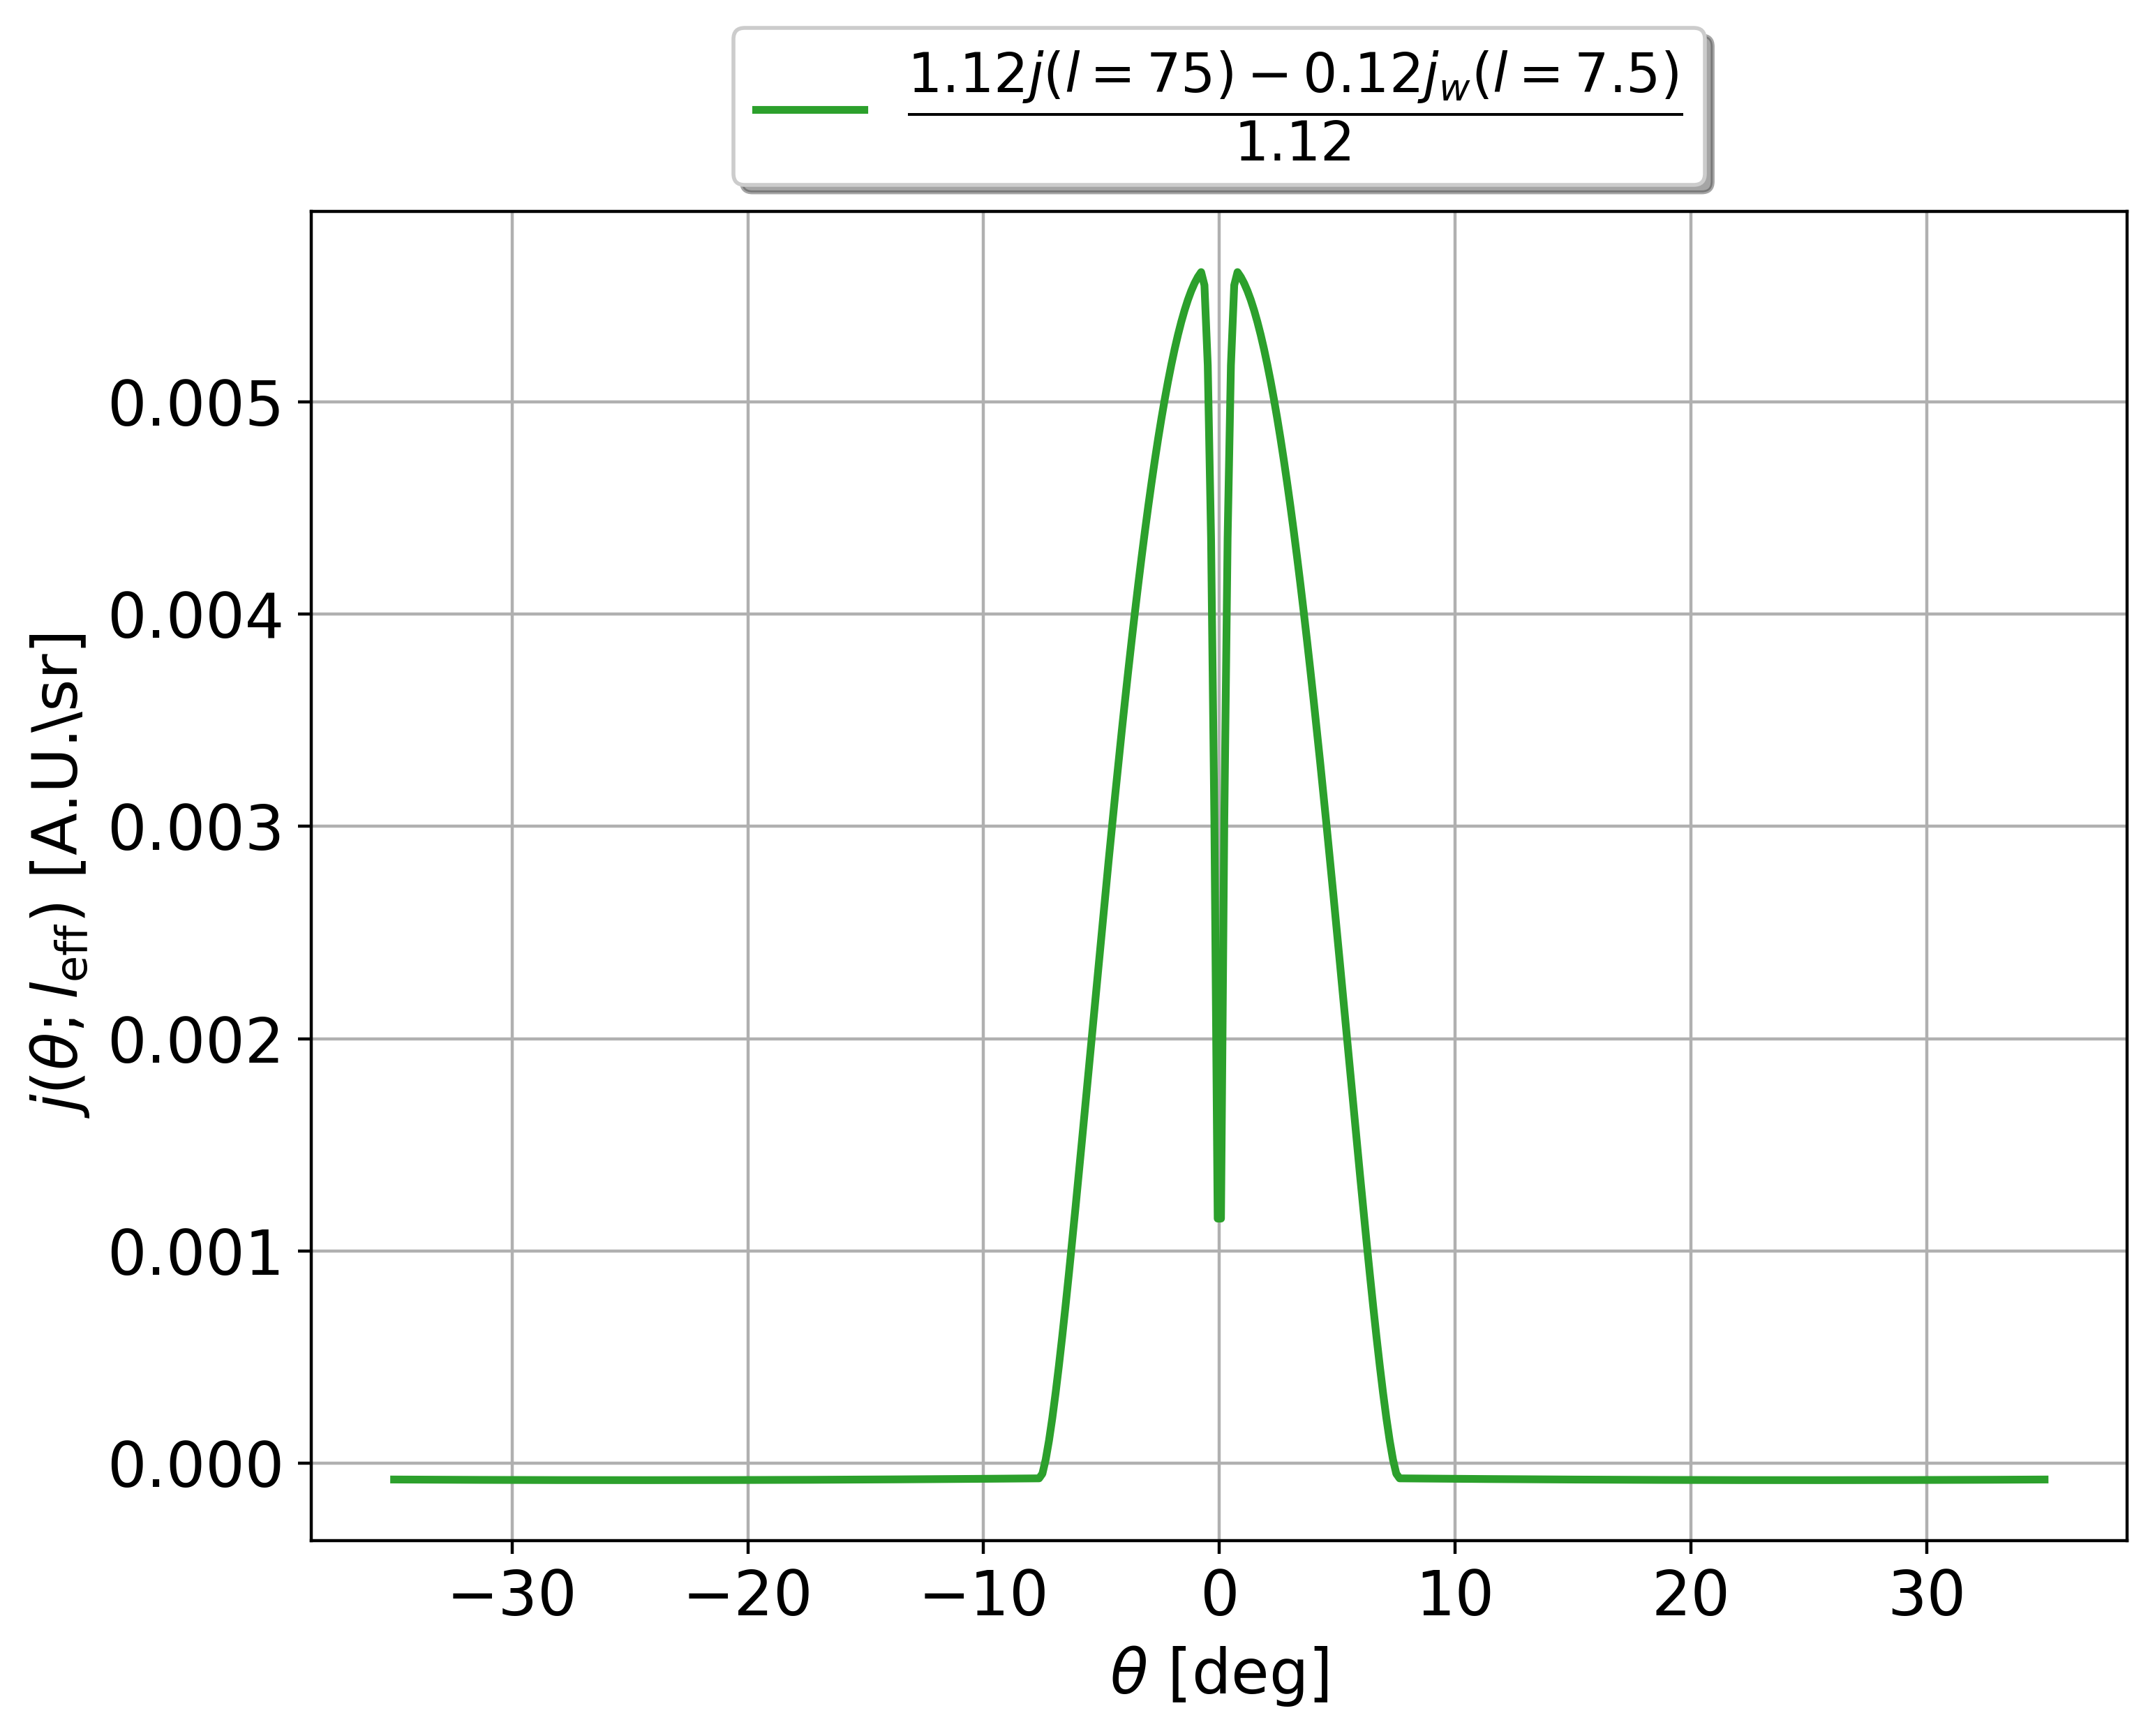

In [59]:
''' j and jw and jd 75 integrated sin(theta)'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [np.sin(np.abs(x) * degree)*
            0.25*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    ys_jd = [np.sin(np.abs(x) * degree)*
             (1/1.12)*(1.12*j(np.abs(x) * degree, l_eff = 75) - 
             0.12*jw(np.abs(x) * degree, l_eff = l_eff))
          for x in xs]
    ys = [np.sin(np.abs(x) * degree)*
          0.25*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    # ax1.plot(xs,ys_j,
    #         color = "C0" ,
    #         label = r"$0.24j, l_{\rm{eff}}$ =" + f"{l_eff}",
    #         lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"$0.24j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
    #         lw= 2)
    ax1.plot(xs,ys_jd,
            color = "C2" ,
            label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
            lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

norm 4.8582475583943765
ys [0.014033436777281225, 0.014097734540694464, 0.014162369845458324, 0.014227346789877034, 0.014292669541782195, 0.01435834233995232, 0.014424369495567324, 0.014490755393699033, 0.014557504494838681, 0.01462462133646249, 0.01469211053463647, 0.014759976785661596, 0.014828224867760517, 0.01489685964280703, 0.014965886058099594, 0.015035309148180286, 0.01510513403670038, 0.015175365938334101, 0.015246010160741993, 0.015317072106585315, 0.015388557275593146, 0.015460471266683725, 0.01553281978014172, 0.015605608619853169, 0.015678843695599878, 0.01575253102541509, 0.015826676738002442, 0.015901287075220052, 0.015976368394631953, 0.01605192717212891, 0.016127970004620837, 0.016204503612803196, 0.01628153484399962, 0.016359070675083326, 0.016437118215479895, 0.01651568471025397, 0.01659477754328269, 0.01667440424051876, 0.016754572473346014, 0.016835290062030644, 0.016916564979271215, 0.016998405353850894, 0.017080819474395204, 0.017163815793238935, 0.01724740293040

<Figure size 2400x1600 with 0 Axes>

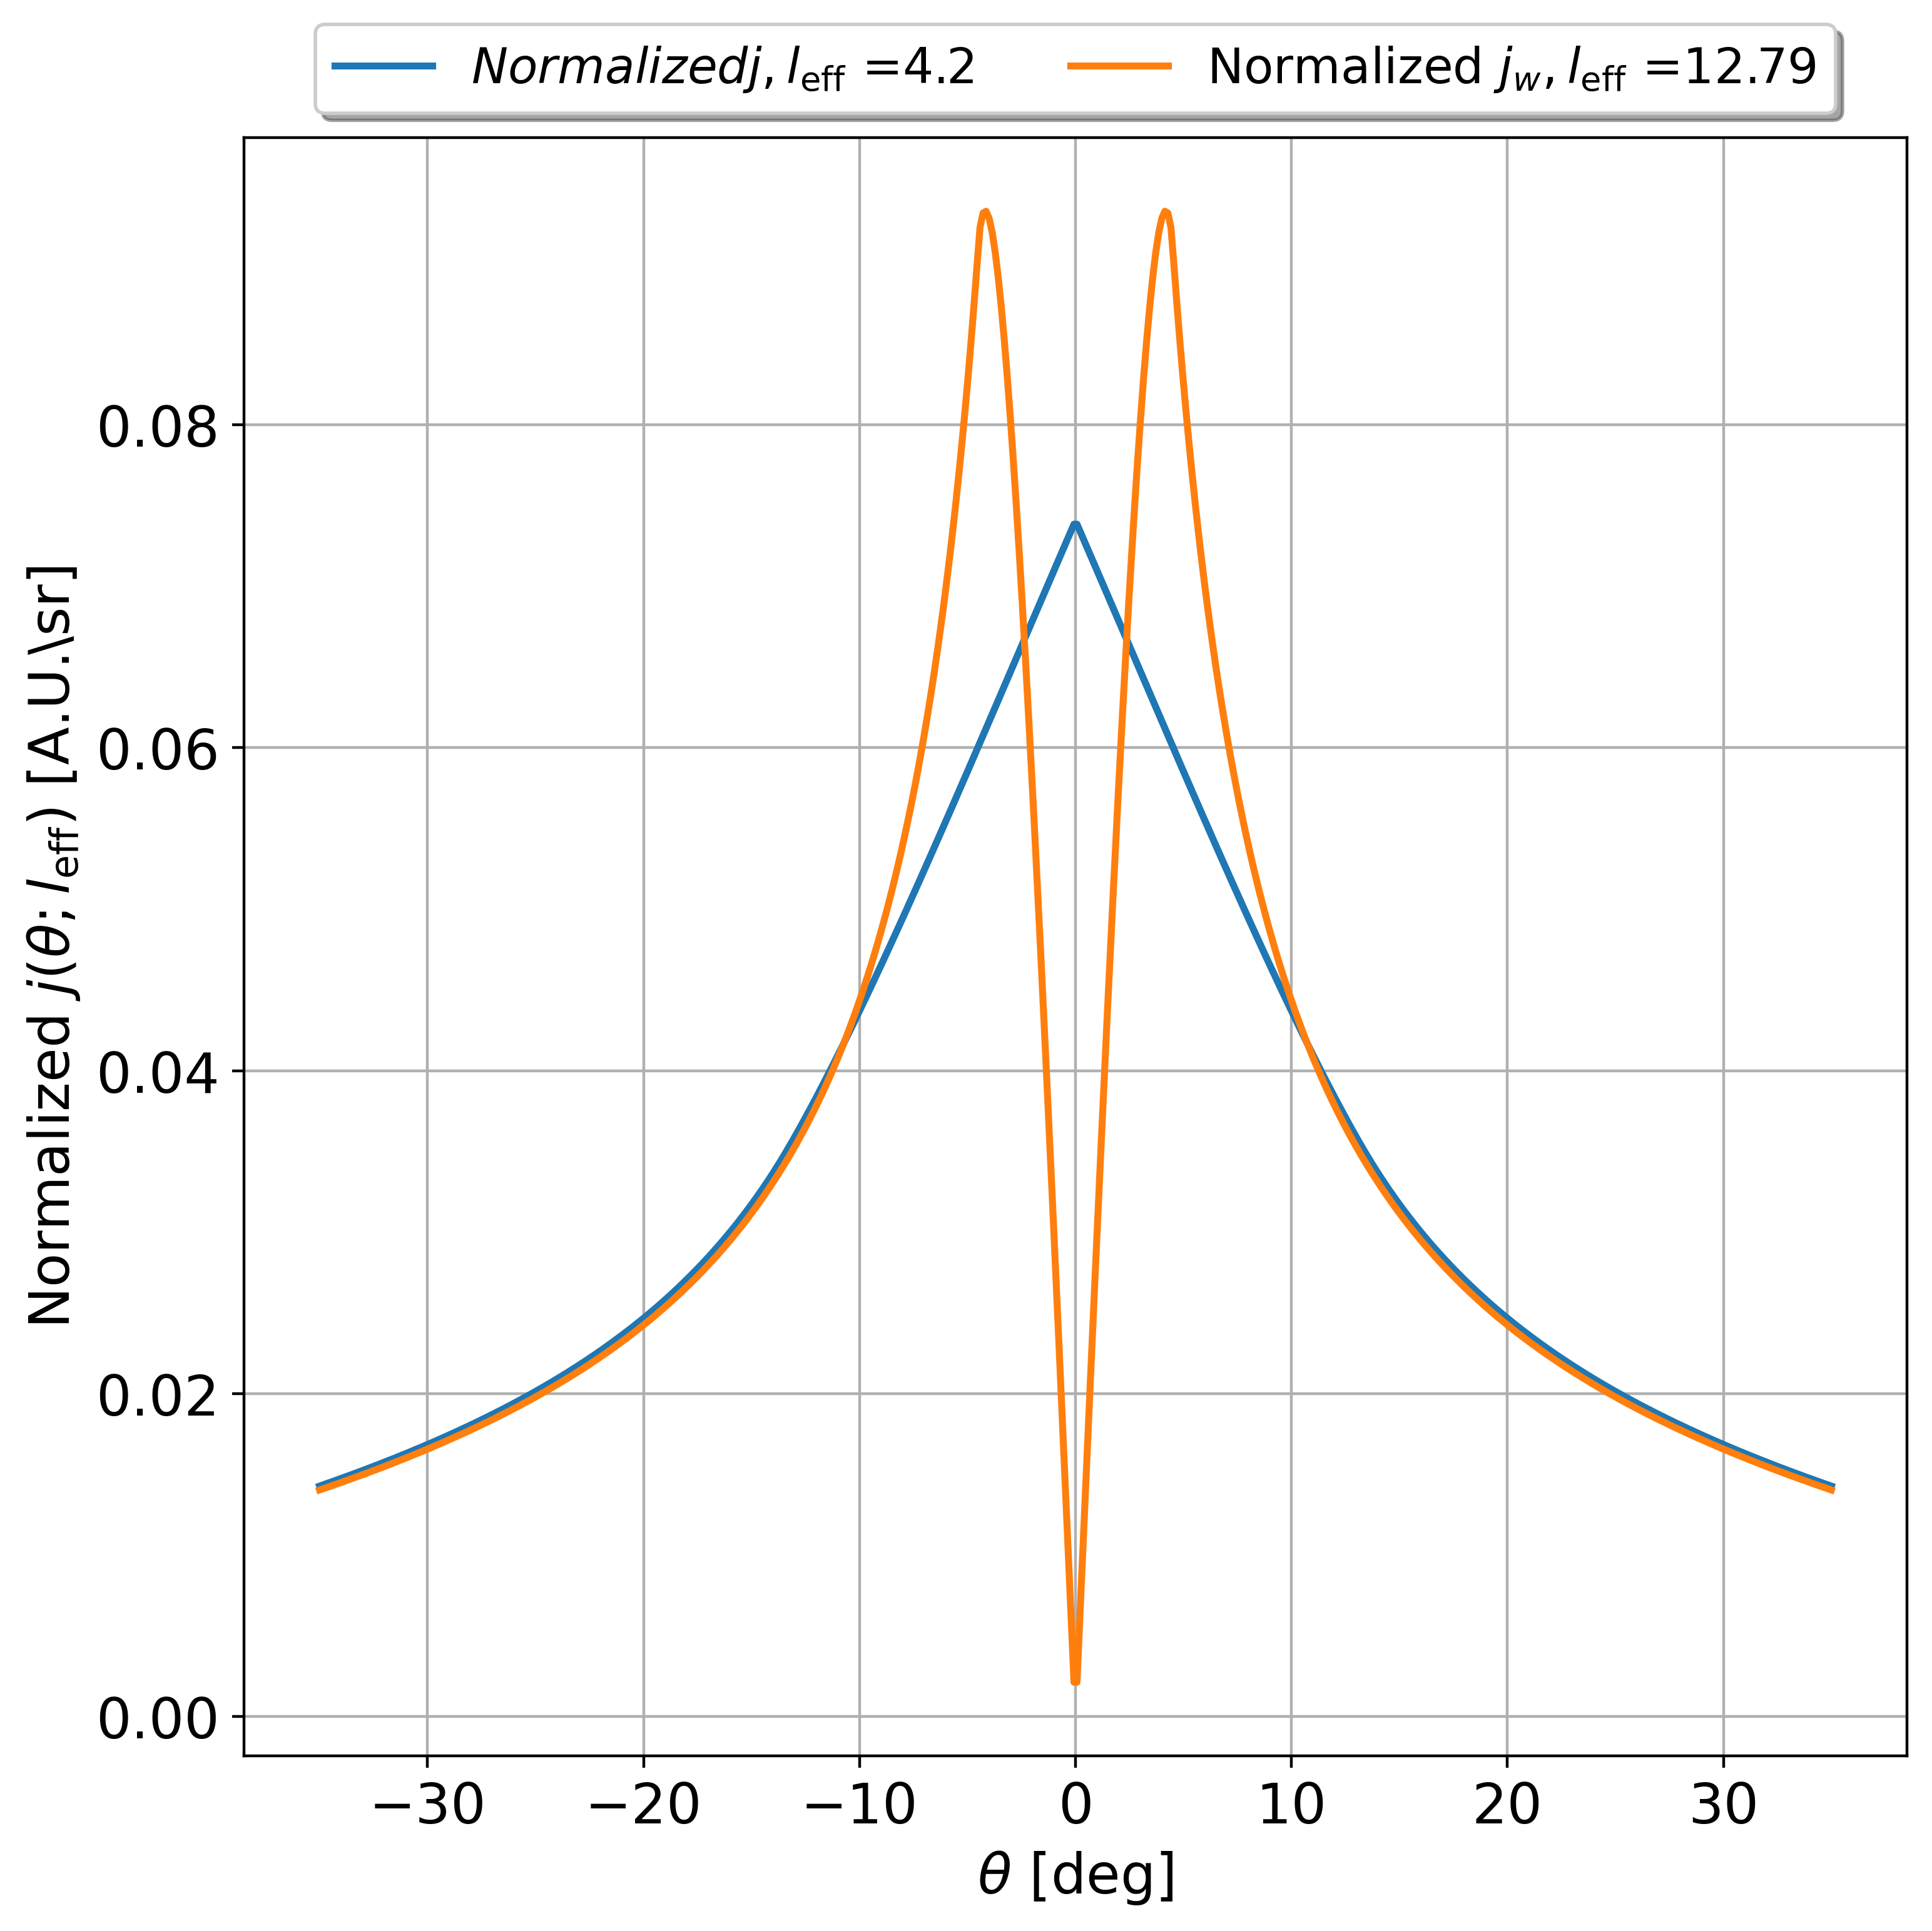

In [58]:
''' j(leff =4.2) annd j_w(lH=12.79) as in "fit"'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [4.2]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x) * degree, l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x) * degree)
    norm = 2*integrate.quad(integrant, 0, 90)[0]
    ys_j = [
          f(x)/norm 
          for x in xs]
    # ys_jd = [np.sin(np.abs(x) * degree)*
    #          (1/1.12)*(1.12*j(np.abs(x) * degree, l_eff = 75) - 
    #          0.12*jw(np.abs(x) * degree, l_eff = l_eff))
    #       for x in xs]
    f = lambda x: jw(np.abs(x) * degree, l_eff=12.79)
    integrant = lambda x:f(x)*np.sin(np.abs(x) * degree)
    norm = 2*integrate.quad(integrant, 0, 90)[0]
    print("norm", norm)
    ys = [
          f(x)/norm 
          for x in xs]
    print("ys", ys)

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$Normalized j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
            lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Normalized $j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


In [64]:
#angular size of Eibl detector 2.3*10-4 sr ->0.755 deg^2 -> 
A=0.755
r=np.sqrt(A/np.pi)
# r in degrees
r

0.4902284814948658

<Figure size 2400x1600 with 0 Axes>

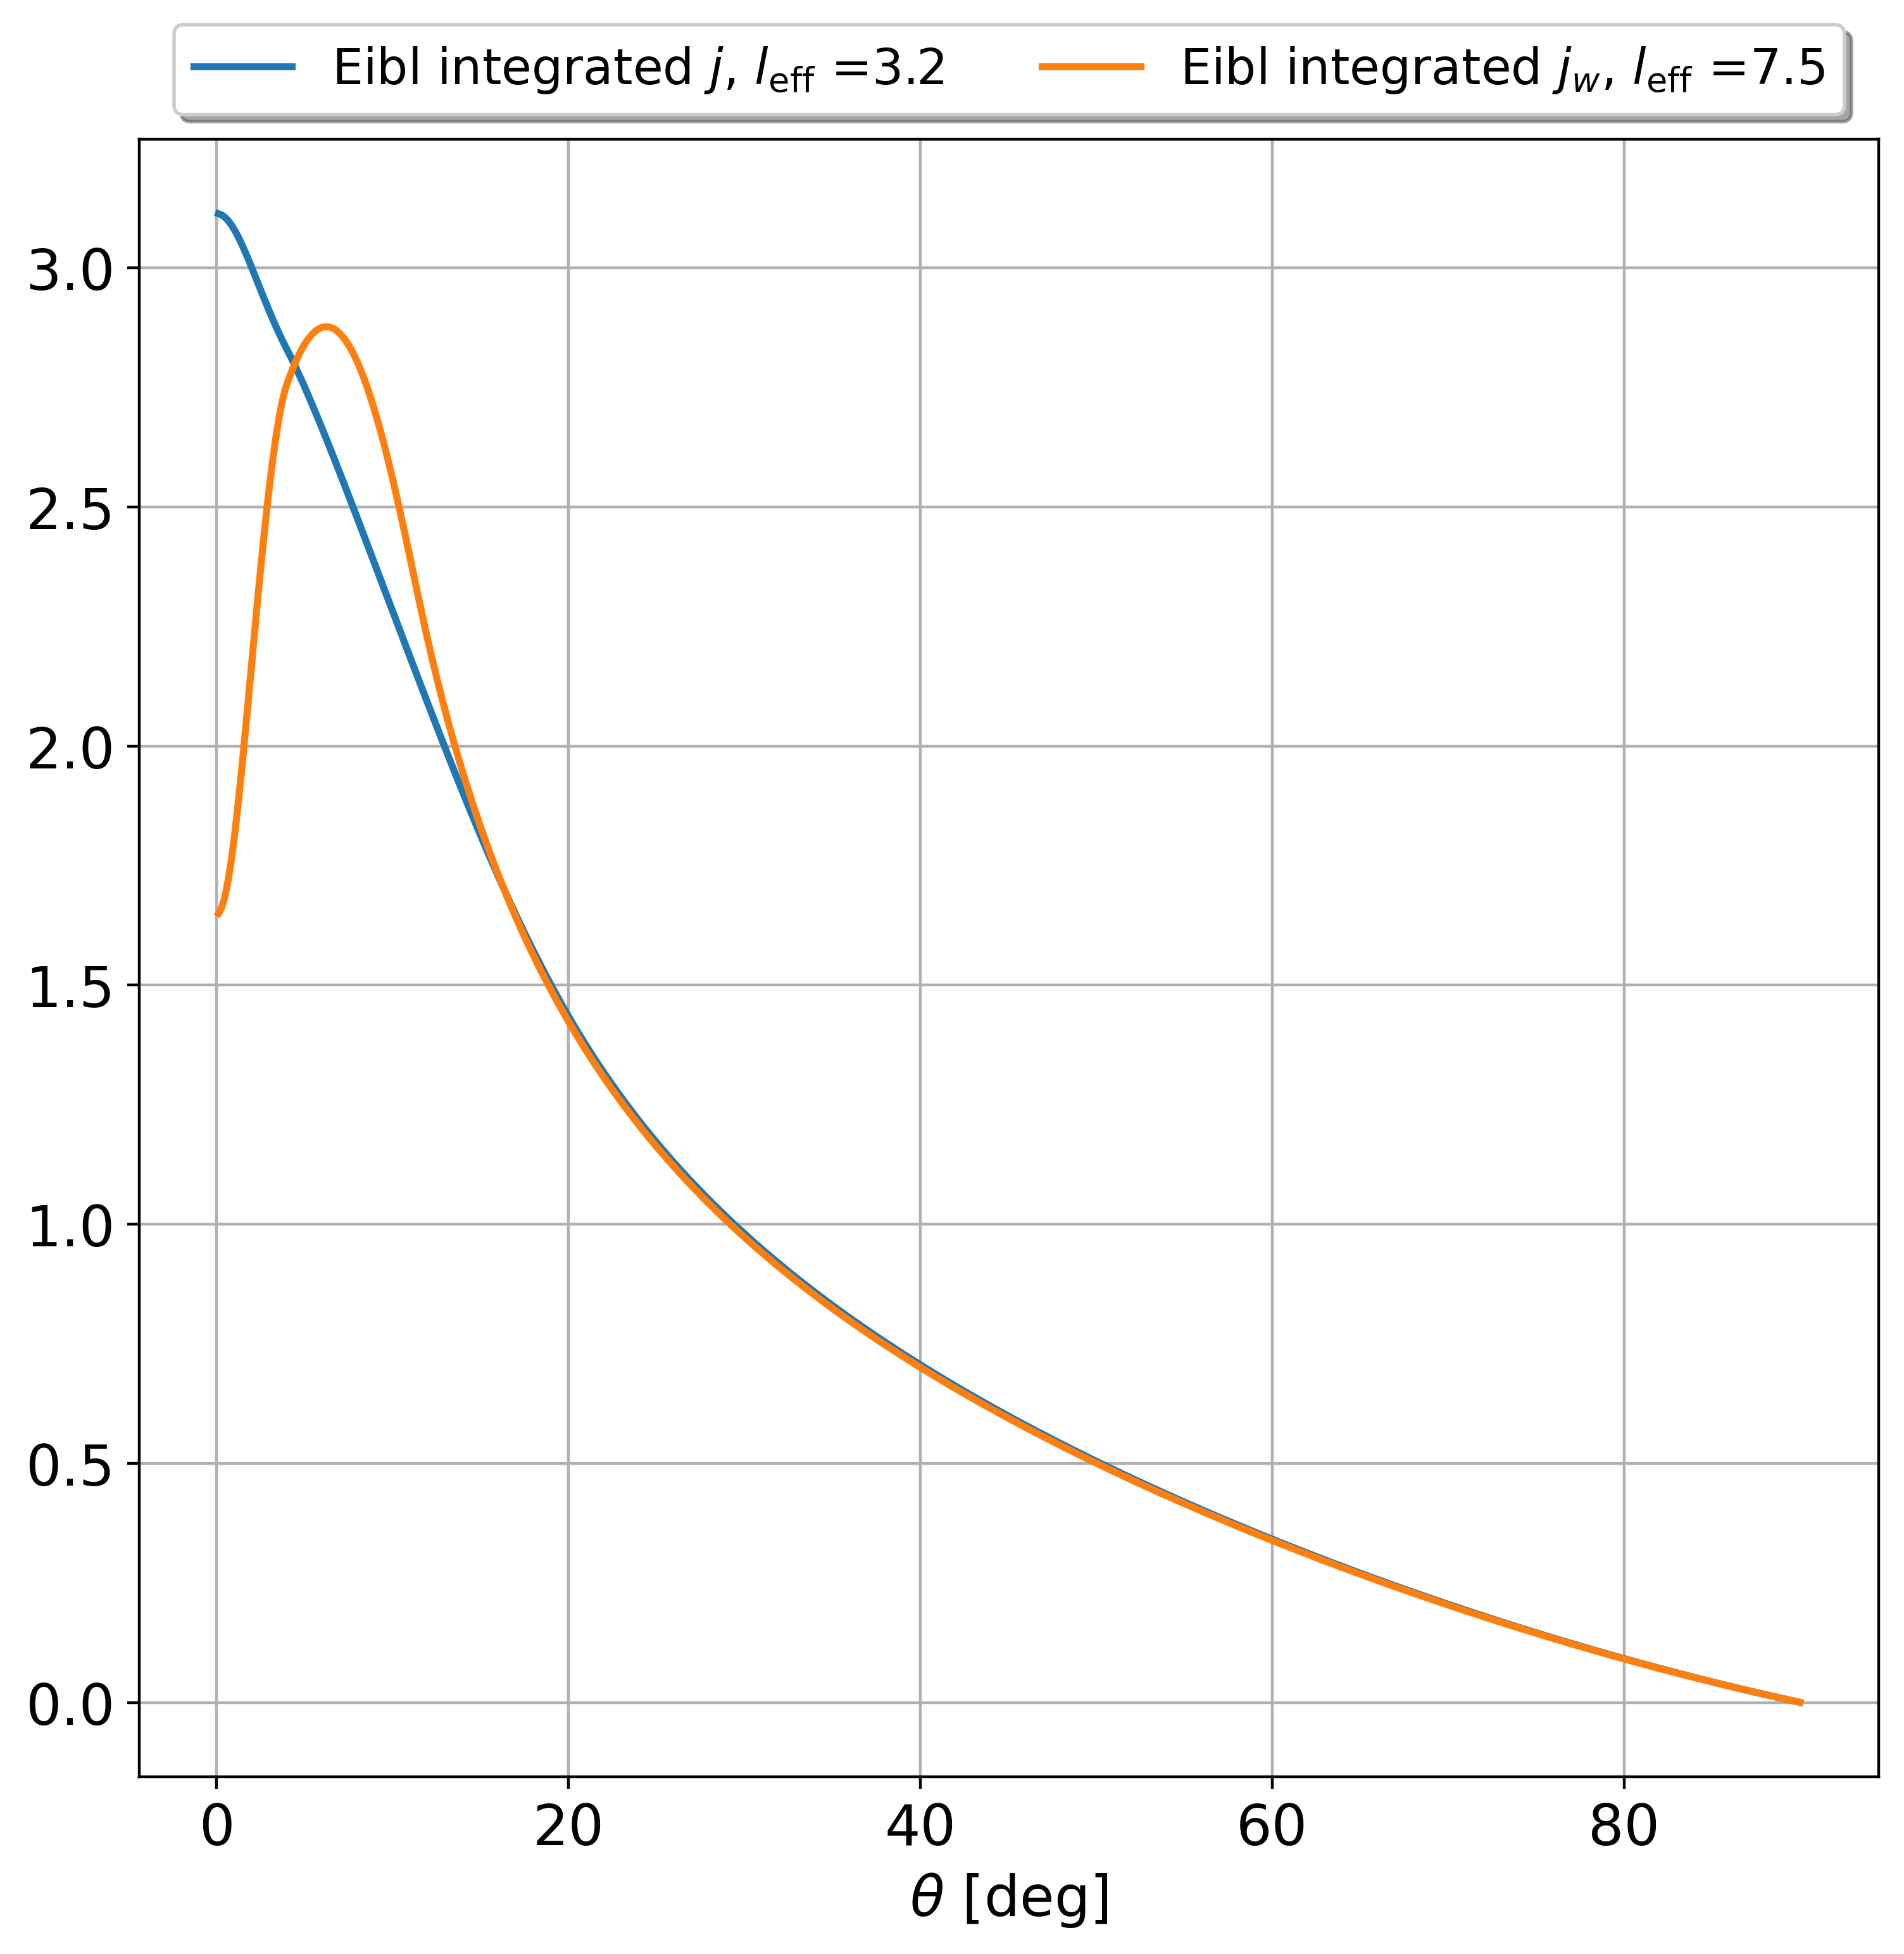

In [106]:
''' attempt to "fit" Eibl Data'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
l_eff_j = 3.2
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 500)
    xs_rad = xs * degree
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x), l_eff = l_eff_j) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # actual integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_j = [
          (f_avg(x)/norm)
          for x in xs_rad]
    
    f = lambda x: jw(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw = [
          (f_avg(x)/norm)
          for x in xs_rad]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"Eibl integrated $j$, $l_{\rm{eff}}$ =" + f"{l_eff_j}",
            lw= 2)
    ax1.plot(xs,ys_jw,
            color = "C1" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


<Figure size 2400x1600 with 0 Axes>

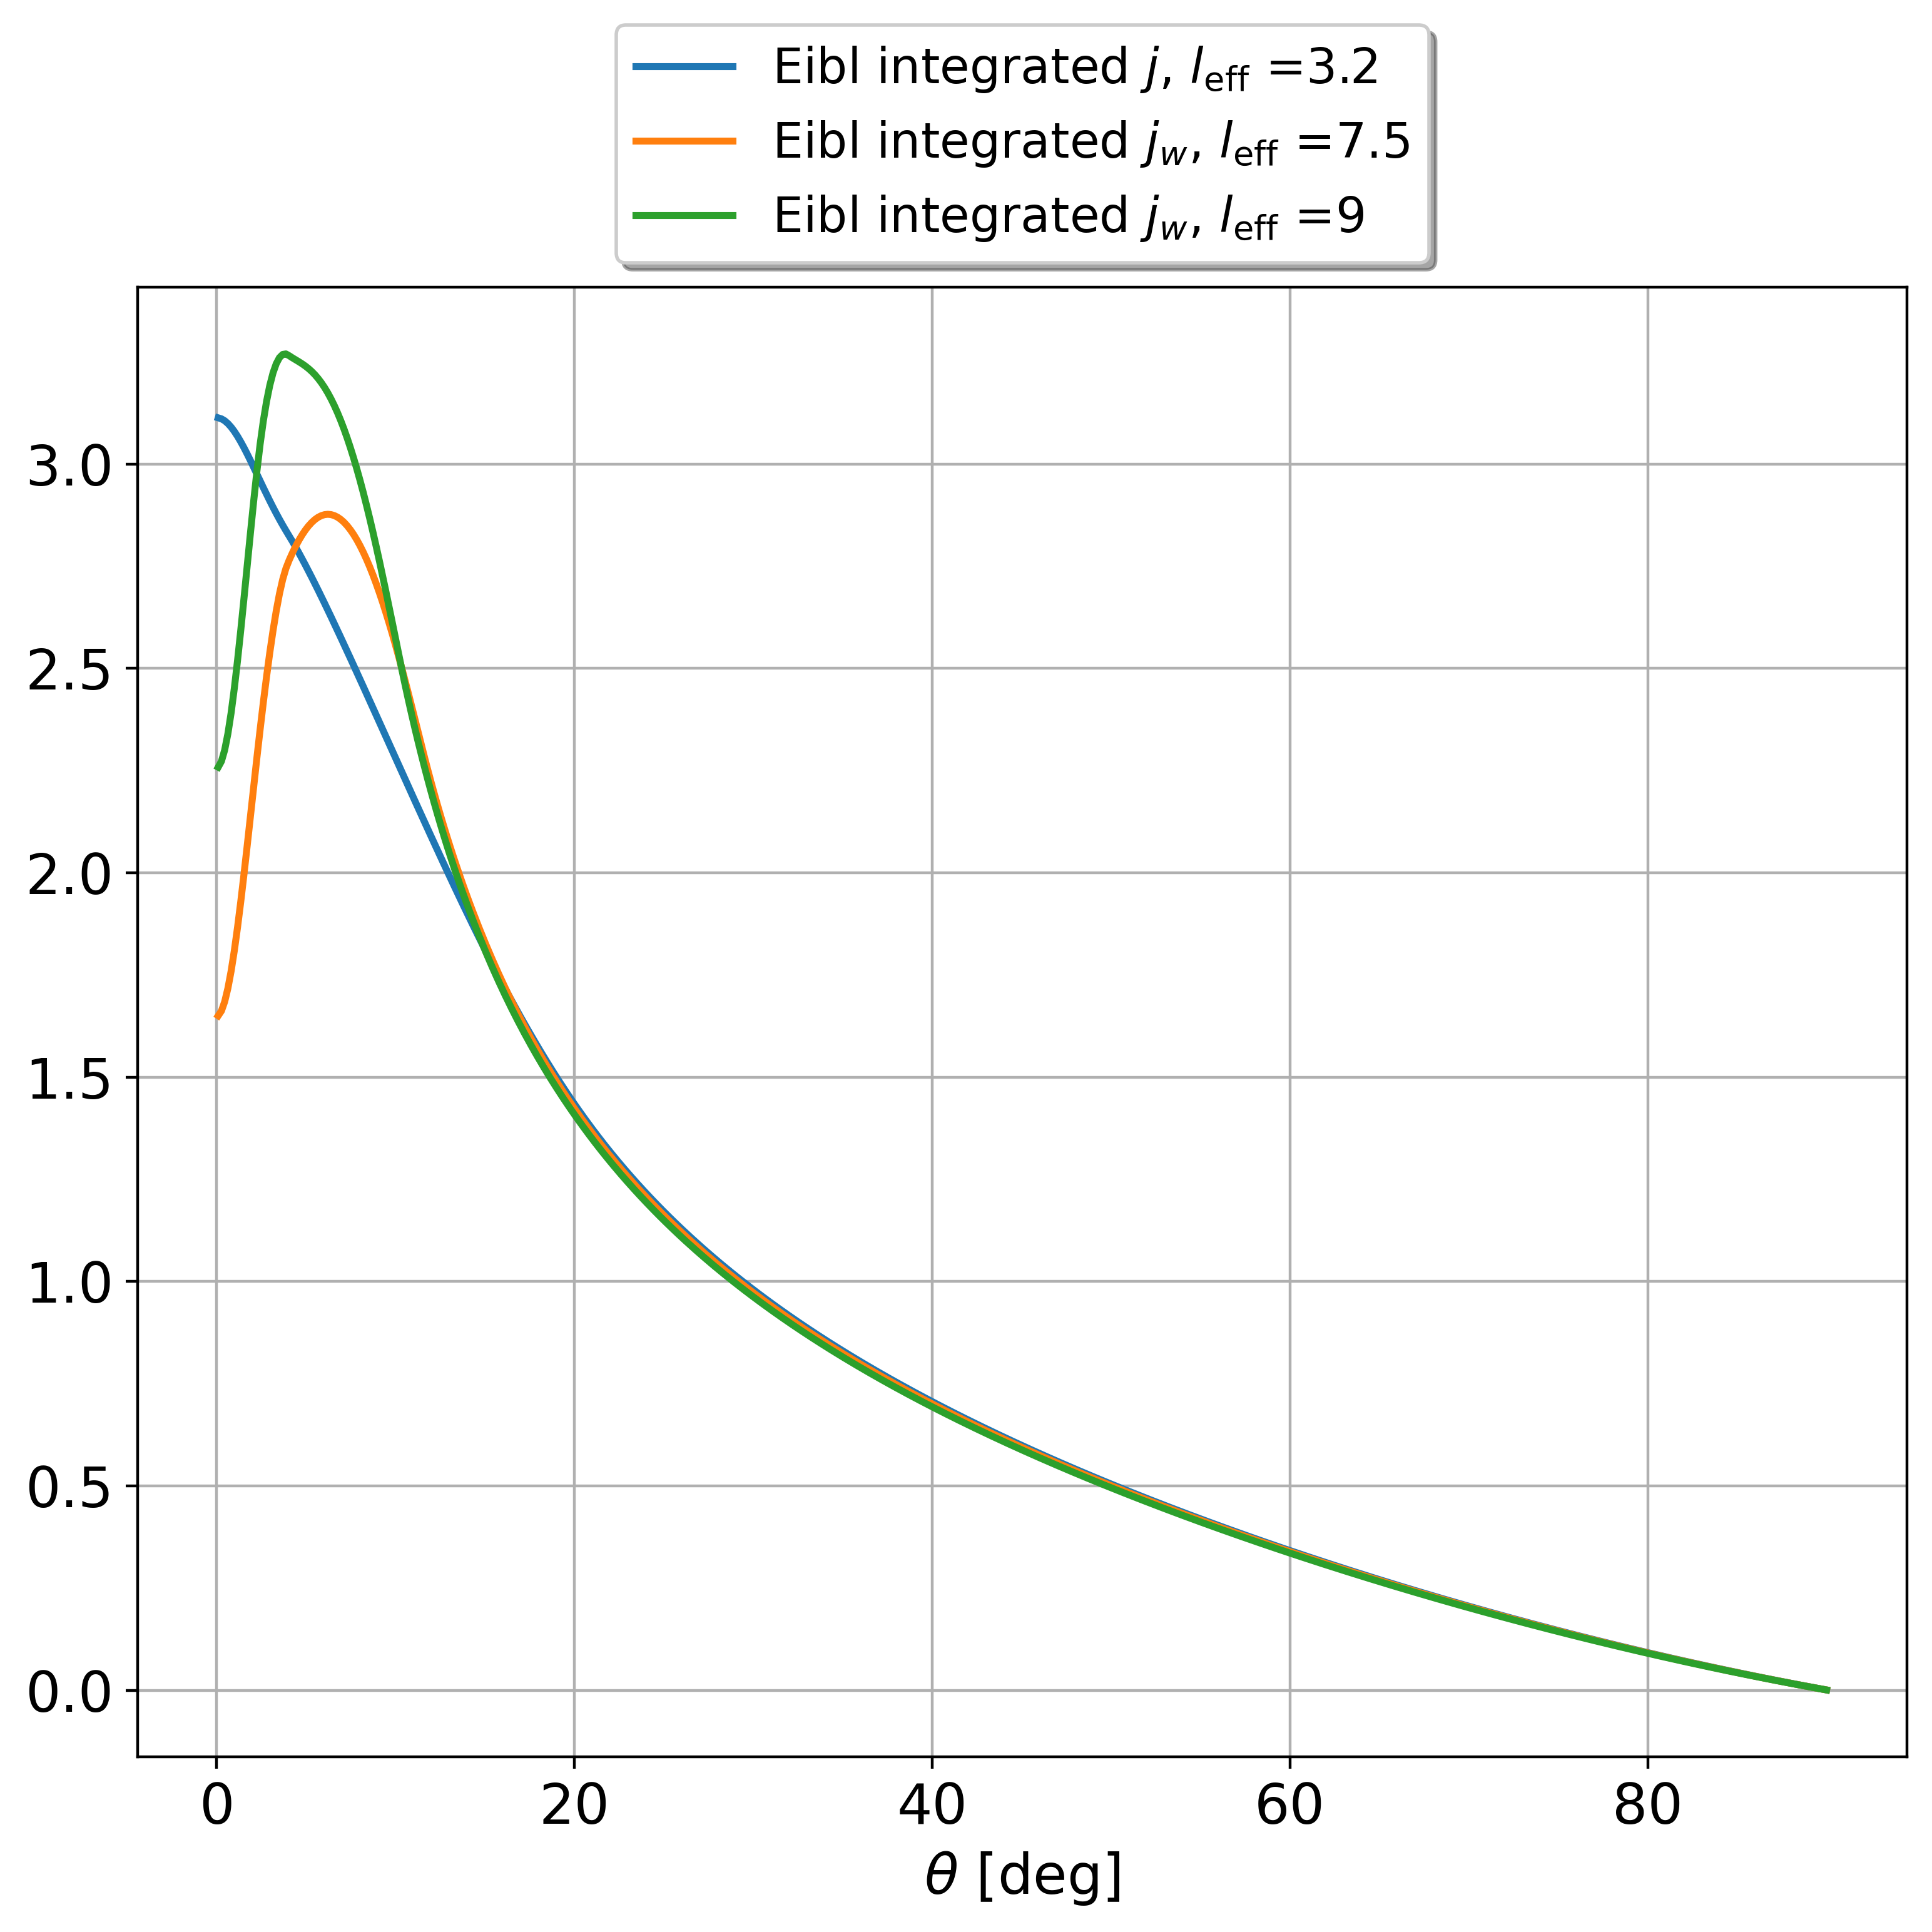

In [113]:
''' attempt to "fit" Eibl Data'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
l_eff_j = 3.2
# l_eff_jw = 7.5 + (400/25)/0.6
l_eff_jw = 9
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 500)
    xs_rad = xs * degree
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x), l_eff = l_eff_j) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # actual integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_j = [
          (f_avg(x)/norm)
          for x in xs_rad]
    
    f = lambda x: jw(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw = [
          (f_avg(x)/norm)
          for x in xs_rad]
    # Alternate l_eff jw
    f = lambda x: jw(np.abs(x), l_eff = l_eff_jw) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw_2 = [
          (f_avg(x)/norm)
          for x in xs_rad]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"Eibl integrated $j$, $l_{\rm{eff}}$ =" + f"{l_eff_j}",
            lw= 2)
    ax1.plot(xs,ys_jw,
            color = "C1" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_jw}",
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

plt.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


<Figure size 2400x1600 with 0 Axes>

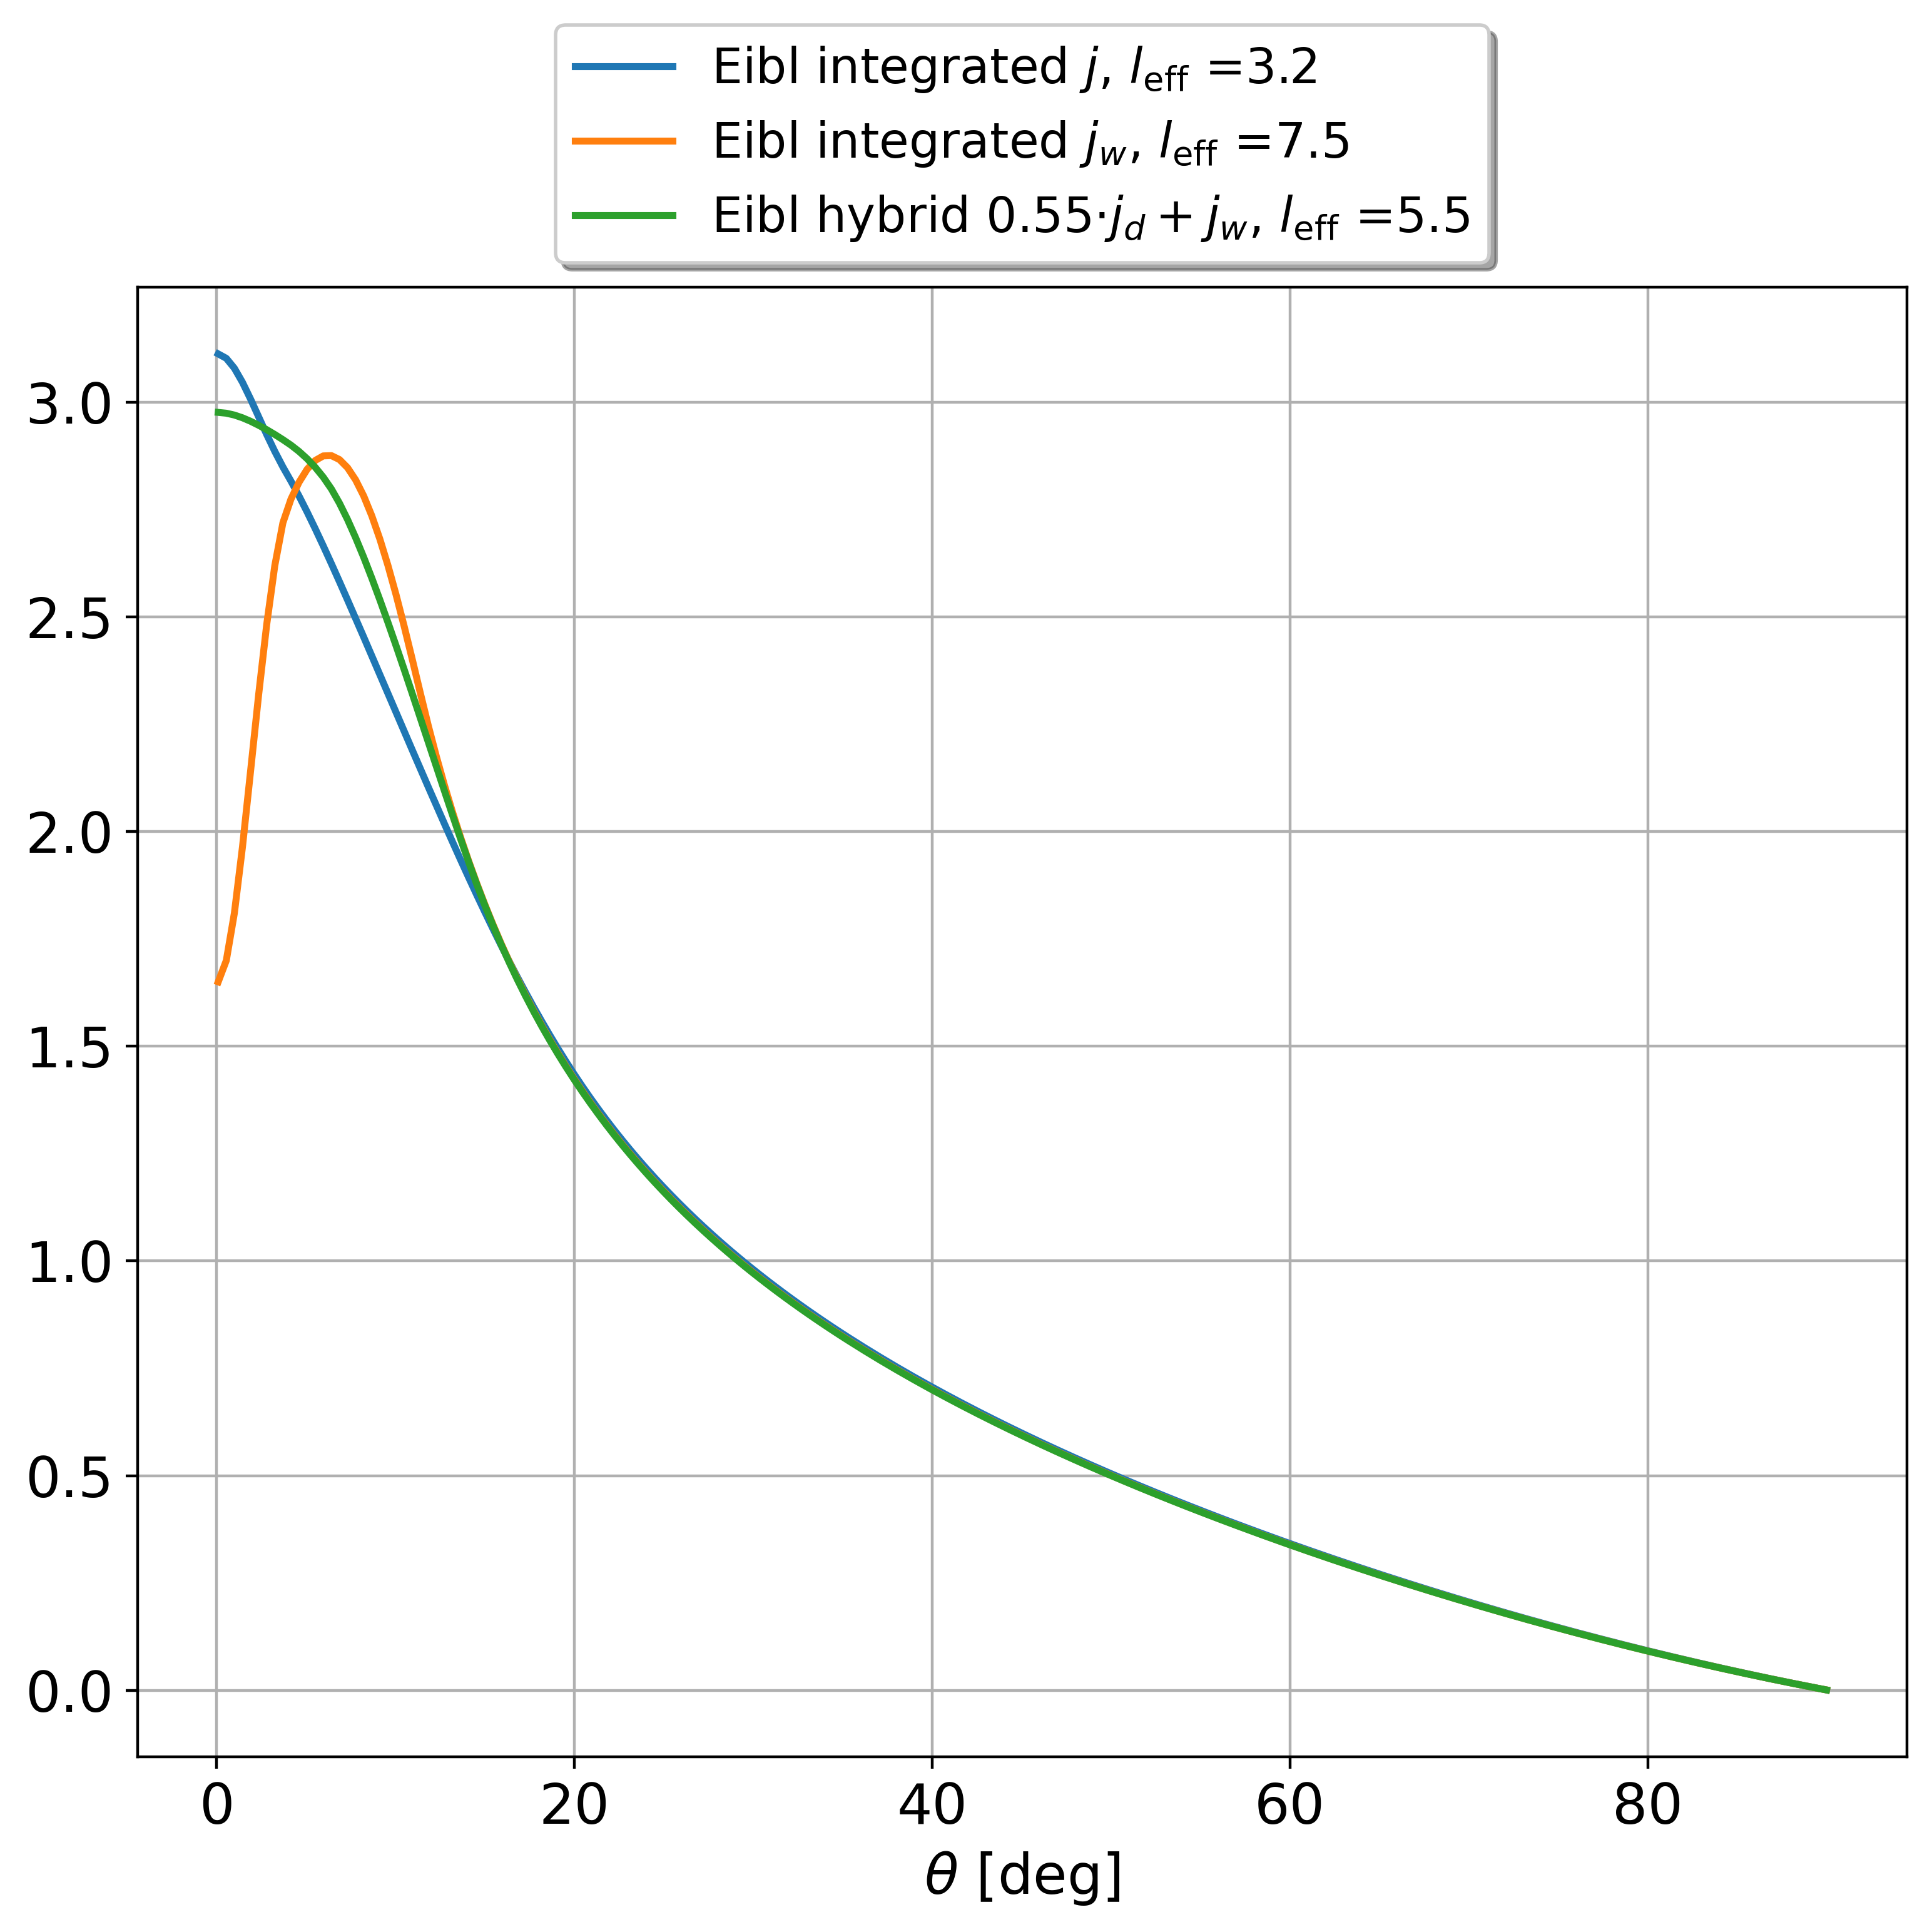

In [129]:
''' attempt to "fit" Eibl Data'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
l_eff_j = 3.2
# l_eff_jw = 7.5 + (400/25)/0.6
l_eff_jw = 5.5
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 200)
    xs_rad = xs * degree
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x), l_eff = l_eff_j) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # actual integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_j = [
          (f_avg(x)/norm)
          for x in xs_rad]
    
    f = lambda x: jw(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw = [
          (f_avg(x)/norm)
          for x in xs_rad]
    # Alternate hybrid model
    jd_scale= 0.55
    f = lambda x: (jd_scale*jd(np.abs(x), l_eff =l_eff_jw) 
                + jw(np.abs(x), l_eff = l_eff_jw))
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw_2 = [
          (f_avg(x)/norm)
          for x in xs_rad]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"Eibl integrated $j$, $l_{\rm{eff}}$ =" + f"{l_eff_j}",
            lw= 2)
    ax1.plot(xs,ys_jw,
            color = "C1" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"{jd_scale}" 
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_jw}"),
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

plt.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


<Figure size 2400x1600 with 0 Axes>

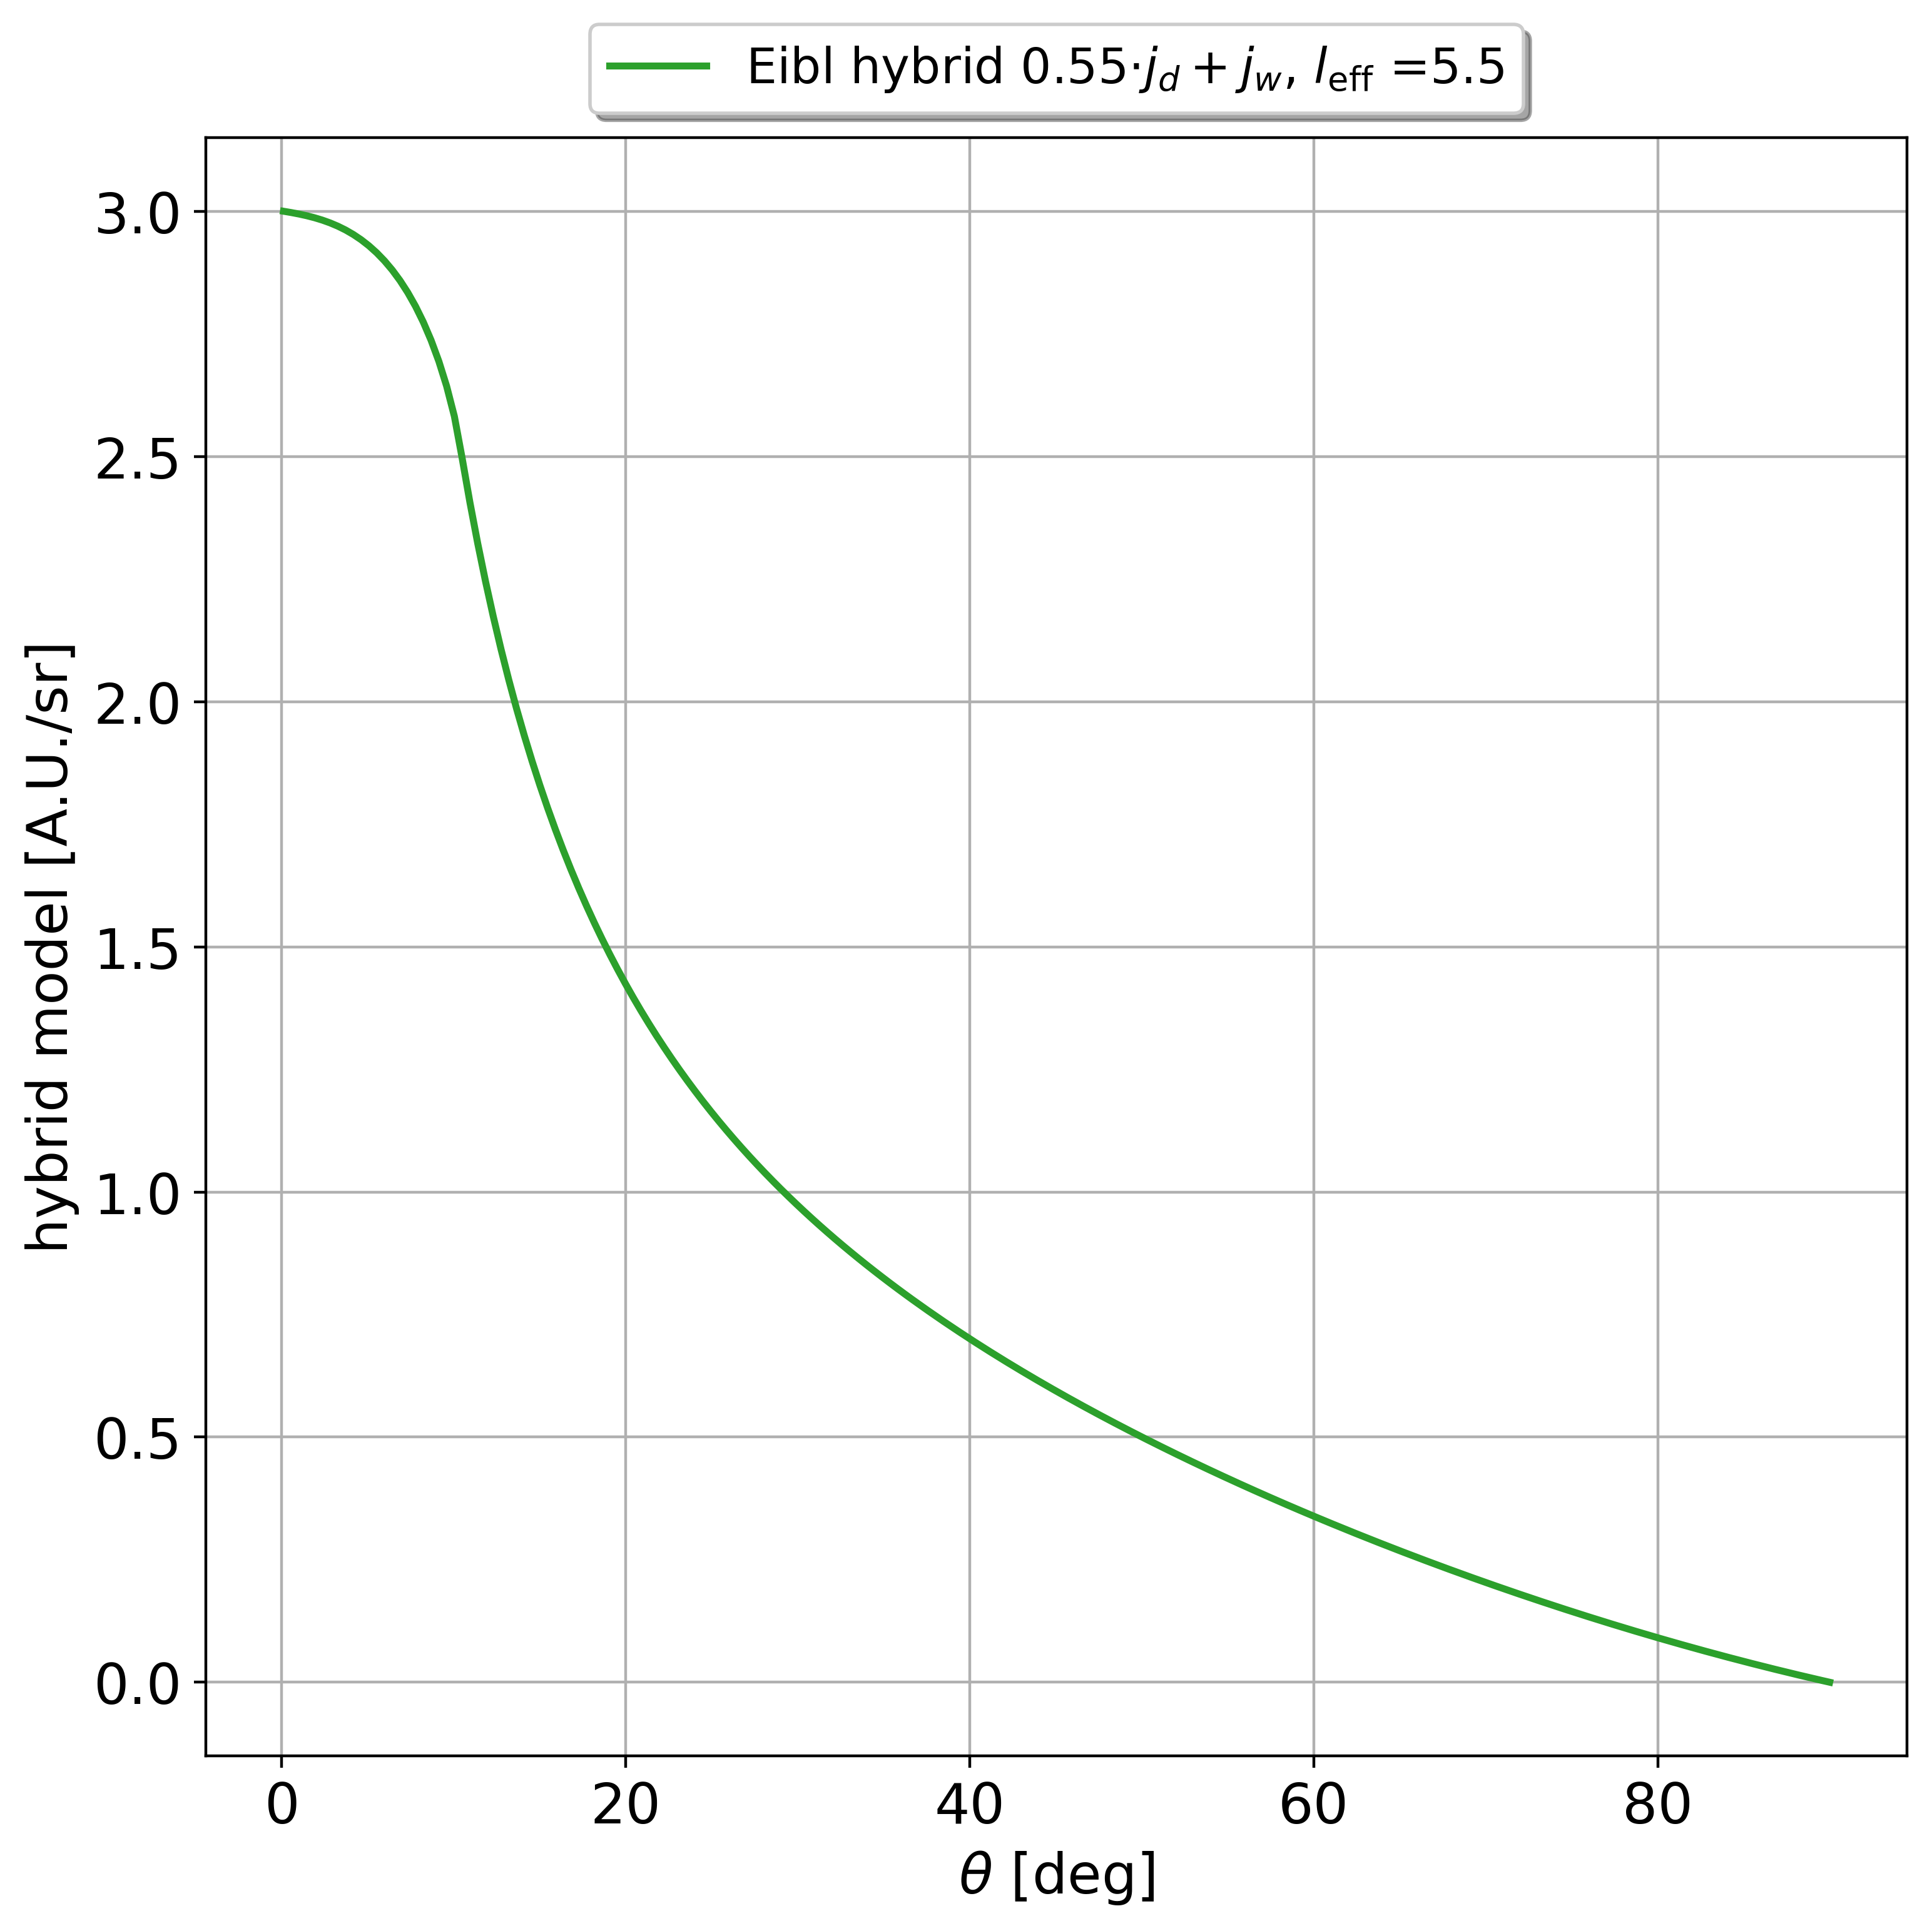

In [131]:
''' Plot  original beam shape'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
l_eff_j = 3.2
# l_eff_jw = 7.5 + (400/25)/0.6
l_eff_jw = 5.5
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 200)
    xs_rad = xs * degree

    # Alternate hybrid model
    jd_scale= 0.55
    f = lambda x: (jd_scale*jd(np.abs(x), l_eff =l_eff_jw) 
                + jw(np.abs(x), l_eff = l_eff_jw))
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw_2 = [
          (f(x)/norm)
          for x in xs_rad]
    
    ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"{jd_scale}" 
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_jw}"),
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"hybrid model [A.U./sr]")

plt.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


<Figure size 2400x1600 with 0 Axes>

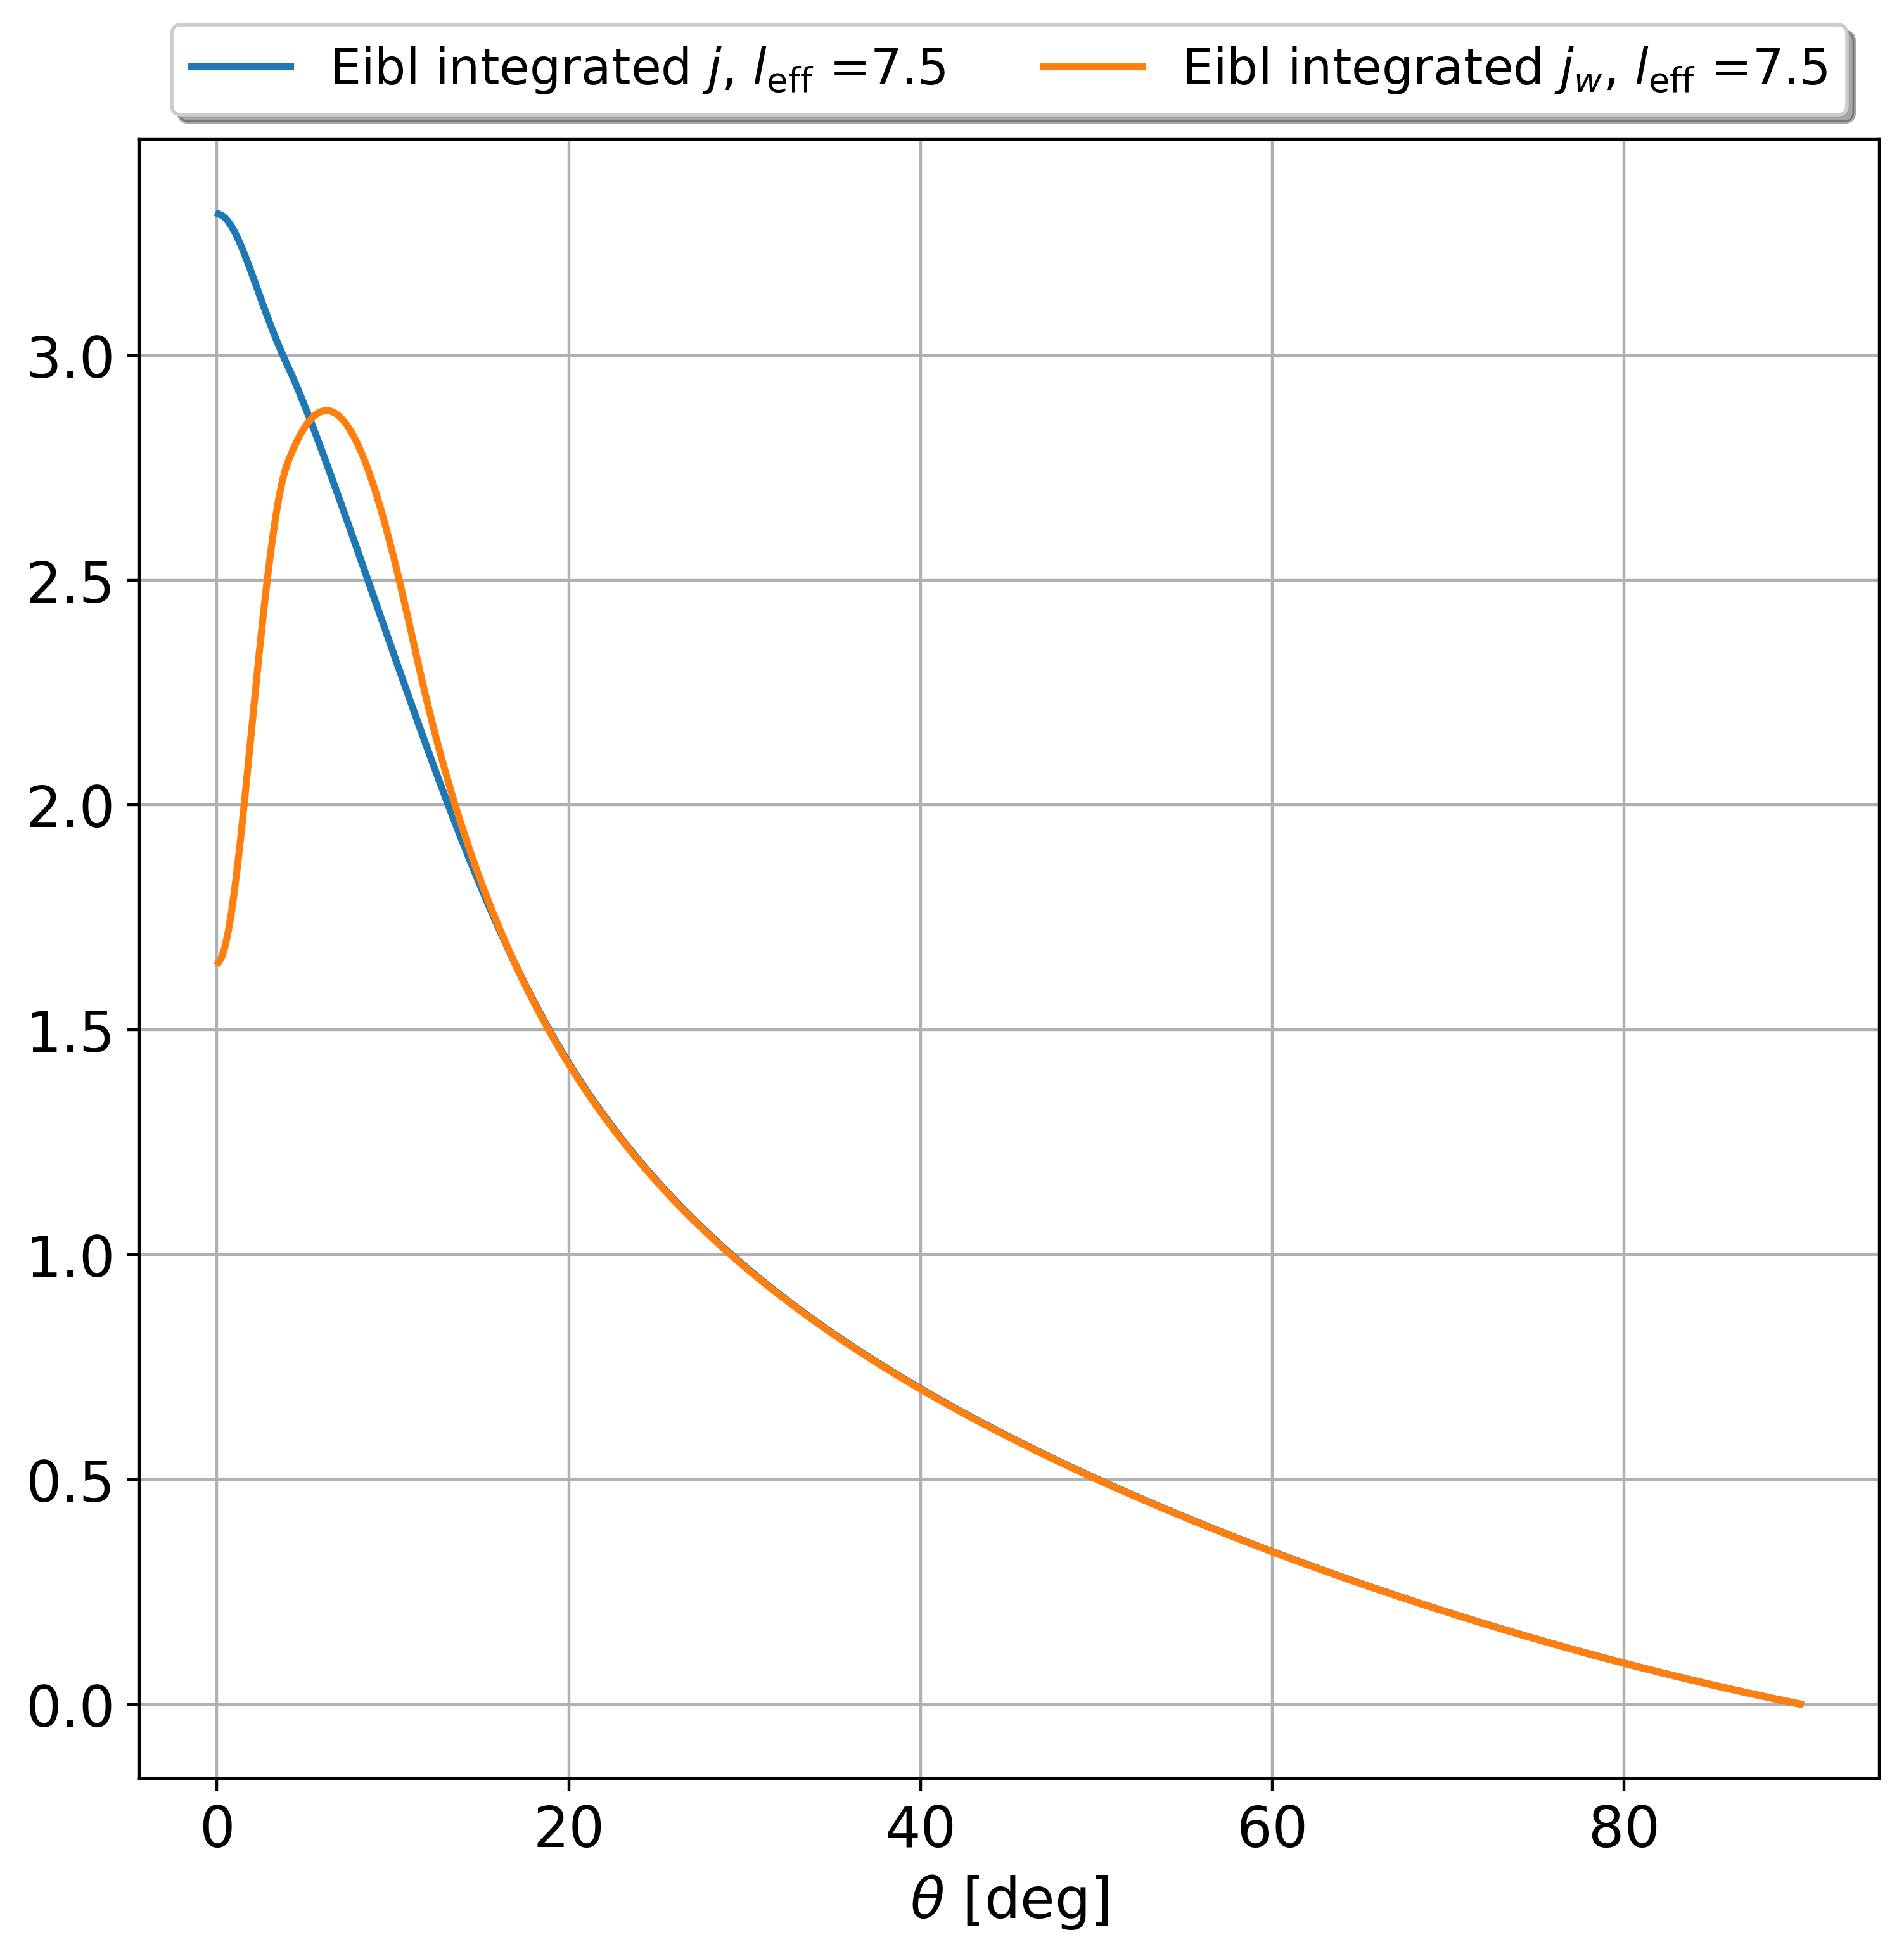

In [ ]:
''' attempt to "fit" Eibl Data'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 500)
    xs_rad = xs * degree
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # actual integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_j = [
          (f_avg(x)/norm)
          for x in xs_rad]
    
    f = lambda x: jw(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw = [
          (f_avg(x)/norm)
          for x in xs_rad]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"Eibl integrated $j$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jw,
            color = "C1" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


norm 12.71365718001012
ys [0.015163529827295711, 0.015233005399731641, 0.015302845695251397, 0.015373055142189918, 0.015443638244008465, 0.015514599580828452, 0.01558594381100309, 0.015657675672727914, 0.01572979998569128, 0.015802321652766026, 0.015875245661743514, 0.015948577087111265, 0.016022321091875524, 0.01609648292942998, 0.016171067945472135, 0.0162460815799687, 0.01632152936917142, 0.016397416947684956, 0.016473750050588327, 0.01655053451561156, 0.016627776285369225, 0.016705481409652626, 0.016783656047782387, 0.016862306471023374, 0.016941439065063863, 0.017021060332560907, 0.017101176895754074, 0.017181795499149603, 0.017262923012277262, 0.017344566432522253, 0.017426732888034428, 0.017509429640717458, 0.01759266408930038, 0.017676443772494256, 0.017760776372236782, 0.017845669717027515, 0.017931131785356918, 0.018017170709232134, 0.01810379477780283, 0.018191012441090282, 0.018278832313823355, 0.01836726317938474, 0.0184563139938714, 0.018545993890272842, 0.018636312182771

<Figure size 2400x1600 with 0 Axes>

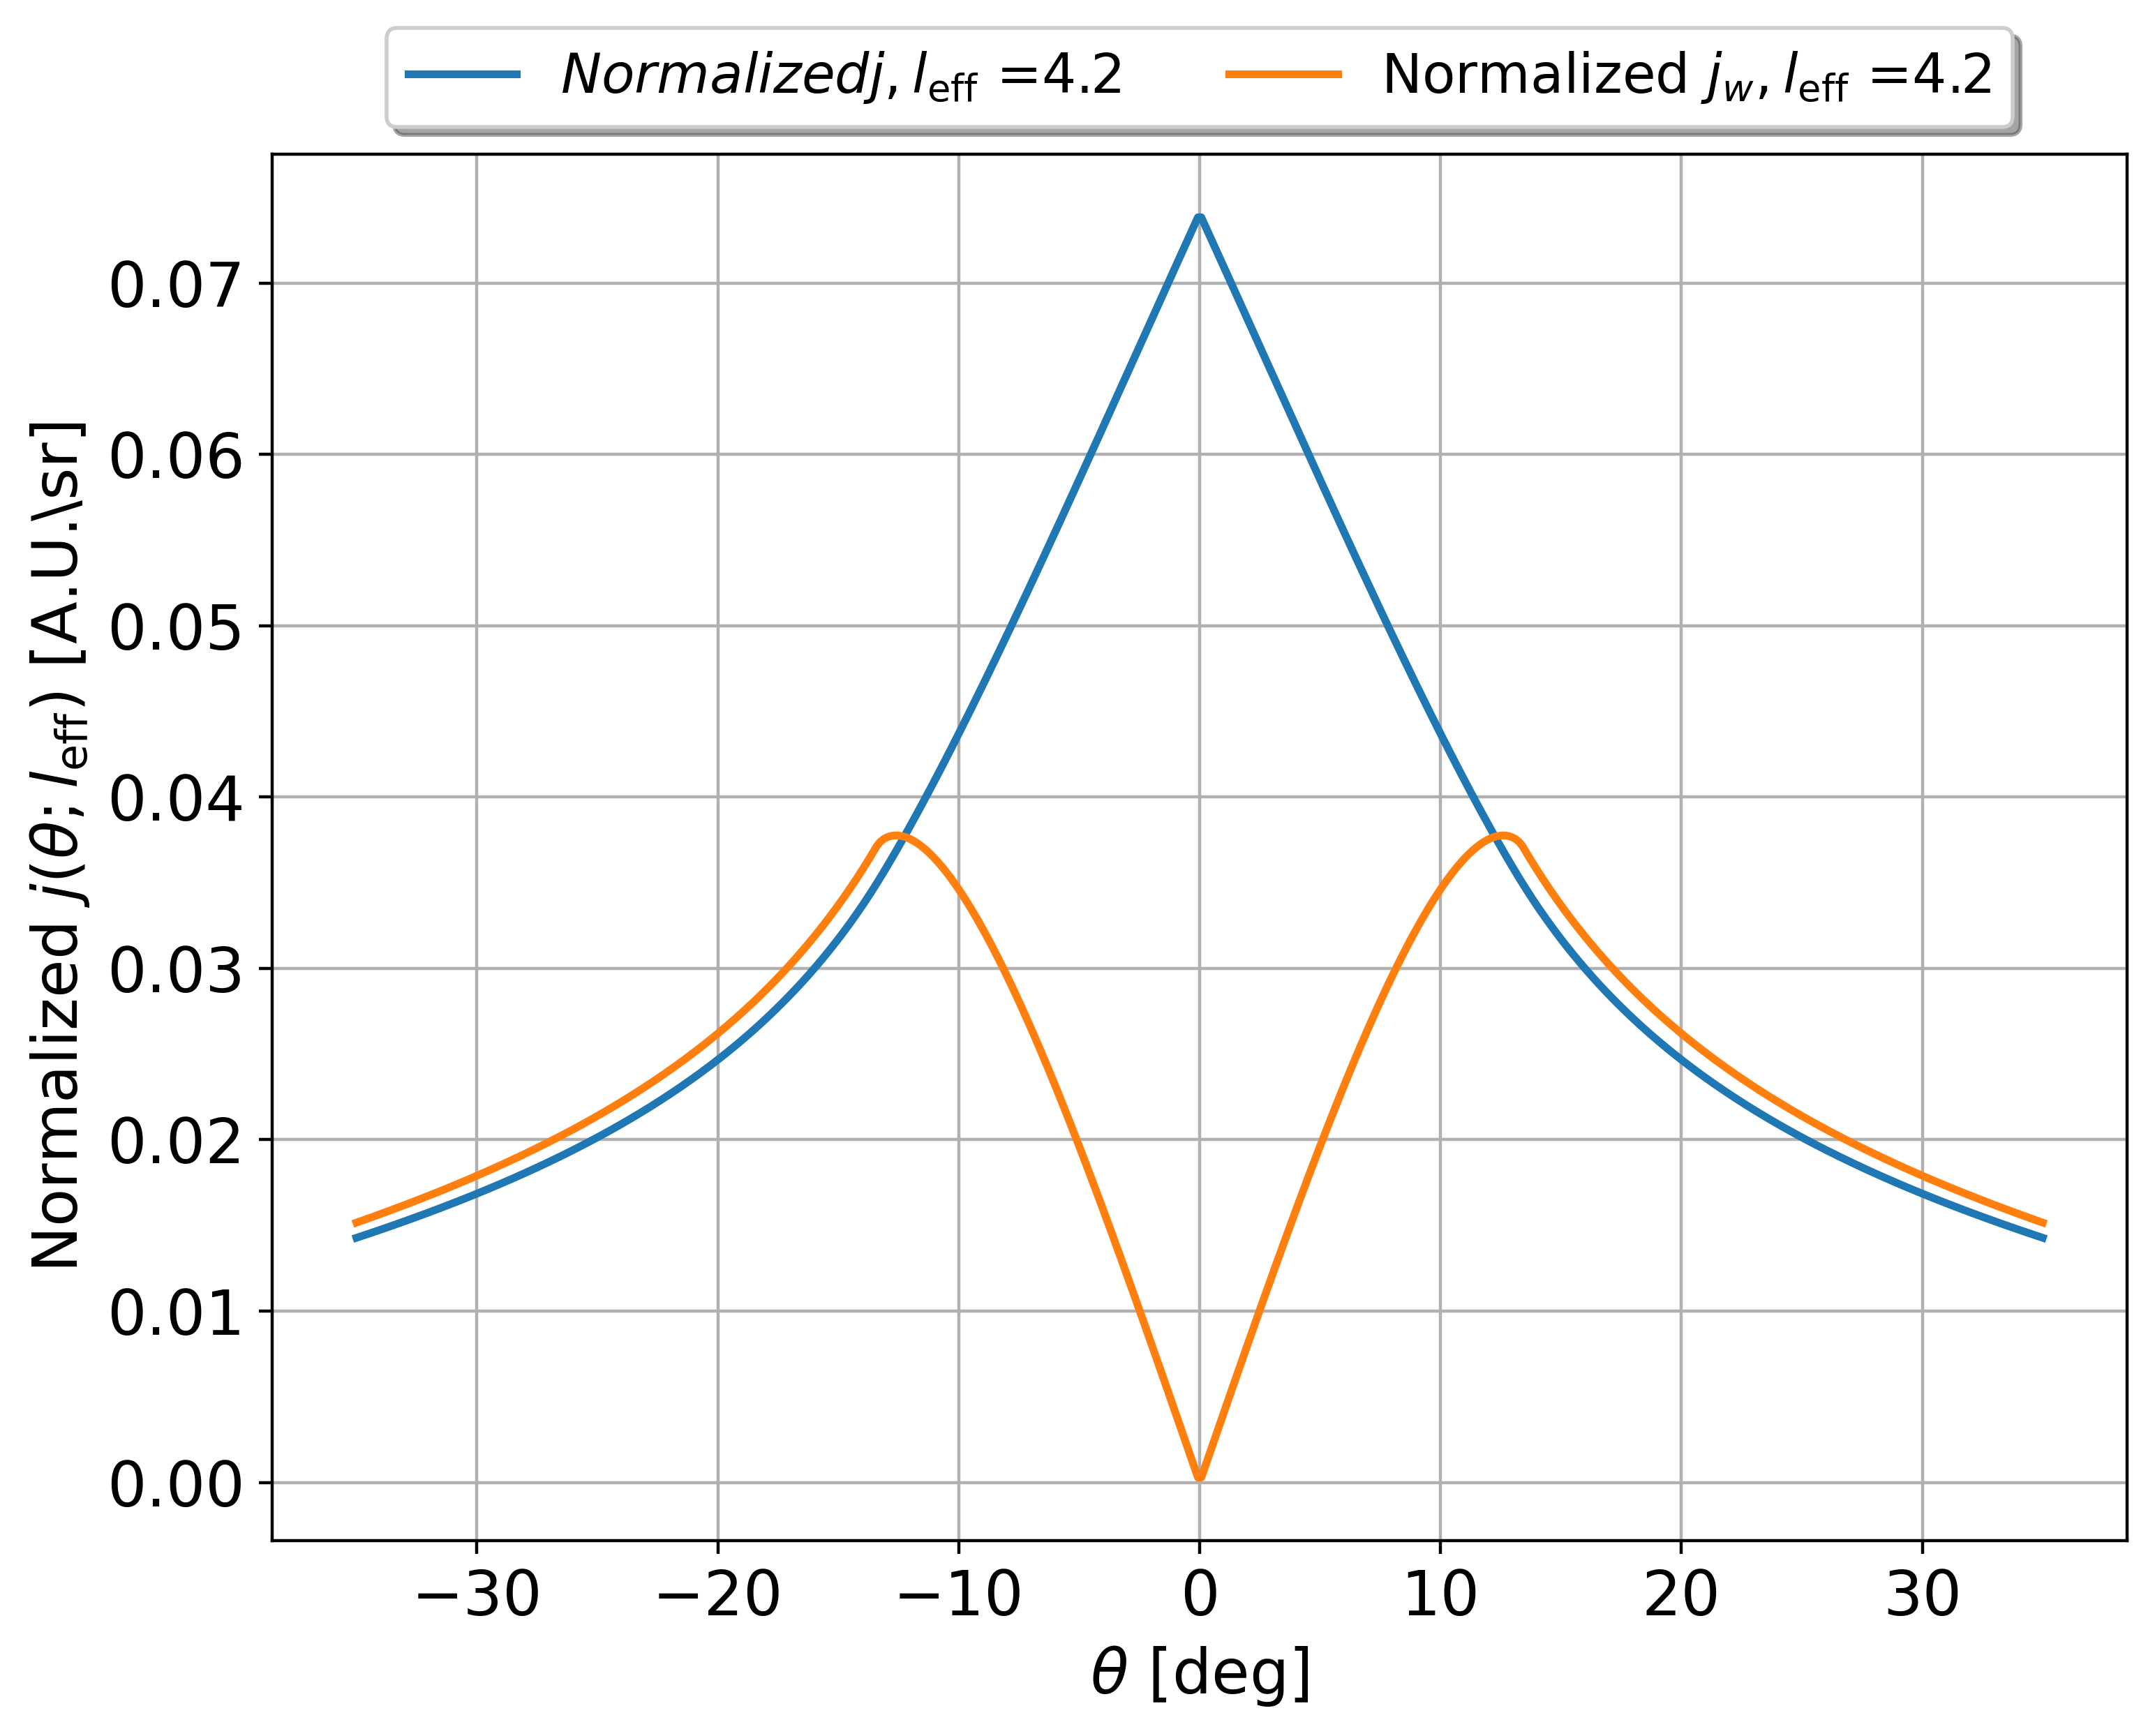

In [56]:
''' j(leff =4.2) annd j_w(lH=12.79) as in "fit"'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [4.2]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x) * degree, l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x) * degree)
    norm = 2*integrate.quad(integrant, 0, 90)[0]
    ys_j = [
          f(x)/norm 
          for x in xs]
    # ys_jd = [np.sin(np.abs(x) * degree)*
    #          (1/1.12)*(1.12*j(np.abs(x) * degree, l_eff = 75) - 
    #          0.12*jw(np.abs(x) * degree, l_eff = l_eff))
    #       for x in xs]
    f = lambda x: jw(np.abs(x) * degree, l_eff=l_eff)
    integrant = lambda x:f(x)*np.sin(np.abs(x) * degree)
    norm = 2*integrate.quad(integrant, 0, 90)[0]
    print("norm", norm)
    ys = [
          f(x)/norm 
          for x in xs]
    print("ys", ys)

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$Normalized j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"Normalized $j(\theta; l_{\rm{eff}})$ [A.U.\sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


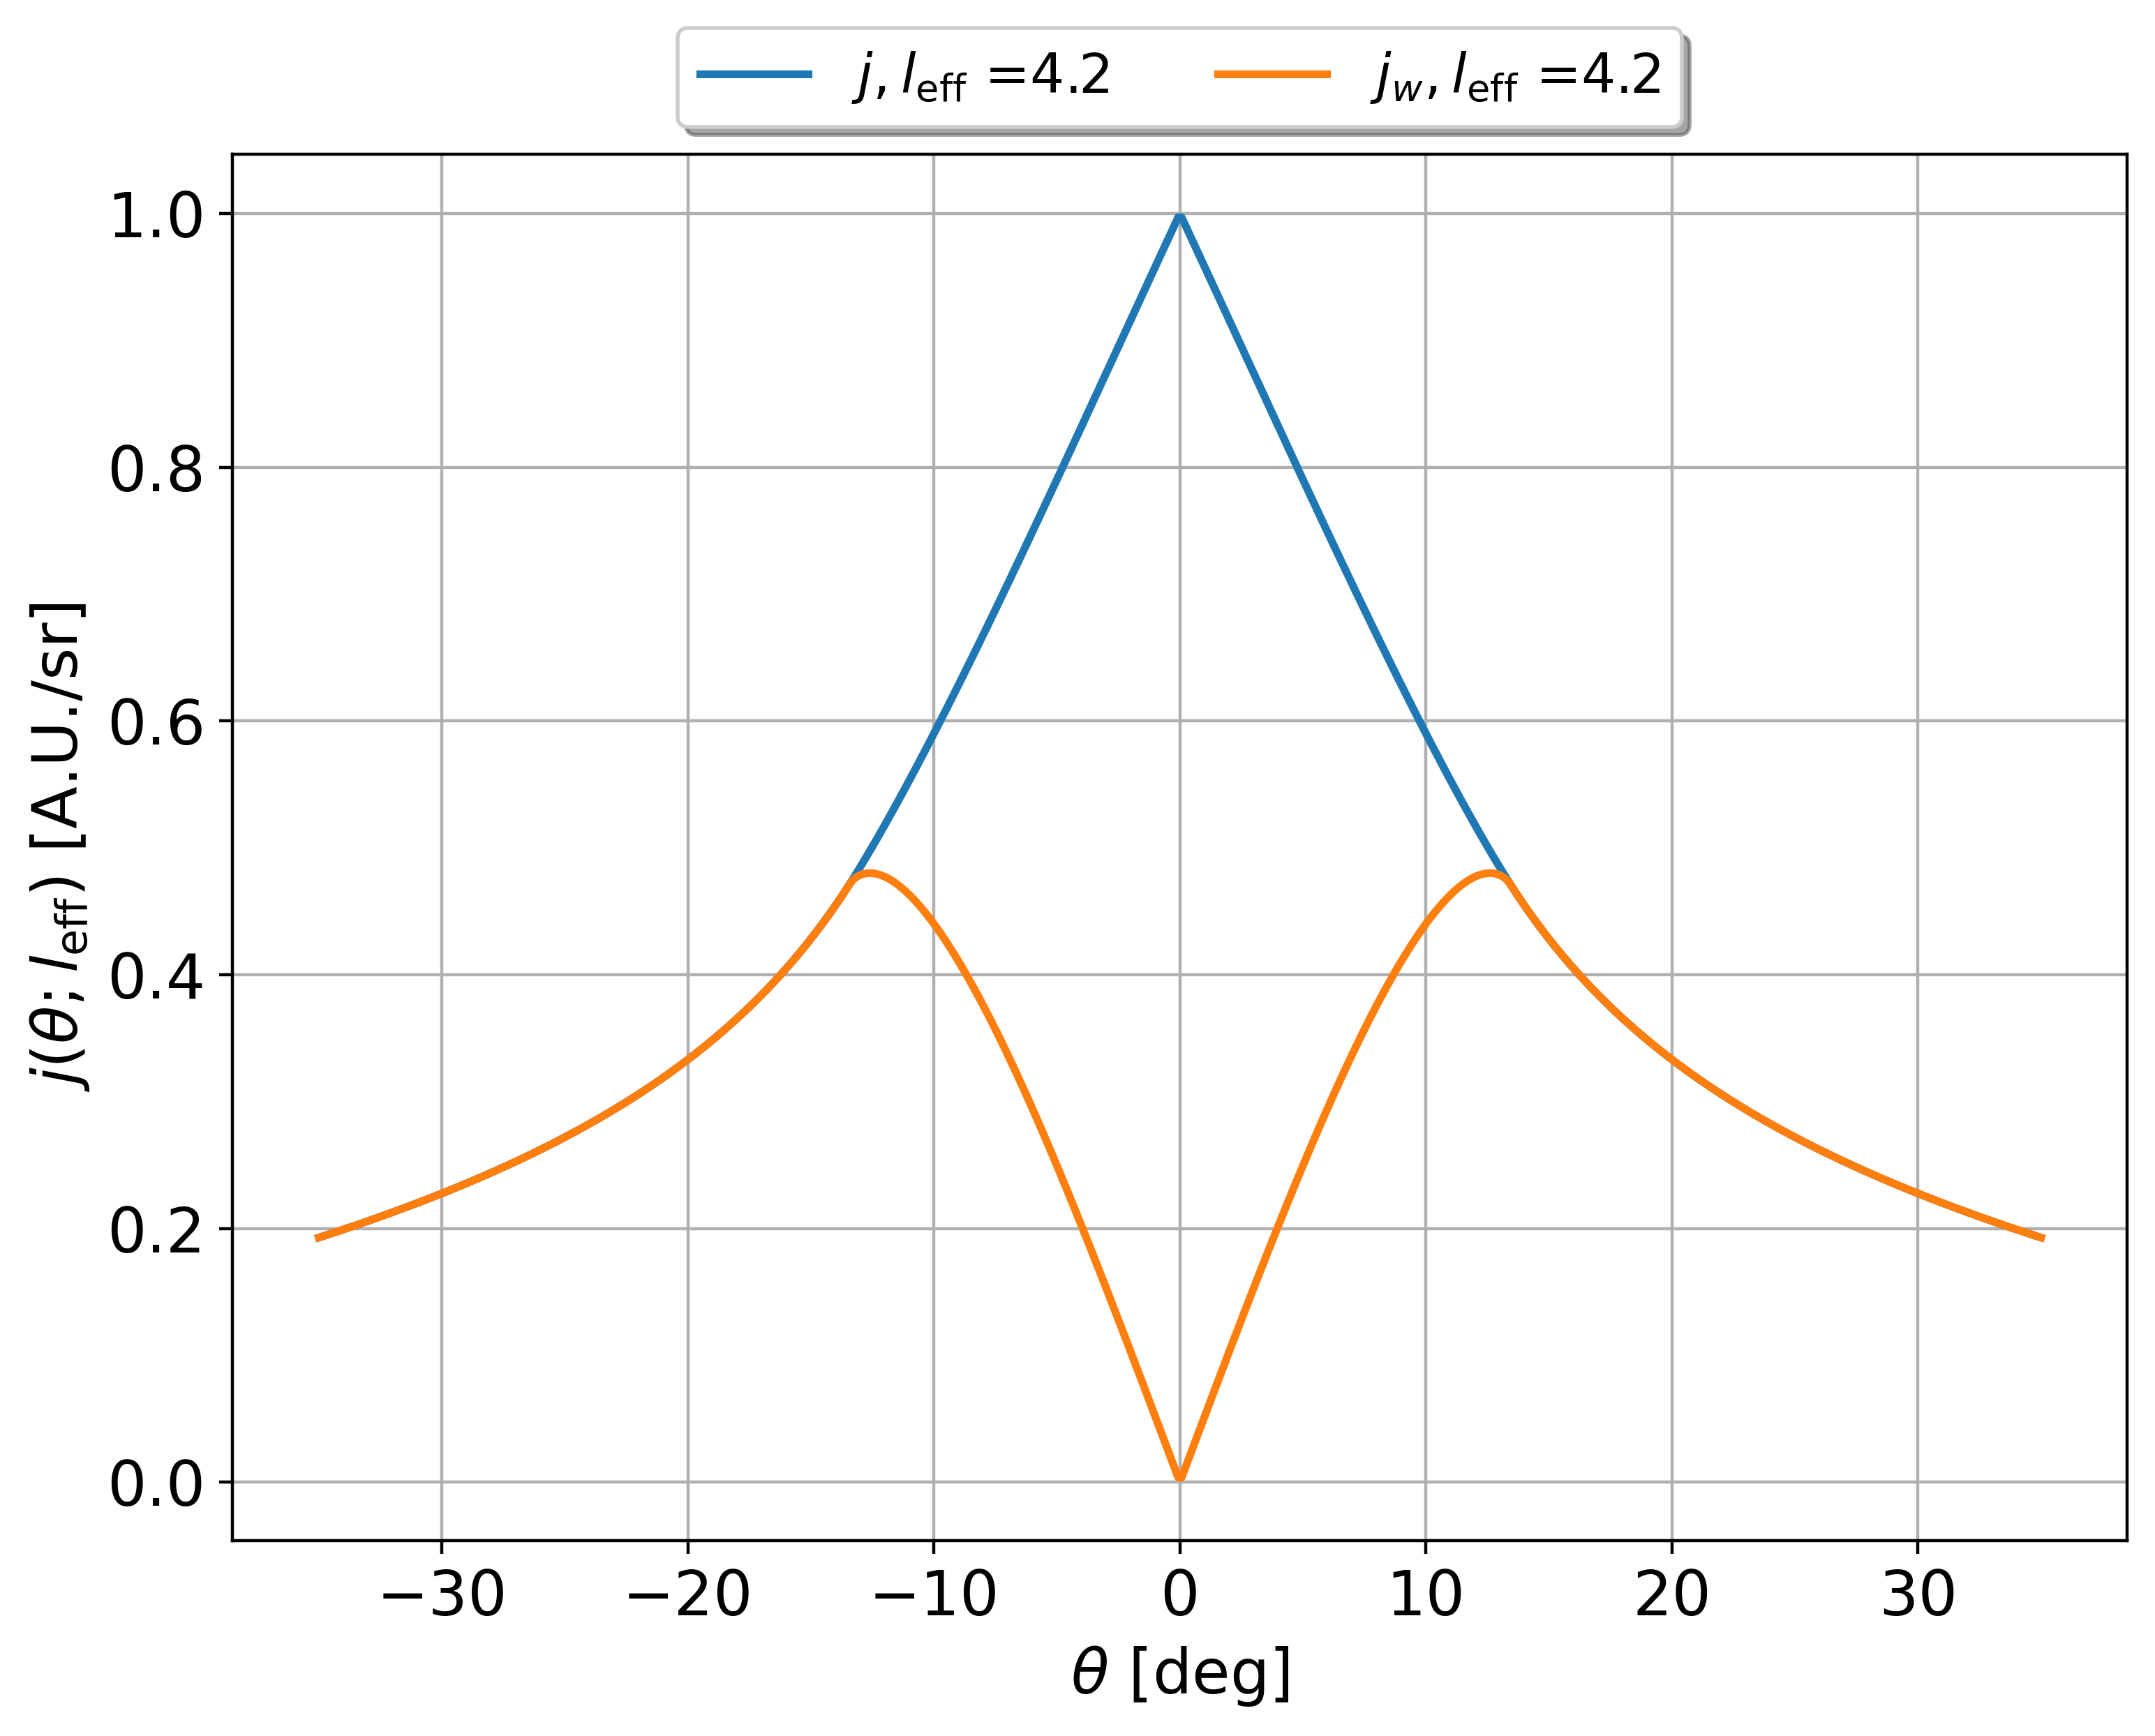

In [33]:
''' j(leff =4.2) annd j_w(lH=12.79) as in "fit"'''
#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [4.2]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5))
ax1=plt.gca()

for l_eff in l_effs:
    xs = np.linspace(-35,35, 500)
    # ys = visible_fraction(xs * degree)
    ys_j = [
            1*j(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]
    # ys_jd = [np.sin(np.abs(x) * degree)*
    #          (1/1.12)*(1.12*j(np.abs(x) * degree, l_eff = 75) - 
    #          0.12*jw(np.abs(x) * degree, l_eff = l_eff))
    #       for x in xs]
    ys = [
          1*jw(np.abs(x) * degree, l_eff = l_eff) 
          for x in xs]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"$j, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys,
            color = "C1" ,
            label = r"$j_w, l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"$j(\theta; l_{\rm{eff}})$ [A.U./sr]")

plt.legend(shadow=True, ncol =3,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)